# Goals of Project:

For my final project in PSYCH-267 Brain Networks, I chose to replicate a portion of “Functional Brain Networks Develop from a ‘Local to Distributed Organization (Fair et al. 2009). Motivation for this project came from two aims: [1] To develop a methodological and conceptual foundation in graph theoretical analysis that could be incorporated into to Stanford Aging & Memory Study, and [2] To attempt to replicate a paper as part of a commitment to reproducibility and transparency in open science. Specifically, I investigated the characterization of four functional brain networks (fronto-parietal [FP], cingulo-opercular [CO], default mode [DN] and cerebellar [CBN] across development. In Fair et al. 2009, small-world topology in graphs— defined by Watts and Strogatz (1998) as possessing a high clustering coefficient and short path lengths—was reportedly found in both children and adults and surprisingly remained constant across development. Further, Fair and colleagues argued for a local to distributed developmental trajectory for network organizational structure based on spring embedded graphs and metrics such as modularity and clustering. For this project I focused on average clustering and shortest path lengths. 



### Import required packages

In [1]:
import os
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import glob
from matplotlib import cm as cm
import itertools



from collections import OrderedDict

import sklearn.preprocessing
import sklearn.linear_model
import sklearn.metrics
import scipy.stats

%matplotlib inline

# Methods Part a:

For this project, I chose to download from the Autism Brain Imaging Data Exchange (ABIDE) preprocessed website (http://preprocessed-connectomes-project.org/abide/). The script to download subjects (download_abide_preproc.py) was utilized to select all subjects between the age 5-30 years of age, who had been preprocessed with Neuroimaging Analysis Kit (NIAK) version 0.7.1, masked based on the dosenbach160 atlas, and had global/no-global signal regression plus bandpass filtering. This yielded a total of 811 total subjects that were further purged based on control status and taking a medication for a final total of 424 subjects used in subsequent analysis. 1D files were converted to txt files and examined for correct structure. Interestingly, when I loaded a single subject into python I noticed 161 ROIs instead of the predicted 160. This lead to a search to verify if I had entered or altered the file in any manner. I located an open issue (https://github.com/preprocessed-connectomes-project/abide/issues/12) that alleviated some concern by stating that ROI 223 is “an intersection between regions label 108/MNI (-5, -52, 17) and label 115/MNI (-11, -58, 17) which are too close.” I thereafter proceeded with the knowledge that all ROIs should match their respective labels. 



### Load matricies

In [2]:
#filenames = glob.glob("/Users/home/Desktop/Final_Project_PSYCH267/noglobal/sorted/*.txt") #NoGSR
filenames = glob.glob("/Users/home/Desktop/Final_Project_PSYCH267/global/*.txt") #GSR
#filenames = glob.glob("/Users/home/Desktop/Final_Project_PSYCH267/cpac/global/*.txt") #Use CPAC to see if it improves
dfs=('001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016','017','018','019','020','021','022','023','024','025','026','027','028','029','030','031','032','033','034','035','036','037','038','039','040','041','042','043','044','045','046','047','048','049','050','051','052','053','054','055','056','057','058','059','060','061','062','063','064','065','066','067','068','069','070','071','072','073','074','075','076','077','078','079','080','081','082','083','084','085','086','087','088','089','090','091','092','093','094','095','096','097','098','099','100','101','102','103','104','105','106','107','108','109','110','111','112','113','114','115','116','117','118','119','120','121','122','123','124','125','126','127','128','129','130','131','132','133','134','135','136','137','138','139','140','141','142','143','144','145','146','147','148','149','150','151','152','153','154','155','156','157','158','159','160','161','162','163','164','165','166','167','168','169','170','171','172','173','174','175','176','177','178','179','180','181','182','183','184','185','186','187','188','189','190','191','192','193','194','195','196','197','198','199','200','201','202','203','204','205','206','207','208','209','210','211','212','213','214','215','216','217','218','219','220','221','222','223','224','225','226','227','228','229','230','231','232','233','234','235','236','237','238','239','240','241','242','243','244','245','246','247','248','249','250','251','252','253','254','255','256','257','258','259','260','261','262','263','264','265','266','267','268','269','270','271','272','273','274','275','276','277','278','279','280','281','282','283','284','285','286','287','288','289','290','291','292','293','294','295','296','297','298','299','300','301','302','303','304','305','306','307','308','309','310','311','312','313','314','315','316','317','318','319','320','321','322','323','324','325','326','327','328','329','330','331','332','333','334','335','336','337','338','339','340','341','342','343','344','345','346','347','348','349','350','351','352','353','354','355','356','357','358','359','360','361','362','363','364','365','366','367','368','369','370','371','372','373','374','375','376','377','378','379','380','381','382','383','384','385','386','387','388','389','390','391','392','393','394','395','396','397','398','399','400','401','402','403','404','405','406','407','408','409','410','411','412','413','414','415','416','417','418','419','420','421','422','423','424')


### Make a large dictionary with all subjects txt files

In [3]:
list_of_dfs = {}
for df, file in zip(dfs, filenames):
    list_of_dfs[df] = np.loadtxt(file)

### Make a large dictionary with all subjects matricies 

In [4]:
list_of_mx = {}
for df in dfs:
    list_of_mx[df] = np.corrcoef(list_of_dfs[df][:,1:].T)
#for df in dfs:
#    list_of_mx[df] = np.corrcoef(list_of_dfs[df])



 Zero out any nan values

In [5]:
for df in dfs:
    list_of_mx[df][np.isnan(list_of_mx[df])]=0

### Functions to tranform data 

In [6]:
def r_to_z(r):
    #fisher transform
    z=0.5*np.log((1.0+r)/(1.0-r))
    z[np.where(np.isinf(z))]=0
    z[np.where(np.isnan(z))]=0
    
    return z

def z_to_r(z):
    #inverse transform
    return (np.exp(2.0*z) - 1)/(np.exp(2.0*z) +1)

### Z-transform the data

In [7]:
z_matrix = {}
for s in list_of_mx:
    z_matrix[s]=r_to_z(list_of_mx[s])

/Users/home/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


# Methods Part b:

In Fair et al. 2009, a sliding boxcar grouping (60 per group) was performed to capture average age-group matrices. For this analysis, I chose 100 subjects per group for a total of 325 groups. With access to the data, I could have demarcated how a decision was reached by Fair and colleagues, but without access to the original data this proved infeasible.


### Make the slidingboxcar groups mean matricies 

In [8]:
group1=dict(itertools.islice(z_matrix.items(),0,100))
group2=dict(itertools.islice(z_matrix.items(),1,101))
group3=dict(itertools.islice(z_matrix.items(),2,102))
group4=dict(itertools.islice(z_matrix.items(),3,103))
group5=dict(itertools.islice(z_matrix.items(),4,104))
group6=dict(itertools.islice(z_matrix.items(),5,105))
group7=dict(itertools.islice(z_matrix.items(),6,106))
group8=dict(itertools.islice(z_matrix.items(),7,107))
group9=dict(itertools.islice(z_matrix.items(),8,108))
group10=dict(itertools.islice(z_matrix.items(),9,109))
group11=dict(itertools.islice(z_matrix.items(),10,110))
group12=dict(itertools.islice(z_matrix.items(),11,111))
group13=dict(itertools.islice(z_matrix.items(),12,112))
group14=dict(itertools.islice(z_matrix.items(),13,113))
group15=dict(itertools.islice(z_matrix.items(),14,114))
group16=dict(itertools.islice(z_matrix.items(),15,115))
group17=dict(itertools.islice(z_matrix.items(),16,116))
group18=dict(itertools.islice(z_matrix.items(),17,117))
group19=dict(itertools.islice(z_matrix.items(),18,118))
group20=dict(itertools.islice(z_matrix.items(),19,119))
group21=dict(itertools.islice(z_matrix.items(),20,120))
group22=dict(itertools.islice(z_matrix.items(),21,121))
group23=dict(itertools.islice(z_matrix.items(),22,122))
group24=dict(itertools.islice(z_matrix.items(),23,123))
group25=dict(itertools.islice(z_matrix.items(),24,124))
group26=dict(itertools.islice(z_matrix.items(),25,125))
group27=dict(itertools.islice(z_matrix.items(),26,126))
group28=dict(itertools.islice(z_matrix.items(),27,127))
group29=dict(itertools.islice(z_matrix.items(),28,128))
group30=dict(itertools.islice(z_matrix.items(),29,129))
group31=dict(itertools.islice(z_matrix.items(),30,130))
group32=dict(itertools.islice(z_matrix.items(),31,131))
group33=dict(itertools.islice(z_matrix.items(),32,132))
group34=dict(itertools.islice(z_matrix.items(),33,133))
group35=dict(itertools.islice(z_matrix.items(),34,134))
group36=dict(itertools.islice(z_matrix.items(),35,135))
group37=dict(itertools.islice(z_matrix.items(),36,136))
group38=dict(itertools.islice(z_matrix.items(),37,137))
group39=dict(itertools.islice(z_matrix.items(),38,138))
group40=dict(itertools.islice(z_matrix.items(),39,139))
group41=dict(itertools.islice(z_matrix.items(),40,140))
group42=dict(itertools.islice(z_matrix.items(),41,141))
group43=dict(itertools.islice(z_matrix.items(),42,142))
group44=dict(itertools.islice(z_matrix.items(),43,143))
group45=dict(itertools.islice(z_matrix.items(),44,144))
group46=dict(itertools.islice(z_matrix.items(),45,145))
group47=dict(itertools.islice(z_matrix.items(),46,146))
group48=dict(itertools.islice(z_matrix.items(),47,147))
group49=dict(itertools.islice(z_matrix.items(),48,148))
group50=dict(itertools.islice(z_matrix.items(),49,149))
group51=dict(itertools.islice(z_matrix.items(),50,150))
group52=dict(itertools.islice(z_matrix.items(),51,151))
group53=dict(itertools.islice(z_matrix.items(),52,152))
group54=dict(itertools.islice(z_matrix.items(),53,153))
group55=dict(itertools.islice(z_matrix.items(),54,154))
group56=dict(itertools.islice(z_matrix.items(),55,155))
group57=dict(itertools.islice(z_matrix.items(),56,156))
group58=dict(itertools.islice(z_matrix.items(),57,157))
group59=dict(itertools.islice(z_matrix.items(),58,158))
group60=dict(itertools.islice(z_matrix.items(),59,159))
group61=dict(itertools.islice(z_matrix.items(),60,160))
group62=dict(itertools.islice(z_matrix.items(),61,161))
group63=dict(itertools.islice(z_matrix.items(),62,162))
group64=dict(itertools.islice(z_matrix.items(),63,163))
group65=dict(itertools.islice(z_matrix.items(),64,164))
group66=dict(itertools.islice(z_matrix.items(),65,165))
group67=dict(itertools.islice(z_matrix.items(),66,166))
group68=dict(itertools.islice(z_matrix.items(),67,167))
group69=dict(itertools.islice(z_matrix.items(),68,168))
group70=dict(itertools.islice(z_matrix.items(),69,169))
group71=dict(itertools.islice(z_matrix.items(),70,170))
group72=dict(itertools.islice(z_matrix.items(),71,171))
group73=dict(itertools.islice(z_matrix.items(),72,172))
group74=dict(itertools.islice(z_matrix.items(),73,173))
group75=dict(itertools.islice(z_matrix.items(),74,174))
group76=dict(itertools.islice(z_matrix.items(),75,175))
group77=dict(itertools.islice(z_matrix.items(),76,176))
group78=dict(itertools.islice(z_matrix.items(),77,177))
group79=dict(itertools.islice(z_matrix.items(),78,178))
group80=dict(itertools.islice(z_matrix.items(),79,179))
group81=dict(itertools.islice(z_matrix.items(),80,180))
group82=dict(itertools.islice(z_matrix.items(),81,181))
group83=dict(itertools.islice(z_matrix.items(),82,182))
group84=dict(itertools.islice(z_matrix.items(),83,183))
group85=dict(itertools.islice(z_matrix.items(),84,184))
group86=dict(itertools.islice(z_matrix.items(),85,185))
group87=dict(itertools.islice(z_matrix.items(),86,186))
group88=dict(itertools.islice(z_matrix.items(),87,187))
group89=dict(itertools.islice(z_matrix.items(),88,188))
group90=dict(itertools.islice(z_matrix.items(),89,189))
group91=dict(itertools.islice(z_matrix.items(),90,190))
group92=dict(itertools.islice(z_matrix.items(),91,191))
group93=dict(itertools.islice(z_matrix.items(),92,192))
group94=dict(itertools.islice(z_matrix.items(),93,193))
group95=dict(itertools.islice(z_matrix.items(),94,194))
group96=dict(itertools.islice(z_matrix.items(),95,195))
group97=dict(itertools.islice(z_matrix.items(),96,196))
group98=dict(itertools.islice(z_matrix.items(),97,197))
group99=dict(itertools.islice(z_matrix.items(),98,198))
group100=dict(itertools.islice(z_matrix.items(),99,199))
group101=dict(itertools.islice(z_matrix.items(),100,200))
group102=dict(itertools.islice(z_matrix.items(),101,201))
group103=dict(itertools.islice(z_matrix.items(),102,202))
group104=dict(itertools.islice(z_matrix.items(),103,203))
group105=dict(itertools.islice(z_matrix.items(),104,204))
group106=dict(itertools.islice(z_matrix.items(),105,205))
group107=dict(itertools.islice(z_matrix.items(),106,206))
group108=dict(itertools.islice(z_matrix.items(),107,207))
group109=dict(itertools.islice(z_matrix.items(),108,208))
group110=dict(itertools.islice(z_matrix.items(),109,209))
group111=dict(itertools.islice(z_matrix.items(),110,210))
group112=dict(itertools.islice(z_matrix.items(),111,211))
group113=dict(itertools.islice(z_matrix.items(),112,212))
group114=dict(itertools.islice(z_matrix.items(),113,213))
group115=dict(itertools.islice(z_matrix.items(),114,214))
group116=dict(itertools.islice(z_matrix.items(),115,215))
group117=dict(itertools.islice(z_matrix.items(),116,216))
group118=dict(itertools.islice(z_matrix.items(),117,217))
group119=dict(itertools.islice(z_matrix.items(),118,218))
group120=dict(itertools.islice(z_matrix.items(),119,219))
group121=dict(itertools.islice(z_matrix.items(),120,220))
group122=dict(itertools.islice(z_matrix.items(),121,221))
group123=dict(itertools.islice(z_matrix.items(),122,222))
group124=dict(itertools.islice(z_matrix.items(),123,223))
group125=dict(itertools.islice(z_matrix.items(),124,224))
group126=dict(itertools.islice(z_matrix.items(),125,225))
group127=dict(itertools.islice(z_matrix.items(),126,226))
group128=dict(itertools.islice(z_matrix.items(),127,227))
group129=dict(itertools.islice(z_matrix.items(),128,228))
group130=dict(itertools.islice(z_matrix.items(),129,229))
group131=dict(itertools.islice(z_matrix.items(),130,230))
group132=dict(itertools.islice(z_matrix.items(),131,231))
group133=dict(itertools.islice(z_matrix.items(),132,232))
group134=dict(itertools.islice(z_matrix.items(),133,233))
group135=dict(itertools.islice(z_matrix.items(),134,234))
group136=dict(itertools.islice(z_matrix.items(),135,235))
group137=dict(itertools.islice(z_matrix.items(),136,236))
group138=dict(itertools.islice(z_matrix.items(),137,237))
group139=dict(itertools.islice(z_matrix.items(),138,238))
group140=dict(itertools.islice(z_matrix.items(),139,239))
group141=dict(itertools.islice(z_matrix.items(),140,240))
group142=dict(itertools.islice(z_matrix.items(),141,241))
group143=dict(itertools.islice(z_matrix.items(),142,242))
group144=dict(itertools.islice(z_matrix.items(),143,243))
group145=dict(itertools.islice(z_matrix.items(),144,244))
group146=dict(itertools.islice(z_matrix.items(),145,245))
group147=dict(itertools.islice(z_matrix.items(),146,246))
group148=dict(itertools.islice(z_matrix.items(),147,247))
group149=dict(itertools.islice(z_matrix.items(),148,248))
group150=dict(itertools.islice(z_matrix.items(),149,249))
group151=dict(itertools.islice(z_matrix.items(),150,250))
group152=dict(itertools.islice(z_matrix.items(),151,251))
group153=dict(itertools.islice(z_matrix.items(),152,252))
group154=dict(itertools.islice(z_matrix.items(),153,253))
group155=dict(itertools.islice(z_matrix.items(),154,254))
group156=dict(itertools.islice(z_matrix.items(),155,255))
group157=dict(itertools.islice(z_matrix.items(),156,256))
group158=dict(itertools.islice(z_matrix.items(),157,257))
group159=dict(itertools.islice(z_matrix.items(),158,258))
group160=dict(itertools.islice(z_matrix.items(),159,259))
group161=dict(itertools.islice(z_matrix.items(),160,260))
group162=dict(itertools.islice(z_matrix.items(),161,261))
group163=dict(itertools.islice(z_matrix.items(),162,262))
group164=dict(itertools.islice(z_matrix.items(),163,263))
group165=dict(itertools.islice(z_matrix.items(),164,264))
group166=dict(itertools.islice(z_matrix.items(),165,265))
group167=dict(itertools.islice(z_matrix.items(),166,266))
group168=dict(itertools.islice(z_matrix.items(),167,267))
group169=dict(itertools.islice(z_matrix.items(),168,268))
group170=dict(itertools.islice(z_matrix.items(),169,269))
group171=dict(itertools.islice(z_matrix.items(),170,270))
group172=dict(itertools.islice(z_matrix.items(),171,271))
group173=dict(itertools.islice(z_matrix.items(),172,272))
group174=dict(itertools.islice(z_matrix.items(),173,273))
group175=dict(itertools.islice(z_matrix.items(),174,274))
group176=dict(itertools.islice(z_matrix.items(),175,275))
group177=dict(itertools.islice(z_matrix.items(),176,276))
group178=dict(itertools.islice(z_matrix.items(),177,277))
group179=dict(itertools.islice(z_matrix.items(),178,278))
group180=dict(itertools.islice(z_matrix.items(),179,279))
group181=dict(itertools.islice(z_matrix.items(),180,280))
group182=dict(itertools.islice(z_matrix.items(),181,281))
group183=dict(itertools.islice(z_matrix.items(),182,282))
group184=dict(itertools.islice(z_matrix.items(),183,283))
group185=dict(itertools.islice(z_matrix.items(),184,284))
group186=dict(itertools.islice(z_matrix.items(),185,285))
group187=dict(itertools.islice(z_matrix.items(),186,286))
group188=dict(itertools.islice(z_matrix.items(),187,287))
group189=dict(itertools.islice(z_matrix.items(),188,288))
group190=dict(itertools.islice(z_matrix.items(),189,289))
group191=dict(itertools.islice(z_matrix.items(),190,290))
group192=dict(itertools.islice(z_matrix.items(),191,291))
group193=dict(itertools.islice(z_matrix.items(),192,292))
group194=dict(itertools.islice(z_matrix.items(),193,293))
group195=dict(itertools.islice(z_matrix.items(),194,294))
group196=dict(itertools.islice(z_matrix.items(),195,295))
group197=dict(itertools.islice(z_matrix.items(),196,296))
group198=dict(itertools.islice(z_matrix.items(),197,297))
group199=dict(itertools.islice(z_matrix.items(),198,298))
group200=dict(itertools.islice(z_matrix.items(),199,299))
group201=dict(itertools.islice(z_matrix.items(),200,300))
group202=dict(itertools.islice(z_matrix.items(),201,301))
group203=dict(itertools.islice(z_matrix.items(),202,302))
group204=dict(itertools.islice(z_matrix.items(),203,303))
group205=dict(itertools.islice(z_matrix.items(),204,304))
group206=dict(itertools.islice(z_matrix.items(),205,305))
group207=dict(itertools.islice(z_matrix.items(),206,306))
group208=dict(itertools.islice(z_matrix.items(),207,307))
group209=dict(itertools.islice(z_matrix.items(),208,308))
group210=dict(itertools.islice(z_matrix.items(),209,309))
group211=dict(itertools.islice(z_matrix.items(),210,310))
group212=dict(itertools.islice(z_matrix.items(),211,311))
group213=dict(itertools.islice(z_matrix.items(),212,312))
group214=dict(itertools.islice(z_matrix.items(),213,313))
group215=dict(itertools.islice(z_matrix.items(),214,314))
group216=dict(itertools.islice(z_matrix.items(),215,315))
group217=dict(itertools.islice(z_matrix.items(),216,316))
group218=dict(itertools.islice(z_matrix.items(),217,317))
group219=dict(itertools.islice(z_matrix.items(),218,318))
group220=dict(itertools.islice(z_matrix.items(),219,319))
group221=dict(itertools.islice(z_matrix.items(),220,320))
group222=dict(itertools.islice(z_matrix.items(),221,321))
group223=dict(itertools.islice(z_matrix.items(),222,322))
group224=dict(itertools.islice(z_matrix.items(),223,323))
group225=dict(itertools.islice(z_matrix.items(),224,324))
group226=dict(itertools.islice(z_matrix.items(),225,325))
group227=dict(itertools.islice(z_matrix.items(),226,326))
group228=dict(itertools.islice(z_matrix.items(),227,327))
group229=dict(itertools.islice(z_matrix.items(),228,328))
group230=dict(itertools.islice(z_matrix.items(),229,329))
group231=dict(itertools.islice(z_matrix.items(),230,330))
group232=dict(itertools.islice(z_matrix.items(),231,331))
group233=dict(itertools.islice(z_matrix.items(),232,332))
group234=dict(itertools.islice(z_matrix.items(),233,333))
group235=dict(itertools.islice(z_matrix.items(),234,334))
group236=dict(itertools.islice(z_matrix.items(),235,335))
group237=dict(itertools.islice(z_matrix.items(),236,336))
group238=dict(itertools.islice(z_matrix.items(),237,337))
group239=dict(itertools.islice(z_matrix.items(),238,338))
group240=dict(itertools.islice(z_matrix.items(),239,339))
group241=dict(itertools.islice(z_matrix.items(),240,340))
group242=dict(itertools.islice(z_matrix.items(),241,341))
group243=dict(itertools.islice(z_matrix.items(),242,342))
group244=dict(itertools.islice(z_matrix.items(),243,343))
group245=dict(itertools.islice(z_matrix.items(),244,344))
group246=dict(itertools.islice(z_matrix.items(),245,345))
group247=dict(itertools.islice(z_matrix.items(),246,346))
group248=dict(itertools.islice(z_matrix.items(),247,347))
group249=dict(itertools.islice(z_matrix.items(),248,348))
group250=dict(itertools.islice(z_matrix.items(),249,349))
group251=dict(itertools.islice(z_matrix.items(),250,350))
group252=dict(itertools.islice(z_matrix.items(),251,351))
group253=dict(itertools.islice(z_matrix.items(),252,352))
group254=dict(itertools.islice(z_matrix.items(),253,353))
group255=dict(itertools.islice(z_matrix.items(),254,354))
group256=dict(itertools.islice(z_matrix.items(),255,355))
group257=dict(itertools.islice(z_matrix.items(),256,356))
group258=dict(itertools.islice(z_matrix.items(),257,357))
group259=dict(itertools.islice(z_matrix.items(),258,358))
group260=dict(itertools.islice(z_matrix.items(),259,359))
group261=dict(itertools.islice(z_matrix.items(),260,360))
group262=dict(itertools.islice(z_matrix.items(),261,361))
group263=dict(itertools.islice(z_matrix.items(),262,362))
group264=dict(itertools.islice(z_matrix.items(),263,363))
group265=dict(itertools.islice(z_matrix.items(),264,364))
group266=dict(itertools.islice(z_matrix.items(),265,365))
group267=dict(itertools.islice(z_matrix.items(),266,366))
group268=dict(itertools.islice(z_matrix.items(),267,367))
group269=dict(itertools.islice(z_matrix.items(),268,368))
group270=dict(itertools.islice(z_matrix.items(),269,369))
group271=dict(itertools.islice(z_matrix.items(),270,370))
group272=dict(itertools.islice(z_matrix.items(),271,371))
group273=dict(itertools.islice(z_matrix.items(),272,372))
group274=dict(itertools.islice(z_matrix.items(),273,373))
group275=dict(itertools.islice(z_matrix.items(),274,374))
group276=dict(itertools.islice(z_matrix.items(),275,375))
group277=dict(itertools.islice(z_matrix.items(),276,376))
group278=dict(itertools.islice(z_matrix.items(),277,377))
group279=dict(itertools.islice(z_matrix.items(),278,378))
group280=dict(itertools.islice(z_matrix.items(),279,379))
group281=dict(itertools.islice(z_matrix.items(),280,380))
group282=dict(itertools.islice(z_matrix.items(),281,381))
group283=dict(itertools.islice(z_matrix.items(),282,382))
group284=dict(itertools.islice(z_matrix.items(),283,383))
group285=dict(itertools.islice(z_matrix.items(),284,384))
group286=dict(itertools.islice(z_matrix.items(),285,385))
group287=dict(itertools.islice(z_matrix.items(),286,386))
group288=dict(itertools.islice(z_matrix.items(),287,387))
group289=dict(itertools.islice(z_matrix.items(),288,388))
group290=dict(itertools.islice(z_matrix.items(),289,389))
group291=dict(itertools.islice(z_matrix.items(),290,390))
group292=dict(itertools.islice(z_matrix.items(),291,391))
group293=dict(itertools.islice(z_matrix.items(),292,392))
group294=dict(itertools.islice(z_matrix.items(),293,393))
group295=dict(itertools.islice(z_matrix.items(),294,394))
group296=dict(itertools.islice(z_matrix.items(),295,395))
group297=dict(itertools.islice(z_matrix.items(),296,396))
group298=dict(itertools.islice(z_matrix.items(),297,397))
group299=dict(itertools.islice(z_matrix.items(),298,398))
group300=dict(itertools.islice(z_matrix.items(),299,399))
group301=dict(itertools.islice(z_matrix.items(),300,400))
group302=dict(itertools.islice(z_matrix.items(),301,401))
group303=dict(itertools.islice(z_matrix.items(),302,402))
group304=dict(itertools.islice(z_matrix.items(),303,403))
group305=dict(itertools.islice(z_matrix.items(),304,404))
group306=dict(itertools.islice(z_matrix.items(),305,405))
group307=dict(itertools.islice(z_matrix.items(),306,406))
group308=dict(itertools.islice(z_matrix.items(),307,407))
group309=dict(itertools.islice(z_matrix.items(),308,408))
group310=dict(itertools.islice(z_matrix.items(),309,409))
group311=dict(itertools.islice(z_matrix.items(),310,410))
group312=dict(itertools.islice(z_matrix.items(),311,411))
group313=dict(itertools.islice(z_matrix.items(),312,412))
group314=dict(itertools.islice(z_matrix.items(),313,413))
group315=dict(itertools.islice(z_matrix.items(),314,414))
group316=dict(itertools.islice(z_matrix.items(),315,415))
group317=dict(itertools.islice(z_matrix.items(),316,416))
group318=dict(itertools.islice(z_matrix.items(),317,417))
group319=dict(itertools.islice(z_matrix.items(),318,418))
group320=dict(itertools.islice(z_matrix.items(),319,419))
group321=dict(itertools.islice(z_matrix.items(),320,420))
group322=dict(itertools.islice(z_matrix.items(),321,421))
group323=dict(itertools.islice(z_matrix.items(),322,422))
group324=dict(itertools.islice(z_matrix.items(),323,423))
group325=dict(itertools.islice(z_matrix.items(),324,424))

### Take average of each group of matricies 

I ran a quick sanity check using the averaging code from Pset3, and found the same result for grouping. 

In [9]:
Gmean001=(sum(group1.values())/100)
Gmean002=(sum(group2.values())/100)
Gmean003=(sum(group3.values())/100)
Gmean004=(sum(group4.values())/100)
Gmean005=(sum(group5.values())/100)
Gmean006=(sum(group6.values())/100)
Gmean007=(sum(group7.values())/100)
Gmean008=(sum(group8.values())/100)
Gmean009=(sum(group9.values())/100)
Gmean010=(sum(group10.values())/100)
Gmean011=(sum(group11.values())/100)
Gmean012=(sum(group12.values())/100)
Gmean013=(sum(group13.values())/100)
Gmean014=(sum(group14.values())/100)
Gmean015=(sum(group15.values())/100)
Gmean016=(sum(group16.values())/100)
Gmean017=(sum(group17.values())/100)
Gmean018=(sum(group18.values())/100)
Gmean019=(sum(group19.values())/100)
Gmean020=(sum(group20.values())/100)
Gmean021=(sum(group21.values())/100)
Gmean022=(sum(group22.values())/100)
Gmean023=(sum(group23.values())/100)
Gmean024=(sum(group24.values())/100)
Gmean025=(sum(group25.values())/100)
Gmean026=(sum(group26.values())/100)
Gmean027=(sum(group27.values())/100)
Gmean028=(sum(group28.values())/100)
Gmean029=(sum(group29.values())/100)
Gmean030=(sum(group30.values())/100)
Gmean031=(sum(group31.values())/100)
Gmean032=(sum(group32.values())/100)
Gmean033=(sum(group33.values())/100)
Gmean034=(sum(group34.values())/100)
Gmean035=(sum(group35.values())/100)
Gmean036=(sum(group36.values())/100)
Gmean037=(sum(group37.values())/100)
Gmean038=(sum(group38.values())/100)
Gmean039=(sum(group39.values())/100)
Gmean040=(sum(group40.values())/100)
Gmean041=(sum(group41.values())/100)
Gmean042=(sum(group42.values())/100)
Gmean043=(sum(group43.values())/100)
Gmean044=(sum(group44.values())/100)
Gmean045=(sum(group45.values())/100)
Gmean046=(sum(group46.values())/100)
Gmean047=(sum(group47.values())/100)
Gmean048=(sum(group48.values())/100)
Gmean049=(sum(group49.values())/100)
Gmean050=(sum(group50.values())/100)
Gmean051=(sum(group51.values())/100)
Gmean052=(sum(group52.values())/100)
Gmean053=(sum(group53.values())/100)
Gmean054=(sum(group54.values())/100)
Gmean055=(sum(group55.values())/100)
Gmean056=(sum(group56.values())/100)
Gmean057=(sum(group57.values())/100)
Gmean058=(sum(group58.values())/100)
Gmean059=(sum(group59.values())/100)
Gmean060=(sum(group60.values())/100)
Gmean061=(sum(group61.values())/100)
Gmean062=(sum(group62.values())/100)
Gmean063=(sum(group63.values())/100)
Gmean064=(sum(group64.values())/100)
Gmean065=(sum(group65.values())/100)
Gmean066=(sum(group66.values())/100)
Gmean067=(sum(group67.values())/100)
Gmean068=(sum(group68.values())/100)
Gmean069=(sum(group69.values())/100)
Gmean070=(sum(group70.values())/100)
Gmean071=(sum(group71.values())/100)
Gmean072=(sum(group72.values())/100)
Gmean073=(sum(group73.values())/100)
Gmean074=(sum(group74.values())/100)
Gmean075=(sum(group75.values())/100)
Gmean076=(sum(group76.values())/100)
Gmean077=(sum(group77.values())/100)
Gmean078=(sum(group78.values())/100)
Gmean079=(sum(group79.values())/100)
Gmean080=(sum(group80.values())/100)
Gmean081=(sum(group81.values())/100)
Gmean082=(sum(group82.values())/100)
Gmean083=(sum(group83.values())/100)
Gmean084=(sum(group84.values())/100)
Gmean085=(sum(group85.values())/100)
Gmean086=(sum(group86.values())/100)
Gmean087=(sum(group87.values())/100)
Gmean088=(sum(group88.values())/100)
Gmean089=(sum(group89.values())/100)
Gmean090=(sum(group90.values())/100)
Gmean091=(sum(group91.values())/100)
Gmean092=(sum(group92.values())/100)
Gmean093=(sum(group93.values())/100)
Gmean094=(sum(group94.values())/100)
Gmean095=(sum(group95.values())/100)
Gmean096=(sum(group96.values())/100)
Gmean097=(sum(group97.values())/100)
Gmean098=(sum(group98.values())/100)
Gmean099=(sum(group99.values())/100)
Gmean100=(sum(group100.values())/100)
Gmean101=(sum(group101.values())/100)
Gmean102=(sum(group102.values())/100)
Gmean103=(sum(group103.values())/100)
Gmean104=(sum(group104.values())/100)
Gmean105=(sum(group105.values())/100)
Gmean106=(sum(group106.values())/100)
Gmean107=(sum(group107.values())/100)
Gmean108=(sum(group108.values())/100)
Gmean109=(sum(group109.values())/100)
Gmean110=(sum(group110.values())/100)
Gmean111=(sum(group111.values())/100)
Gmean112=(sum(group112.values())/100)
Gmean113=(sum(group113.values())/100)
Gmean114=(sum(group114.values())/100)
Gmean115=(sum(group115.values())/100)
Gmean116=(sum(group116.values())/100)
Gmean117=(sum(group117.values())/100)
Gmean118=(sum(group118.values())/100)
Gmean119=(sum(group119.values())/100)
Gmean120=(sum(group120.values())/100)
Gmean121=(sum(group121.values())/100)
Gmean122=(sum(group122.values())/100)
Gmean123=(sum(group123.values())/100)
Gmean124=(sum(group124.values())/100)
Gmean125=(sum(group125.values())/100)
Gmean126=(sum(group126.values())/100)
Gmean127=(sum(group127.values())/100)
Gmean128=(sum(group128.values())/100)
Gmean129=(sum(group129.values())/100)
Gmean130=(sum(group130.values())/100)
Gmean131=(sum(group131.values())/100)
Gmean132=(sum(group132.values())/100)
Gmean133=(sum(group133.values())/100)
Gmean134=(sum(group134.values())/100)
Gmean135=(sum(group135.values())/100)
Gmean136=(sum(group136.values())/100)
Gmean137=(sum(group137.values())/100)
Gmean138=(sum(group138.values())/100)
Gmean139=(sum(group139.values())/100)
Gmean140=(sum(group140.values())/100)
Gmean141=(sum(group141.values())/100)
Gmean142=(sum(group142.values())/100)
Gmean143=(sum(group143.values())/100)
Gmean144=(sum(group144.values())/100)
Gmean145=(sum(group145.values())/100)
Gmean146=(sum(group146.values())/100)
Gmean147=(sum(group147.values())/100)
Gmean148=(sum(group148.values())/100)
Gmean149=(sum(group149.values())/100)
Gmean150=(sum(group150.values())/100)
Gmean151=(sum(group151.values())/100)
Gmean152=(sum(group152.values())/100)
Gmean153=(sum(group153.values())/100)
Gmean154=(sum(group154.values())/100)
Gmean155=(sum(group155.values())/100)
Gmean156=(sum(group156.values())/100)
Gmean157=(sum(group157.values())/100)
Gmean158=(sum(group158.values())/100)
Gmean159=(sum(group159.values())/100)
Gmean160=(sum(group160.values())/100)
Gmean161=(sum(group161.values())/100)
Gmean162=(sum(group162.values())/100)
Gmean163=(sum(group163.values())/100)
Gmean164=(sum(group164.values())/100)
Gmean165=(sum(group165.values())/100)
Gmean166=(sum(group166.values())/100)
Gmean167=(sum(group167.values())/100)
Gmean168=(sum(group168.values())/100)
Gmean169=(sum(group169.values())/100)
Gmean170=(sum(group170.values())/100)
Gmean171=(sum(group171.values())/100)
Gmean172=(sum(group172.values())/100)
Gmean173=(sum(group173.values())/100)
Gmean174=(sum(group174.values())/100)
Gmean175=(sum(group175.values())/100)
Gmean176=(sum(group176.values())/100)
Gmean177=(sum(group177.values())/100)
Gmean178=(sum(group178.values())/100)
Gmean179=(sum(group179.values())/100)
Gmean180=(sum(group180.values())/100)
Gmean181=(sum(group181.values())/100)
Gmean182=(sum(group182.values())/100)
Gmean183=(sum(group183.values())/100)
Gmean184=(sum(group184.values())/100)
Gmean185=(sum(group185.values())/100)
Gmean186=(sum(group186.values())/100)
Gmean187=(sum(group187.values())/100)
Gmean188=(sum(group188.values())/100)
Gmean189=(sum(group189.values())/100)
Gmean190=(sum(group190.values())/100)
Gmean191=(sum(group191.values())/100)
Gmean192=(sum(group192.values())/100)
Gmean193=(sum(group193.values())/100)
Gmean194=(sum(group194.values())/100)
Gmean195=(sum(group195.values())/100)
Gmean196=(sum(group196.values())/100)
Gmean197=(sum(group197.values())/100)
Gmean198=(sum(group198.values())/100)
Gmean199=(sum(group199.values())/100)
Gmean200=(sum(group200.values())/100)
Gmean201=(sum(group201.values())/100)
Gmean202=(sum(group202.values())/100)
Gmean203=(sum(group203.values())/100)
Gmean204=(sum(group204.values())/100)
Gmean205=(sum(group205.values())/100)
Gmean206=(sum(group206.values())/100)
Gmean207=(sum(group207.values())/100)
Gmean208=(sum(group208.values())/100)
Gmean209=(sum(group209.values())/100)
Gmean210=(sum(group210.values())/100)
Gmean211=(sum(group211.values())/100)
Gmean212=(sum(group212.values())/100)
Gmean213=(sum(group213.values())/100)
Gmean214=(sum(group214.values())/100)
Gmean215=(sum(group215.values())/100)
Gmean216=(sum(group216.values())/100)
Gmean217=(sum(group217.values())/100)
Gmean218=(sum(group218.values())/100)
Gmean219=(sum(group219.values())/100)
Gmean220=(sum(group220.values())/100)
Gmean221=(sum(group221.values())/100)
Gmean222=(sum(group222.values())/100)
Gmean223=(sum(group223.values())/100)
Gmean224=(sum(group224.values())/100)
Gmean225=(sum(group225.values())/100)
Gmean226=(sum(group226.values())/100)
Gmean227=(sum(group227.values())/100)
Gmean228=(sum(group228.values())/100)
Gmean229=(sum(group229.values())/100)
Gmean230=(sum(group230.values())/100)
Gmean231=(sum(group231.values())/100)
Gmean232=(sum(group232.values())/100)
Gmean233=(sum(group233.values())/100)
Gmean234=(sum(group234.values())/100)
Gmean235=(sum(group235.values())/100)
Gmean236=(sum(group236.values())/100)
Gmean237=(sum(group237.values())/100)
Gmean238=(sum(group238.values())/100)
Gmean239=(sum(group239.values())/100)
Gmean240=(sum(group240.values())/100)
Gmean241=(sum(group241.values())/100)
Gmean242=(sum(group242.values())/100)
Gmean243=(sum(group243.values())/100)
Gmean244=(sum(group244.values())/100)
Gmean245=(sum(group245.values())/100)
Gmean246=(sum(group246.values())/100)
Gmean247=(sum(group247.values())/100)
Gmean248=(sum(group248.values())/100)
Gmean249=(sum(group249.values())/100)
Gmean250=(sum(group250.values())/100)
Gmean251=(sum(group251.values())/100)
Gmean252=(sum(group252.values())/100)
Gmean253=(sum(group253.values())/100)
Gmean254=(sum(group254.values())/100)
Gmean255=(sum(group255.values())/100)
Gmean256=(sum(group256.values())/100)
Gmean257=(sum(group257.values())/100)
Gmean258=(sum(group258.values())/100)
Gmean259=(sum(group259.values())/100)
Gmean260=(sum(group260.values())/100)
Gmean261=(sum(group261.values())/100)
Gmean262=(sum(group262.values())/100)
Gmean263=(sum(group263.values())/100)
Gmean264=(sum(group264.values())/100)
Gmean265=(sum(group265.values())/100)
Gmean266=(sum(group266.values())/100)
Gmean267=(sum(group267.values())/100)
Gmean268=(sum(group268.values())/100)
Gmean269=(sum(group269.values())/100)
Gmean270=(sum(group270.values())/100)
Gmean271=(sum(group271.values())/100)
Gmean272=(sum(group272.values())/100)
Gmean273=(sum(group273.values())/100)
Gmean274=(sum(group274.values())/100)
Gmean275=(sum(group275.values())/100)
Gmean276=(sum(group276.values())/100)
Gmean277=(sum(group277.values())/100)
Gmean278=(sum(group278.values())/100)
Gmean279=(sum(group279.values())/100)
Gmean280=(sum(group280.values())/100)
Gmean281=(sum(group281.values())/100)
Gmean282=(sum(group282.values())/100)
Gmean283=(sum(group283.values())/100)
Gmean284=(sum(group284.values())/100)
Gmean285=(sum(group285.values())/100)
Gmean286=(sum(group286.values())/100)
Gmean287=(sum(group287.values())/100)
Gmean288=(sum(group288.values())/100)
Gmean289=(sum(group289.values())/100)
Gmean290=(sum(group290.values())/100)
Gmean291=(sum(group291.values())/100)
Gmean292=(sum(group292.values())/100)
Gmean293=(sum(group293.values())/100)
Gmean294=(sum(group294.values())/100)
Gmean295=(sum(group295.values())/100)
Gmean296=(sum(group296.values())/100)
Gmean297=(sum(group297.values())/100)
Gmean298=(sum(group298.values())/100)
Gmean299=(sum(group299.values())/100)
Gmean300=(sum(group300.values())/100)
Gmean301=(sum(group301.values())/100)
Gmean302=(sum(group302.values())/100)
Gmean303=(sum(group303.values())/100)
Gmean304=(sum(group304.values())/100)
Gmean305=(sum(group305.values())/100)
Gmean306=(sum(group306.values())/100)
Gmean307=(sum(group307.values())/100)
Gmean308=(sum(group308.values())/100)
Gmean309=(sum(group309.values())/100)
Gmean310=(sum(group310.values())/100)
Gmean311=(sum(group311.values())/100)
Gmean312=(sum(group312.values())/100)
Gmean313=(sum(group313.values())/100)
Gmean314=(sum(group314.values())/100)
Gmean315=(sum(group315.values())/100)
Gmean316=(sum(group316.values())/100)
Gmean317=(sum(group317.values())/100)
Gmean318=(sum(group318.values())/100)
Gmean319=(sum(group319.values())/100)
Gmean320=(sum(group320.values())/100)
Gmean321=(sum(group321.values())/100)
Gmean322=(sum(group322.values())/100)
Gmean323=(sum(group323.values())/100)
Gmean324=(sum(group324.values())/100)
Gmean325=(sum(group325.values())/100)

### Convert z-transformed sliding group means back to r values

In [10]:
rGmean_001=z_to_r(Gmean001)
rGmean_002=z_to_r(Gmean002)
rGmean_003=z_to_r(Gmean003)
rGmean_004=z_to_r(Gmean004)
rGmean_005=z_to_r(Gmean005)
rGmean_006=z_to_r(Gmean006)
rGmean_007=z_to_r(Gmean007)
rGmean_008=z_to_r(Gmean008)
rGmean_009=z_to_r(Gmean009)
rGmean_010=z_to_r(Gmean010)
rGmean_011=z_to_r(Gmean011)
rGmean_012=z_to_r(Gmean012)
rGmean_013=z_to_r(Gmean013)
rGmean_014=z_to_r(Gmean014)
rGmean_015=z_to_r(Gmean015)
rGmean_016=z_to_r(Gmean016)
rGmean_017=z_to_r(Gmean017)
rGmean_018=z_to_r(Gmean018)
rGmean_019=z_to_r(Gmean019)
rGmean_020=z_to_r(Gmean020)
rGmean_021=z_to_r(Gmean021)
rGmean_022=z_to_r(Gmean022)
rGmean_023=z_to_r(Gmean023)
rGmean_024=z_to_r(Gmean024)
rGmean_025=z_to_r(Gmean025)
rGmean_026=z_to_r(Gmean026)
rGmean_027=z_to_r(Gmean027)
rGmean_028=z_to_r(Gmean028)
rGmean_029=z_to_r(Gmean029)
rGmean_030=z_to_r(Gmean030)
rGmean_031=z_to_r(Gmean031)
rGmean_032=z_to_r(Gmean032)
rGmean_033=z_to_r(Gmean033)
rGmean_034=z_to_r(Gmean034)
rGmean_035=z_to_r(Gmean035)
rGmean_036=z_to_r(Gmean036)
rGmean_037=z_to_r(Gmean037)
rGmean_038=z_to_r(Gmean038)
rGmean_039=z_to_r(Gmean039)
rGmean_040=z_to_r(Gmean040)
rGmean_041=z_to_r(Gmean041)
rGmean_042=z_to_r(Gmean042)
rGmean_043=z_to_r(Gmean043)
rGmean_044=z_to_r(Gmean044)
rGmean_045=z_to_r(Gmean045)
rGmean_046=z_to_r(Gmean046)
rGmean_047=z_to_r(Gmean047)
rGmean_048=z_to_r(Gmean048)
rGmean_049=z_to_r(Gmean049)
rGmean_050=z_to_r(Gmean050)
rGmean_051=z_to_r(Gmean051)
rGmean_052=z_to_r(Gmean052)
rGmean_053=z_to_r(Gmean053)
rGmean_054=z_to_r(Gmean054)
rGmean_055=z_to_r(Gmean055)
rGmean_056=z_to_r(Gmean056)
rGmean_057=z_to_r(Gmean057)
rGmean_058=z_to_r(Gmean058)
rGmean_059=z_to_r(Gmean059)
rGmean_060=z_to_r(Gmean060)
rGmean_061=z_to_r(Gmean061)
rGmean_062=z_to_r(Gmean062)
rGmean_063=z_to_r(Gmean063)
rGmean_064=z_to_r(Gmean064)
rGmean_065=z_to_r(Gmean065)
rGmean_066=z_to_r(Gmean066)
rGmean_067=z_to_r(Gmean067)
rGmean_068=z_to_r(Gmean068)
rGmean_069=z_to_r(Gmean069)
rGmean_070=z_to_r(Gmean070)
rGmean_071=z_to_r(Gmean071)
rGmean_072=z_to_r(Gmean072)
rGmean_073=z_to_r(Gmean073)
rGmean_074=z_to_r(Gmean074)
rGmean_075=z_to_r(Gmean075)
rGmean_076=z_to_r(Gmean076)
rGmean_077=z_to_r(Gmean077)
rGmean_078=z_to_r(Gmean078)
rGmean_079=z_to_r(Gmean079)
rGmean_080=z_to_r(Gmean080)
rGmean_081=z_to_r(Gmean081)
rGmean_082=z_to_r(Gmean082)
rGmean_083=z_to_r(Gmean083)
rGmean_084=z_to_r(Gmean084)
rGmean_085=z_to_r(Gmean085)
rGmean_086=z_to_r(Gmean086)
rGmean_087=z_to_r(Gmean087)
rGmean_088=z_to_r(Gmean088)
rGmean_089=z_to_r(Gmean089)
rGmean_090=z_to_r(Gmean090)
rGmean_091=z_to_r(Gmean091)
rGmean_092=z_to_r(Gmean092)
rGmean_093=z_to_r(Gmean093)
rGmean_094=z_to_r(Gmean094)
rGmean_095=z_to_r(Gmean095)
rGmean_096=z_to_r(Gmean096)
rGmean_097=z_to_r(Gmean097)
rGmean_098=z_to_r(Gmean098)
rGmean_099=z_to_r(Gmean099)
rGmean_100=z_to_r(Gmean100)
rGmean_101=z_to_r(Gmean101)
rGmean_102=z_to_r(Gmean102)
rGmean_103=z_to_r(Gmean103)
rGmean_104=z_to_r(Gmean104)
rGmean_105=z_to_r(Gmean105)
rGmean_106=z_to_r(Gmean106)
rGmean_107=z_to_r(Gmean107)
rGmean_108=z_to_r(Gmean108)
rGmean_109=z_to_r(Gmean109)
rGmean_110=z_to_r(Gmean110)
rGmean_111=z_to_r(Gmean111)
rGmean_112=z_to_r(Gmean112)
rGmean_113=z_to_r(Gmean113)
rGmean_114=z_to_r(Gmean114)
rGmean_115=z_to_r(Gmean115)
rGmean_116=z_to_r(Gmean116)
rGmean_117=z_to_r(Gmean117)
rGmean_118=z_to_r(Gmean118)
rGmean_119=z_to_r(Gmean119)
rGmean_120=z_to_r(Gmean120)
rGmean_121=z_to_r(Gmean121)
rGmean_122=z_to_r(Gmean122)
rGmean_123=z_to_r(Gmean123)
rGmean_124=z_to_r(Gmean124)
rGmean_125=z_to_r(Gmean125)
rGmean_126=z_to_r(Gmean126)
rGmean_127=z_to_r(Gmean127)
rGmean_128=z_to_r(Gmean128)
rGmean_129=z_to_r(Gmean129)
rGmean_130=z_to_r(Gmean130)
rGmean_131=z_to_r(Gmean131)
rGmean_132=z_to_r(Gmean132)
rGmean_133=z_to_r(Gmean133)
rGmean_134=z_to_r(Gmean134)
rGmean_135=z_to_r(Gmean135)
rGmean_136=z_to_r(Gmean136)
rGmean_137=z_to_r(Gmean137)
rGmean_138=z_to_r(Gmean138)
rGmean_139=z_to_r(Gmean139)
rGmean_140=z_to_r(Gmean140)
rGmean_141=z_to_r(Gmean141)
rGmean_142=z_to_r(Gmean142)
rGmean_143=z_to_r(Gmean143)
rGmean_144=z_to_r(Gmean144)
rGmean_145=z_to_r(Gmean145)
rGmean_146=z_to_r(Gmean146)
rGmean_147=z_to_r(Gmean147)
rGmean_148=z_to_r(Gmean148)
rGmean_149=z_to_r(Gmean149)
rGmean_150=z_to_r(Gmean150)
rGmean_151=z_to_r(Gmean151)
rGmean_152=z_to_r(Gmean152)
rGmean_153=z_to_r(Gmean153)
rGmean_154=z_to_r(Gmean154)
rGmean_155=z_to_r(Gmean155)
rGmean_156=z_to_r(Gmean156)
rGmean_157=z_to_r(Gmean157)
rGmean_158=z_to_r(Gmean158)
rGmean_159=z_to_r(Gmean159)
rGmean_160=z_to_r(Gmean160)
rGmean_161=z_to_r(Gmean161)
rGmean_162=z_to_r(Gmean162)
rGmean_163=z_to_r(Gmean163)
rGmean_164=z_to_r(Gmean164)
rGmean_165=z_to_r(Gmean165)
rGmean_166=z_to_r(Gmean166)
rGmean_167=z_to_r(Gmean167)
rGmean_168=z_to_r(Gmean168)
rGmean_169=z_to_r(Gmean169)
rGmean_170=z_to_r(Gmean170)
rGmean_171=z_to_r(Gmean171)
rGmean_172=z_to_r(Gmean172)
rGmean_173=z_to_r(Gmean173)
rGmean_174=z_to_r(Gmean174)
rGmean_175=z_to_r(Gmean175)
rGmean_176=z_to_r(Gmean176)
rGmean_177=z_to_r(Gmean177)
rGmean_178=z_to_r(Gmean178)
rGmean_179=z_to_r(Gmean179)
rGmean_180=z_to_r(Gmean180)
rGmean_181=z_to_r(Gmean181)
rGmean_182=z_to_r(Gmean182)
rGmean_183=z_to_r(Gmean183)
rGmean_184=z_to_r(Gmean184)
rGmean_185=z_to_r(Gmean185)
rGmean_186=z_to_r(Gmean186)
rGmean_187=z_to_r(Gmean187)
rGmean_188=z_to_r(Gmean188)
rGmean_189=z_to_r(Gmean189)
rGmean_190=z_to_r(Gmean190)
rGmean_191=z_to_r(Gmean191)
rGmean_192=z_to_r(Gmean192)
rGmean_193=z_to_r(Gmean193)
rGmean_194=z_to_r(Gmean194)
rGmean_195=z_to_r(Gmean195)
rGmean_196=z_to_r(Gmean196)
rGmean_197=z_to_r(Gmean197)
rGmean_198=z_to_r(Gmean198)
rGmean_199=z_to_r(Gmean199)
rGmean_200=z_to_r(Gmean200)
rGmean_201=z_to_r(Gmean201)
rGmean_202=z_to_r(Gmean202)
rGmean_203=z_to_r(Gmean203)
rGmean_204=z_to_r(Gmean204)
rGmean_205=z_to_r(Gmean205)
rGmean_206=z_to_r(Gmean206)
rGmean_207=z_to_r(Gmean207)
rGmean_208=z_to_r(Gmean208)
rGmean_209=z_to_r(Gmean209)
rGmean_210=z_to_r(Gmean210)
rGmean_211=z_to_r(Gmean211)
rGmean_212=z_to_r(Gmean212)
rGmean_213=z_to_r(Gmean213)
rGmean_214=z_to_r(Gmean214)
rGmean_215=z_to_r(Gmean215)
rGmean_216=z_to_r(Gmean216)
rGmean_217=z_to_r(Gmean217)
rGmean_218=z_to_r(Gmean218)
rGmean_219=z_to_r(Gmean219)
rGmean_220=z_to_r(Gmean220)
rGmean_221=z_to_r(Gmean221)
rGmean_222=z_to_r(Gmean222)
rGmean_223=z_to_r(Gmean223)
rGmean_224=z_to_r(Gmean224)
rGmean_225=z_to_r(Gmean225)
rGmean_226=z_to_r(Gmean226)
rGmean_227=z_to_r(Gmean227)
rGmean_228=z_to_r(Gmean228)
rGmean_229=z_to_r(Gmean229)
rGmean_230=z_to_r(Gmean230)
rGmean_231=z_to_r(Gmean231)
rGmean_232=z_to_r(Gmean232)
rGmean_233=z_to_r(Gmean233)
rGmean_234=z_to_r(Gmean234)
rGmean_235=z_to_r(Gmean235)
rGmean_236=z_to_r(Gmean236)
rGmean_237=z_to_r(Gmean237)
rGmean_238=z_to_r(Gmean238)
rGmean_239=z_to_r(Gmean239)
rGmean_240=z_to_r(Gmean240)
rGmean_241=z_to_r(Gmean241)
rGmean_242=z_to_r(Gmean242)
rGmean_243=z_to_r(Gmean243)
rGmean_244=z_to_r(Gmean244)
rGmean_245=z_to_r(Gmean245)
rGmean_246=z_to_r(Gmean246)
rGmean_247=z_to_r(Gmean247)
rGmean_248=z_to_r(Gmean248)
rGmean_249=z_to_r(Gmean249)
rGmean_250=z_to_r(Gmean250)
rGmean_251=z_to_r(Gmean251)
rGmean_252=z_to_r(Gmean252)
rGmean_253=z_to_r(Gmean253)
rGmean_254=z_to_r(Gmean254)
rGmean_255=z_to_r(Gmean255)
rGmean_256=z_to_r(Gmean256)
rGmean_257=z_to_r(Gmean257)
rGmean_258=z_to_r(Gmean258)
rGmean_259=z_to_r(Gmean259)
rGmean_260=z_to_r(Gmean260)
rGmean_261=z_to_r(Gmean261)
rGmean_262=z_to_r(Gmean262)
rGmean_263=z_to_r(Gmean263)
rGmean_264=z_to_r(Gmean264)
rGmean_265=z_to_r(Gmean265)
rGmean_266=z_to_r(Gmean266)
rGmean_267=z_to_r(Gmean267)
rGmean_268=z_to_r(Gmean268)
rGmean_269=z_to_r(Gmean269)
rGmean_270=z_to_r(Gmean270)
rGmean_271=z_to_r(Gmean271)
rGmean_272=z_to_r(Gmean272)
rGmean_273=z_to_r(Gmean273)
rGmean_274=z_to_r(Gmean274)
rGmean_275=z_to_r(Gmean275)
rGmean_276=z_to_r(Gmean276)
rGmean_277=z_to_r(Gmean277)
rGmean_278=z_to_r(Gmean278)
rGmean_279=z_to_r(Gmean279)
rGmean_280=z_to_r(Gmean280)
rGmean_281=z_to_r(Gmean281)
rGmean_282=z_to_r(Gmean282)
rGmean_283=z_to_r(Gmean283)
rGmean_284=z_to_r(Gmean284)
rGmean_285=z_to_r(Gmean285)
rGmean_286=z_to_r(Gmean286)
rGmean_287=z_to_r(Gmean287)
rGmean_288=z_to_r(Gmean288)
rGmean_289=z_to_r(Gmean289)
rGmean_290=z_to_r(Gmean290)
rGmean_291=z_to_r(Gmean291)
rGmean_292=z_to_r(Gmean292)
rGmean_293=z_to_r(Gmean293)
rGmean_294=z_to_r(Gmean294)
rGmean_295=z_to_r(Gmean295)
rGmean_296=z_to_r(Gmean296)
rGmean_297=z_to_r(Gmean297)
rGmean_298=z_to_r(Gmean298)
rGmean_299=z_to_r(Gmean299)
rGmean_300=z_to_r(Gmean300)
rGmean_301=z_to_r(Gmean301)
rGmean_302=z_to_r(Gmean302)
rGmean_303=z_to_r(Gmean303)
rGmean_304=z_to_r(Gmean304)
rGmean_305=z_to_r(Gmean305)
rGmean_306=z_to_r(Gmean306)
rGmean_307=z_to_r(Gmean307)
rGmean_308=z_to_r(Gmean308)
rGmean_309=z_to_r(Gmean309)
rGmean_310=z_to_r(Gmean310)
rGmean_311=z_to_r(Gmean311)
rGmean_312=z_to_r(Gmean312)
rGmean_313=z_to_r(Gmean313)
rGmean_314=z_to_r(Gmean314)
rGmean_315=z_to_r(Gmean315)
rGmean_316=z_to_r(Gmean316)
rGmean_317=z_to_r(Gmean317)
rGmean_318=z_to_r(Gmean318)
rGmean_319=z_to_r(Gmean319)
rGmean_320=z_to_r(Gmean320)
rGmean_321=z_to_r(Gmean321)
rGmean_322=z_to_r(Gmean322)
rGmean_323=z_to_r(Gmean323)
rGmean_324=z_to_r(Gmean324)
rGmean_325=z_to_r(Gmean325)

# Methods Part c:

In Fair et al. 2009, networks were determined by placing seeds from four previous investigations that looked at networks during a task. For my analysis, I included all networks from the dosenbach160 atlas: FP, CO, DN, CB, occipital [OC], sensorimotor [SM]. While, the dosenbach160 atlas to Fair et al. 2009 ROI correspondence isn’t ideal, this provided the best estimation of network metrics. 


### Load in network labels

In [11]:
parceldata = pd.read_csv('/Users/home/Desktop/Final_Project_PSYCH267/4networks.csv')

In [18]:
#tscorr_nogsr=(rGmean_325)
#tscorr.shape
tscorr_gsr=(rGmean_325)


#tsdata = np.loadtxt('/Users/home/Desktop/project/global/099_UCLA_1_51267.txt')
#tscorr=np.corrcoef(tsdata[:,1:].T)
#tscorr[np.isnan(tscorr)]=0
tscorr_gsr.shape

(160, 160)

### Plot matrix

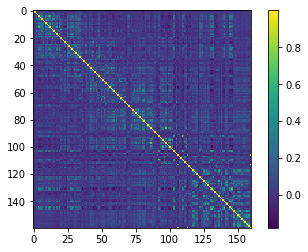

In [19]:
plt.get_cmap = ('inferno', 20)
plt.imshow(tscorr_gsr)
#plt.imshow(tscorr_gsr)
#plt.imshow(tscorr)
plt.colorbar()

### Reorder and plot matrix based on network 

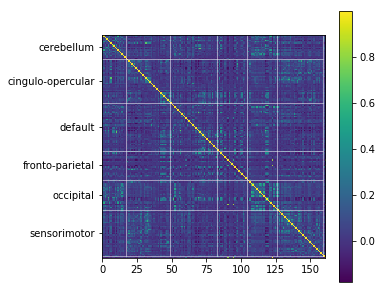

In [20]:
def reorder_corrs(corrmtx,parceldata,labels='network'):
    """
    reorder correlation matrix according to network labels
    """
    idx=np.argsort(parceldata[labels])
    tmp=corrmtx[:,idx]
    return(tmp[idx,:],parceldata.iloc[idx,:])

def plot_reordered_corrs(corrmtx,parceldata,labels='network'):
    """
    plot correlation matrix after reordering
    """

    corr_reord,parceldata_reord=reorder_corrs(corrmtx,parceldata,labels)
    plt.imshow(corr_reord)
    # find breakpoints and plot lines
    breaks=np.array([int(not i) for i in parceldata_reord[labels].values[:-1]==parceldata_reord[labels].values[1:]])
    breaklocs=np.where(breaks)[0]
    for b in breaklocs:
        plt.plot([0,corrmtx.shape[0]-1],[b,b],color='w',linewidth=0.5)
        plt.plot([b,b],[0,corrmtx.shape[0]-1],color='w',linewidth=0.5)
    # find label locations
    # add a zero to help find label locations 
    breaklocs2=np.hstack(([0],breaklocs))
    label_locs=np.mean(np.vstack((breaklocs,breaklocs2[:-1])),0)
    networks=parceldata_reord['network'].values[breaklocs]
    ax=plt.gca()
    ax.set_yticks(label_locs)
    ax.set_yticklabels(networks)
    plt.colorbar()

plt.figure(figsize=(5,5))
plot_reordered_corrs(tscorr_gsr,parceldata)

### Check global mean signal regression 

After feedback from the presentation on Monday, I checked for global mean signal regression using the adapted code from Week7. Interestingly, I found a slight shift for global vs. non-global signal. A follow-up graph was implemented to further define a shift of correlations values. 




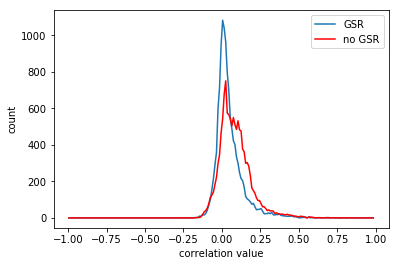

In [88]:
h_gsr=np.histogram(tscorr_gsr[np.triu_indices_from(tscorr_gsr,1)],np.arange(-1,1,0.01))
h_nogsr=np.histogram(tscorr_nogsr[np.triu_indices_from(tscorr_nogsr,1)],np.arange(-1,1,0.01))

plt.plot(np.arange(-0.995,0.995,0.01),h_gsr[0])
plt.plot(np.arange(-0.995,0.995,0.01),h_nogsr[0],color='red')
plt.xlabel('correlation value')
plt.ylabel('count')
plt.legend(['GSR','no GSR'])

### check if no GSR pulles values away from distribution 

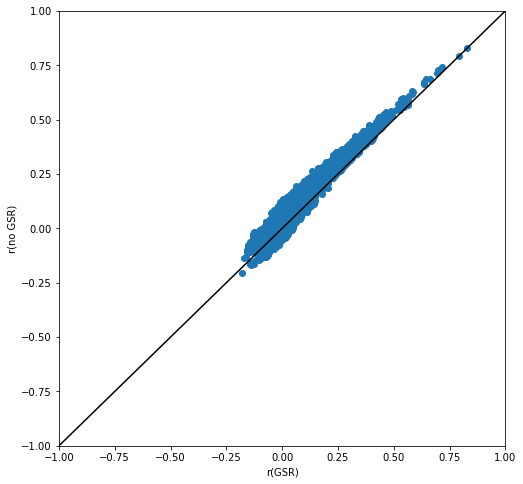

In [89]:
plt.figure(figsize=(8,8))
plt.scatter(tscorr_gsr[np.triu_indices_from(tscorr_gsr,1)],
        tscorr_nogsr[np.triu_indices_from(tscorr_nogsr,1)],)
plt.plot([-1,1],[-1,1],'k-')
plt.axis([-1,1,-1,1])
plt.xlabel('r(GSR)')
plt.ylabel('r(no GSR)')

### Function to get adj matrix

In [24]:
def get_adjmtx(corrmtx,density,verbose=False):
    assert density<=1
    cutoff=scipy.stats.scoreatpercentile(corrmtx[np.triu_indices_from(corrmtx,1)],
                                         100-(100*density))
    if verbose:
        print('cutoff:%0.3f'%cutoff)
    adjmtx=(corrmtx>cutoff).astype('int')
    adjmtx[np.diag_indices_from(adjmtx)]=0
    return(adjmtx)

## Network Spring Embedded Graph for Group1 

cutoff:0.284
Giant component includes 123 out of 160 total nodes
black : nan
red : default
yellow : fronto-parietal
green : cerebellum
blue : cingulo-opercular
orange : occipital
gray : sensorimotor


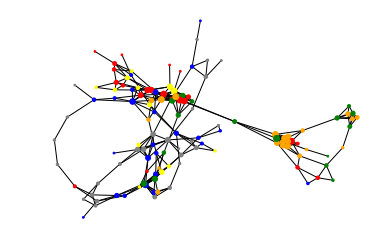

In [25]:
# create spring embedded graph for last group
tscorr=(rGmean_001)

# load label data 
labeldata = pd.read_csv('/Users/home/Desktop/Final_Project_PSYCH267/4networks.csv')

# now generate a graph using NetworkX
adjmtx=get_adjmtx(tscorr,.025,verbose=True)
G=nx.from_numpy_matrix(adjmtx)

# get giant component
comps=[i for i in nx.connected_component_subgraphs(G)]
Gc=comps[0]
print('Giant component includes %d out of %d total nodes'%(len(Gc.nodes),len(G.nodes)))
labeldata_Gc=labeldata.loc[list(Gc.nodes)]


cl={0:'black',1:'red',2:'yellow',3:'green',4:'blue',5:'orange',6:'gray'}
colors=[cl[labeldata['db160'].iloc[i]] for i in Gc.nodes]
degrees=np.array([Gc.degree(i) for i in Gc.nodes])
expansion=3
layout=nx.spring_layout(Gc)
nx.draw_networkx(Gc,pos=layout,with_labels=False,node_color=colors,
              node_size=degrees*expansion)
_=plt.axis('off')
dosendict={0:'nan',1:'default',2:'fronto-parietal',
         3:'cerebellum',4:'cingulo-opercular',
         5:'occipital',6:'sensorimotor'}

for i in dosendict:
    print(cl[i],':',dosendict[i])


## Network Spring Embedded Graph for Group325

cutoff:0.259
Giant component includes 115 out of 160 total nodes
black : nan
red : default
yellow : fronto-parietal
green : cerebellum
blue : cingulo-opercular
orange : occipital
gray : sensorimotor


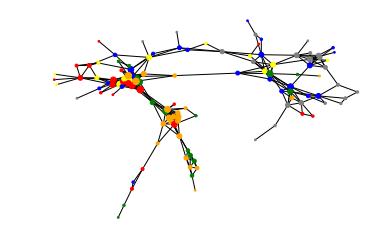

In [27]:
# create spring embedded graph for last group
tscorr=(rGmean_325)

# load label data 
labeldata = pd.read_csv('/Users/home/Desktop/Final_Project_PSYCH267/4networks.csv')

# now generate a graph using NetworkX
adjmtx=get_adjmtx(tscorr,.025,verbose=True)
G=nx.from_numpy_matrix(adjmtx)

# get giant component
comps=[i for i in nx.connected_component_subgraphs(G)]
Gc=comps[0]
print('Giant component includes %d out of %d total nodes'%(len(Gc.nodes),len(G.nodes)))
labeldata_Gc=labeldata.loc[list(Gc.nodes)]


cl={0:'black',1:'red',2:'yellow',3:'green',4:'blue',5:'orange',6:'gray'}
colors=[cl[labeldata['db160'].iloc[i]] for i in Gc.nodes]
degrees=np.array([Gc.degree(i) for i in Gc.nodes])
expansion=3
layout=nx.spring_layout(Gc)
nx.draw_networkx(Gc,pos=layout,with_labels=False,node_color=colors,
              node_size=degrees*expansion)
_=plt.axis('off')
dosendict={0:'nan',1:'default',2:'fronto-parietal',
         3:'cerebellum',4:'cingulo-opercular',
         5:'occipital',6:'sensorimotor'}

for i in dosendict:
    print(cl[i],':',dosendict[i])

## Lobe Spring Embedded Graph for Group1

cutoff:0.284
Giant component includes 123 out of 160 total nodes
black : nan
red : Frontal
yellow : Parietal
green : Temporal
blue : SCGM
orange : Occipital
gray : Insula
pink : Cingulate
purple : Cerebellum


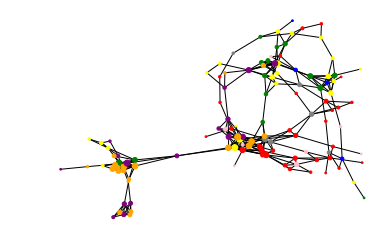

In [28]:
# create lobe spring embedded graph for first group
tscorr=(rGmean_001)

# now generate a graph using NetworkX
adjmtx=get_adjmtx(tscorr,.025,verbose=True)
G=nx.from_numpy_matrix(adjmtx)

# get giant component
comps=[i for i in nx.connected_component_subgraphs(G)]
Gc=comps[0]
print('Giant component includes %d out of %d total nodes'%(len(Gc.nodes),len(G.nodes)))
labeldata_Gc=labeldata.loc[list(Gc.nodes)]


cl={0:'black',1:'red',2:'yellow',3:'green',4:'blue',5:'orange',6:'gray',7:'pink',8:'purple'}
colors=[cl[labeldata['color_lobe'].iloc[i]] for i in Gc.nodes]
degrees=np.array([Gc.degree(i) for i in Gc.nodes])
expansion=3
layout=nx.spring_layout(Gc)
nx.draw_networkx(Gc,pos=layout,with_labels=False,node_color=colors,
              node_size=degrees*expansion)
_=plt.axis('off')
dosendict={0:'nan',1:'Frontal',2:'Parietal',
         3:'Temporal',4:'SCGM',
         5:'Occipital',6:'Insula',7:'Cingulate',8:'Cerebellum'}

for i in dosendict:
    print(cl[i],':',dosendict[i])

## Lobe Spring Embedded Graph for Group325

cutoff:0.259
Giant component includes 115 out of 160 total nodes
black : nan
red : Frontal
yellow : Parietal
green : Temporal
blue : SCGM
orange : Occipital
gray : Insula
pink : Cingulate
purple : Cerebellum


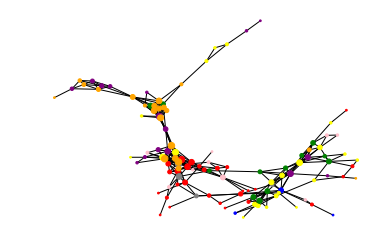

In [29]:
# create lobe spring embedded graph for last group
tscorr=(rGmean_325)

# now generate a graph using NetworkX
adjmtx=get_adjmtx(tscorr,.025,verbose=True)
G=nx.from_numpy_matrix(adjmtx)

# get giant component
comps=[i for i in nx.connected_component_subgraphs(G)]
Gc=comps[0]
print('Giant component includes %d out of %d total nodes'%(len(Gc.nodes),len(G.nodes)))
labeldata_Gc=labeldata.loc[list(Gc.nodes)]


cl={0:'black',1:'red',2:'yellow',3:'green',4:'blue',5:'orange',6:'gray',7:'pink',8:'purple'}
colors=[cl[labeldata['color_lobe'].iloc[i]] for i in Gc.nodes]
degrees=np.array([Gc.degree(i) for i in Gc.nodes])
expansion=3
layout=nx.spring_layout(Gc)
nx.draw_networkx(Gc,pos=layout,with_labels=False,node_color=colors,
              node_size=degrees*expansion)
_=plt.axis('off')
dosendict={0:'nan',1:'Frontal',2:'Parietal',
         3:'Temporal',4:'SCGM',
         5:'Occipital',6:'Insula',7:'Cingulate',8:'Cerebellum'}

for i in dosendict:
    print(cl[i],':',dosendict[i])

In [31]:
comps=sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)

In [32]:
Gc=comps[0]
print('Giant component includes %d out of %d total nodes'%(len(Gc.nodes),len(G.nodes)))

Giant component includes 115 out of 160 total nodes


### Attempted to iterate through networkx but couldn't extract average cluster or path length via for loops from networkx

In [225]:
class MyClass(object):
    def __init__(self, number):
        self.number = number

my_objects = []

#for i in :
#    my_objects.append(MyClass(i))      

dfs=('01','02','03','04','05','06','07','08','09','010','011','012','013','014','015','016','017','018','019','020','021','022','023','024','025','026','027','028','029','030','031','032','033','034','035','036','037','038','039','040','041','042','043','044','045','046','047','048','049','050','051','052','053','054','055','056','057','058','059','060','061','062','063','064','065','066','067','068','069','070','071','072','073','074','075','076','077','078','079','080','081','082','083','084','085','086','087','088','089','090','091','092','093','094','095','096','097','098','099','100','101','102','103','104','105','106','107','108','109','110','111','112','113','114','115','116','117','118','119','120','121','122','123','124','125','126','127','128','129','130','131','132','133','134','135','136','137','138','139','140','141','142','143','144','145','146','147','148','149','150','151','152','153','154','155','156','157','158','159','160','161','162','163','164','165','166','167','168','169','170','171','172','173','174','175','176','177','178','179','180','181','182','183','184','185','186','187','188','189','190','191','192','193','194','195','196','197','198','199','200','201','202','203','204','205','206','207','208','209','210','211','212','213','214','215','216','217','218','219','220','221','222','223','224','225','226','227','228','229','230','231','232','233','234','235','236','237','238','239','240','241','242','243','244','245','246','247','248','249','250','251','252','253','254','255','256','257','258','259','260','261','262','263','264','265','266','267','268','269','270','271','272','273','274','275','276','277','278','279','280','281','282','283','284','285','286','287','288','289','290','291','292','293','294','295','296','297','298','299','300','301','302','303','304','305','306','307','308','309','310','311','312','313','314','315','316','317','318','319','320','321','322','323','324','325')
my_objects = [rGmean_001 ,rGmean_002 ,rGmean_003 ,rGmean_004 ,rGmean_005 ,rGmean_006 ,rGmean_007 ,rGmean_008 ,rGmean_009 ,rGmean_010 ,rGmean_011 ,rGmean_012 ,rGmean_013 ,rGmean_014 ,rGmean_015 ,rGmean_016 ,rGmean_017 ,rGmean_018 ,rGmean_019 ,rGmean_020 ,rGmean_021 ,rGmean_022 ,rGmean_023 ,rGmean_024 ,rGmean_025 ,rGmean_026 ,rGmean_027 ,rGmean_028 ,rGmean_029 ,rGmean_030 ,rGmean_031 ,rGmean_032 ,rGmean_033 ,rGmean_034 ,rGmean_035 ,rGmean_036 ,rGmean_037 ,rGmean_038 ,rGmean_039 ,rGmean_040 ,rGmean_041 ,rGmean_042 ,rGmean_043 ,rGmean_044 ,rGmean_045 ,rGmean_046 ,rGmean_047 ,rGmean_048 ,rGmean_049 ,rGmean_050 ,rGmean_051 ,rGmean_052 ,rGmean_053 ,rGmean_054 ,rGmean_055 ,rGmean_056 ,rGmean_057 ,rGmean_058 ,rGmean_059 ,rGmean_060 ,rGmean_061 ,rGmean_062 ,rGmean_063 ,rGmean_064 ,rGmean_065 ,rGmean_066 ,rGmean_067 ,rGmean_068 ,rGmean_069 ,rGmean_070 ,rGmean_071 ,rGmean_072 ,rGmean_073 ,rGmean_074 ,rGmean_075 ,rGmean_076 ,rGmean_077 ,rGmean_078 ,rGmean_079 ,rGmean_080 ,rGmean_081 ,rGmean_082 ,rGmean_083 ,rGmean_084 ,rGmean_085 ,rGmean_086 ,rGmean_087 ,rGmean_088 ,rGmean_089 ,rGmean_090 ,rGmean_091 ,rGmean_092 ,rGmean_093 ,rGmean_094 ,rGmean_095 ,rGmean_096 ,rGmean_097 ,rGmean_098 ,rGmean_099 ,rGmean_100 ,rGmean_101 ,rGmean_102 ,rGmean_103 ,rGmean_104 ,rGmean_105 ,rGmean_106 ,rGmean_107 ,rGmean_108 ,rGmean_109 ,rGmean_110 ,rGmean_111 ,rGmean_112 ,rGmean_113 ,rGmean_114 ,rGmean_115 ,rGmean_116 ,rGmean_117 ,rGmean_118 ,rGmean_119 ,rGmean_120 ,rGmean_121 ,rGmean_122 ,rGmean_123 ,rGmean_124 ,rGmean_125 ,rGmean_126 ,rGmean_127 ,rGmean_128 ,rGmean_129 ,rGmean_130 ,rGmean_131 ,rGmean_132 ,rGmean_133 ,rGmean_134 ,rGmean_135 ,rGmean_136 ,rGmean_137 ,rGmean_138 ,rGmean_139 ,rGmean_140 ,rGmean_141 ,rGmean_142 ,rGmean_143 ,rGmean_144 ,rGmean_145 ,rGmean_146 ,rGmean_147 ,rGmean_148 ,rGmean_149 ,rGmean_150 ,rGmean_151 ,rGmean_152 ,rGmean_153 ,rGmean_154 ,rGmean_155 ,rGmean_156 ,rGmean_157 ,rGmean_158 ,rGmean_159 ,rGmean_160 ,rGmean_161 ,rGmean_162 ,rGmean_163 ,rGmean_164 ,rGmean_165 ,rGmean_166 ,rGmean_167 ,rGmean_168 ,rGmean_169 ,rGmean_170 ,rGmean_171 ,rGmean_172 ,rGmean_173 ,rGmean_174 ,rGmean_175 ,rGmean_176 ,rGmean_177 ,rGmean_178 ,rGmean_179 ,rGmean_180 ,rGmean_181 ,rGmean_182 ,rGmean_183 ,rGmean_184 ,rGmean_185 ,rGmean_186 ,rGmean_187 ,rGmean_188 ,rGmean_189 ,rGmean_190 ,rGmean_191 ,rGmean_192 ,rGmean_193 ,rGmean_194 ,rGmean_195 ,rGmean_196 ,rGmean_197 ,rGmean_198 ,rGmean_199 ,rGmean_200 ,rGmean_201 ,rGmean_202 ,rGmean_203 ,rGmean_204 ,rGmean_205 ,rGmean_206 ,rGmean_207 ,rGmean_208 ,rGmean_209 ,rGmean_210 ,rGmean_211 ,rGmean_212 ,rGmean_213 ,rGmean_214 ,rGmean_215 ,rGmean_216 ,rGmean_217 ,rGmean_218 ,rGmean_219 ,rGmean_220 ,rGmean_221 ,rGmean_222 ,rGmean_223 ,rGmean_224 ,rGmean_225 ,rGmean_226 ,rGmean_227 ,rGmean_228 ,rGmean_229 ,rGmean_230 ,rGmean_231 ,rGmean_232 ,rGmean_233 ,rGmean_234 ,rGmean_235 ,rGmean_236 ,rGmean_237 ,rGmean_238 ,rGmean_239 ,rGmean_240 ,rGmean_241 ,rGmean_242 ,rGmean_243 ,rGmean_244 ,rGmean_245 ,rGmean_246 ,rGmean_247 ,rGmean_248 ,rGmean_249 ,rGmean_250 ,rGmean_251 ,rGmean_252 ,rGmean_253 ,rGmean_254 ,rGmean_255 ,rGmean_256 ,rGmean_257 ,rGmean_258 ,rGmean_259 ,rGmean_260 ,rGmean_261 ,rGmean_262 ,rGmean_263 ,rGmean_264 ,rGmean_265 ,rGmean_266 ,rGmean_267 ,rGmean_268 ,rGmean_269 ,rGmean_270 ,rGmean_271 ,rGmean_272 ,rGmean_273 ,rGmean_274 ,rGmean_275 ,rGmean_276 ,rGmean_277 ,rGmean_278 ,rGmean_279 ,rGmean_280 ,rGmean_281 ,rGmean_282 ,rGmean_283 ,rGmean_284 ,rGmean_285 ,rGmean_286 ,rGmean_287 ,rGmean_288 ,rGmean_289 ,rGmean_290 ,rGmean_291 ,rGmean_292 ,rGmean_293 ,rGmean_294 ,rGmean_295 ,rGmean_296 ,rGmean_297 ,rGmean_298 ,rGmean_299 ,rGmean_300 ,rGmean_301 ,rGmean_302 ,rGmean_303 ,rGmean_304 ,rGmean_305 ,rGmean_306 ,rGmean_307 ,rGmean_308 ,rGmean_309 ,rGmean_310 ,rGmean_311 ,rGmean_312 ,rGmean_313 ,rGmean_314 ,rGmean_315 ,rGmean_316 ,rGmean_317 ,rGmean_318 ,rGmean_319, rGmean_320 ,rGmean_321 ,rGmean_322 ,rGmean_323 ,rGmean_324 ,rGmean_325]
list_of_groups = dict(zip(dfs,my_objects))






list_of_adjmtx={}
for df in dfs:
    list_of_adjmtx[df] = get_adjmtx(list_of_groups[df],.025,verbose=True)

list_of_componets={}
for df in dfs:
    list_of_componets[df] = G = nx.from_numpy_matrix(list_of_adjmtx[df])

list_of_subgraph={}
for df in dfs:
    list_of_subgraph[df] = [i for i in nx.connected_component_subgraphs(list_of_componets[df])]   
    
list_of_zerocomp={}
for df in dfs:
    list_of_zerocomp[df] = [list_of_subgraph[df][0]]

clustering=[]
for df in dfs:
    clustering.append((nx.average_clustering(list_of_zerocomp[df])))
    

    
    

### Create adj matrix for all groups 

In [33]:
adjrGmean_001=get_adjmtx(rGmean_001,.025,verbose=True)
adjrGmean_002=get_adjmtx(rGmean_002,.025,verbose=True)
adjrGmean_003=get_adjmtx(rGmean_003,.025,verbose=True)
adjrGmean_004=get_adjmtx(rGmean_004,.025,verbose=True)
adjrGmean_005=get_adjmtx(rGmean_005,.025,verbose=True)
adjrGmean_006=get_adjmtx(rGmean_006,.025,verbose=True)
adjrGmean_007=get_adjmtx(rGmean_007,.025,verbose=True)
adjrGmean_008=get_adjmtx(rGmean_008,.025,verbose=True)
adjrGmean_009=get_adjmtx(rGmean_009,.025,verbose=True)
adjrGmean_010=get_adjmtx(rGmean_010,.025,verbose=True)
adjrGmean_011=get_adjmtx(rGmean_011,.025,verbose=True)
adjrGmean_012=get_adjmtx(rGmean_012,.025,verbose=True)
adjrGmean_013=get_adjmtx(rGmean_013,.025,verbose=True)
adjrGmean_014=get_adjmtx(rGmean_014,.025,verbose=True)
adjrGmean_015=get_adjmtx(rGmean_015,.025,verbose=True)
adjrGmean_016=get_adjmtx(rGmean_016,.025,verbose=True)
adjrGmean_017=get_adjmtx(rGmean_017,.025,verbose=True)
adjrGmean_018=get_adjmtx(rGmean_018,.025,verbose=True)
adjrGmean_019=get_adjmtx(rGmean_019,.025,verbose=True)
adjrGmean_020=get_adjmtx(rGmean_020,.025,verbose=True)
adjrGmean_021=get_adjmtx(rGmean_021,.025,verbose=True)
adjrGmean_022=get_adjmtx(rGmean_022,.025,verbose=True)
adjrGmean_023=get_adjmtx(rGmean_023,.025,verbose=True)
adjrGmean_024=get_adjmtx(rGmean_024,.025,verbose=True)
adjrGmean_025=get_adjmtx(rGmean_025,.025,verbose=True)
adjrGmean_026=get_adjmtx(rGmean_026,.025,verbose=True)
adjrGmean_027=get_adjmtx(rGmean_027,.025,verbose=True)
adjrGmean_028=get_adjmtx(rGmean_028,.025,verbose=True)
adjrGmean_029=get_adjmtx(rGmean_029,.025,verbose=True)
adjrGmean_030=get_adjmtx(rGmean_030,.025,verbose=True)
adjrGmean_031=get_adjmtx(rGmean_031,.025,verbose=True)
adjrGmean_032=get_adjmtx(rGmean_032,.025,verbose=True)
adjrGmean_033=get_adjmtx(rGmean_033,.025,verbose=True)
adjrGmean_034=get_adjmtx(rGmean_034,.025,verbose=True)
adjrGmean_035=get_adjmtx(rGmean_035,.025,verbose=True)
adjrGmean_036=get_adjmtx(rGmean_036,.025,verbose=True)
adjrGmean_037=get_adjmtx(rGmean_037,.025,verbose=True)
adjrGmean_038=get_adjmtx(rGmean_038,.025,verbose=True)
adjrGmean_039=get_adjmtx(rGmean_039,.025,verbose=True)
adjrGmean_040=get_adjmtx(rGmean_040,.025,verbose=True)
adjrGmean_041=get_adjmtx(rGmean_041,.025,verbose=True)
adjrGmean_042=get_adjmtx(rGmean_042,.025,verbose=True)
adjrGmean_043=get_adjmtx(rGmean_043,.025,verbose=True)
adjrGmean_044=get_adjmtx(rGmean_044,.025,verbose=True)
adjrGmean_045=get_adjmtx(rGmean_045,.025,verbose=True)
adjrGmean_046=get_adjmtx(rGmean_046,.025,verbose=True)
adjrGmean_047=get_adjmtx(rGmean_047,.025,verbose=True)
adjrGmean_048=get_adjmtx(rGmean_048,.025,verbose=True)
adjrGmean_049=get_adjmtx(rGmean_049,.025,verbose=True)
adjrGmean_050=get_adjmtx(rGmean_050,.025,verbose=True)
adjrGmean_051=get_adjmtx(rGmean_051,.025,verbose=True)
adjrGmean_052=get_adjmtx(rGmean_052,.025,verbose=True)
adjrGmean_053=get_adjmtx(rGmean_053,.025,verbose=True)
adjrGmean_054=get_adjmtx(rGmean_054,.025,verbose=True)
adjrGmean_055=get_adjmtx(rGmean_055,.025,verbose=True)
adjrGmean_056=get_adjmtx(rGmean_056,.025,verbose=True)
adjrGmean_057=get_adjmtx(rGmean_057,.025,verbose=True)
adjrGmean_058=get_adjmtx(rGmean_058,.025,verbose=True)
adjrGmean_059=get_adjmtx(rGmean_059,.025,verbose=True)
adjrGmean_060=get_adjmtx(rGmean_060,.025,verbose=True)
adjrGmean_061=get_adjmtx(rGmean_061,.025,verbose=True)
adjrGmean_062=get_adjmtx(rGmean_062,.025,verbose=True)
adjrGmean_063=get_adjmtx(rGmean_063,.025,verbose=True)
adjrGmean_064=get_adjmtx(rGmean_064,.025,verbose=True)
adjrGmean_065=get_adjmtx(rGmean_065,.025,verbose=True)
adjrGmean_066=get_adjmtx(rGmean_066,.025,verbose=True)
adjrGmean_067=get_adjmtx(rGmean_067,.025,verbose=True)
adjrGmean_068=get_adjmtx(rGmean_068,.025,verbose=True)
adjrGmean_069=get_adjmtx(rGmean_069,.025,verbose=True)
adjrGmean_070=get_adjmtx(rGmean_070,.025,verbose=True)
adjrGmean_071=get_adjmtx(rGmean_071,.025,verbose=True)
adjrGmean_072=get_adjmtx(rGmean_072,.025,verbose=True)
adjrGmean_073=get_adjmtx(rGmean_073,.025,verbose=True)
adjrGmean_074=get_adjmtx(rGmean_074,.025,verbose=True)
adjrGmean_075=get_adjmtx(rGmean_075,.025,verbose=True)
adjrGmean_076=get_adjmtx(rGmean_076,.025,verbose=True)
adjrGmean_077=get_adjmtx(rGmean_077,.025,verbose=True)
adjrGmean_078=get_adjmtx(rGmean_078,.025,verbose=True)
adjrGmean_079=get_adjmtx(rGmean_079,.025,verbose=True)
adjrGmean_080=get_adjmtx(rGmean_080,.025,verbose=True)
adjrGmean_081=get_adjmtx(rGmean_081,.025,verbose=True)
adjrGmean_082=get_adjmtx(rGmean_082,.025,verbose=True)
adjrGmean_083=get_adjmtx(rGmean_083,.025,verbose=True)
adjrGmean_084=get_adjmtx(rGmean_084,.025,verbose=True)
adjrGmean_085=get_adjmtx(rGmean_085,.025,verbose=True)
adjrGmean_086=get_adjmtx(rGmean_086,.025,verbose=True)
adjrGmean_087=get_adjmtx(rGmean_087,.025,verbose=True)
adjrGmean_088=get_adjmtx(rGmean_088,.025,verbose=True)
adjrGmean_089=get_adjmtx(rGmean_089,.025,verbose=True)
adjrGmean_090=get_adjmtx(rGmean_090,.025,verbose=True)
adjrGmean_091=get_adjmtx(rGmean_091,.025,verbose=True)
adjrGmean_092=get_adjmtx(rGmean_092,.025,verbose=True)
adjrGmean_093=get_adjmtx(rGmean_093,.025,verbose=True)
adjrGmean_094=get_adjmtx(rGmean_094,.025,verbose=True)
adjrGmean_095=get_adjmtx(rGmean_095,.025,verbose=True)
adjrGmean_096=get_adjmtx(rGmean_096,.025,verbose=True)
adjrGmean_097=get_adjmtx(rGmean_097,.025,verbose=True)
adjrGmean_098=get_adjmtx(rGmean_098,.025,verbose=True)
adjrGmean_099=get_adjmtx(rGmean_099,.025,verbose=True)
adjrGmean_100=get_adjmtx(rGmean_100,.025,verbose=True)
adjrGmean_101=get_adjmtx(rGmean_101,.025,verbose=True)
adjrGmean_102=get_adjmtx(rGmean_102,.025,verbose=True)
adjrGmean_103=get_adjmtx(rGmean_103,.025,verbose=True)
adjrGmean_104=get_adjmtx(rGmean_104,.025,verbose=True)
adjrGmean_105=get_adjmtx(rGmean_105,.025,verbose=True)
adjrGmean_106=get_adjmtx(rGmean_106,.025,verbose=True)
adjrGmean_107=get_adjmtx(rGmean_107,.025,verbose=True)
adjrGmean_108=get_adjmtx(rGmean_108,.025,verbose=True)
adjrGmean_109=get_adjmtx(rGmean_109,.025,verbose=True)
adjrGmean_110=get_adjmtx(rGmean_110,.025,verbose=True)
adjrGmean_111=get_adjmtx(rGmean_111,.025,verbose=True)
adjrGmean_112=get_adjmtx(rGmean_112,.025,verbose=True)
adjrGmean_113=get_adjmtx(rGmean_113,.025,verbose=True)
adjrGmean_114=get_adjmtx(rGmean_114,.025,verbose=True)
adjrGmean_115=get_adjmtx(rGmean_115,.025,verbose=True)
adjrGmean_116=get_adjmtx(rGmean_116,.025,verbose=True)
adjrGmean_117=get_adjmtx(rGmean_117,.025,verbose=True)
adjrGmean_118=get_adjmtx(rGmean_118,.025,verbose=True)
adjrGmean_119=get_adjmtx(rGmean_119,.025,verbose=True)
adjrGmean_120=get_adjmtx(rGmean_120,.025,verbose=True)
adjrGmean_121=get_adjmtx(rGmean_121,.025,verbose=True)
adjrGmean_122=get_adjmtx(rGmean_122,.025,verbose=True)
adjrGmean_123=get_adjmtx(rGmean_123,.025,verbose=True)
adjrGmean_124=get_adjmtx(rGmean_124,.025,verbose=True)
adjrGmean_125=get_adjmtx(rGmean_125,.025,verbose=True)
adjrGmean_126=get_adjmtx(rGmean_126,.025,verbose=True)
adjrGmean_127=get_adjmtx(rGmean_127,.025,verbose=True)
adjrGmean_128=get_adjmtx(rGmean_128,.025,verbose=True)
adjrGmean_129=get_adjmtx(rGmean_129,.025,verbose=True)
adjrGmean_130=get_adjmtx(rGmean_130,.025,verbose=True)
adjrGmean_131=get_adjmtx(rGmean_131,.025,verbose=True)
adjrGmean_132=get_adjmtx(rGmean_132,.025,verbose=True)
adjrGmean_133=get_adjmtx(rGmean_133,.025,verbose=True)
adjrGmean_134=get_adjmtx(rGmean_134,.025,verbose=True)
adjrGmean_135=get_adjmtx(rGmean_135,.025,verbose=True)
adjrGmean_136=get_adjmtx(rGmean_136,.025,verbose=True)
adjrGmean_137=get_adjmtx(rGmean_137,.025,verbose=True)
adjrGmean_138=get_adjmtx(rGmean_138,.025,verbose=True)
adjrGmean_139=get_adjmtx(rGmean_139,.025,verbose=True)
adjrGmean_140=get_adjmtx(rGmean_140,.025,verbose=True)
adjrGmean_141=get_adjmtx(rGmean_141,.025,verbose=True)
adjrGmean_142=get_adjmtx(rGmean_142,.025,verbose=True)
adjrGmean_143=get_adjmtx(rGmean_143,.025,verbose=True)
adjrGmean_144=get_adjmtx(rGmean_144,.025,verbose=True)
adjrGmean_145=get_adjmtx(rGmean_145,.025,verbose=True)
adjrGmean_146=get_adjmtx(rGmean_146,.025,verbose=True)
adjrGmean_147=get_adjmtx(rGmean_147,.025,verbose=True)
adjrGmean_148=get_adjmtx(rGmean_148,.025,verbose=True)
adjrGmean_149=get_adjmtx(rGmean_149,.025,verbose=True)
adjrGmean_150=get_adjmtx(rGmean_150,.025,verbose=True)
adjrGmean_151=get_adjmtx(rGmean_151,.025,verbose=True)
adjrGmean_152=get_adjmtx(rGmean_152,.025,verbose=True)
adjrGmean_153=get_adjmtx(rGmean_153,.025,verbose=True)
adjrGmean_154=get_adjmtx(rGmean_154,.025,verbose=True)
adjrGmean_155=get_adjmtx(rGmean_155,.025,verbose=True)
adjrGmean_156=get_adjmtx(rGmean_156,.025,verbose=True)
adjrGmean_157=get_adjmtx(rGmean_157,.025,verbose=True)
adjrGmean_158=get_adjmtx(rGmean_158,.025,verbose=True)
adjrGmean_159=get_adjmtx(rGmean_159,.025,verbose=True)
adjrGmean_160=get_adjmtx(rGmean_160,.025,verbose=True)
adjrGmean_161=get_adjmtx(rGmean_161,.025,verbose=True)
adjrGmean_162=get_adjmtx(rGmean_162,.025,verbose=True)
adjrGmean_163=get_adjmtx(rGmean_163,.025,verbose=True)
adjrGmean_164=get_adjmtx(rGmean_164,.025,verbose=True)
adjrGmean_165=get_adjmtx(rGmean_165,.025,verbose=True)
adjrGmean_166=get_adjmtx(rGmean_166,.025,verbose=True)
adjrGmean_167=get_adjmtx(rGmean_167,.025,verbose=True)
adjrGmean_168=get_adjmtx(rGmean_168,.025,verbose=True)
adjrGmean_169=get_adjmtx(rGmean_169,.025,verbose=True)
adjrGmean_170=get_adjmtx(rGmean_170,.025,verbose=True)
adjrGmean_171=get_adjmtx(rGmean_171,.025,verbose=True)
adjrGmean_172=get_adjmtx(rGmean_172,.025,verbose=True)
adjrGmean_173=get_adjmtx(rGmean_173,.025,verbose=True)
adjrGmean_174=get_adjmtx(rGmean_174,.025,verbose=True)
adjrGmean_175=get_adjmtx(rGmean_175,.025,verbose=True)
adjrGmean_176=get_adjmtx(rGmean_176,.025,verbose=True)
adjrGmean_177=get_adjmtx(rGmean_177,.025,verbose=True)
adjrGmean_178=get_adjmtx(rGmean_178,.025,verbose=True)
adjrGmean_179=get_adjmtx(rGmean_179,.025,verbose=True)
adjrGmean_180=get_adjmtx(rGmean_180,.025,verbose=True)
adjrGmean_181=get_adjmtx(rGmean_181,.025,verbose=True)
adjrGmean_182=get_adjmtx(rGmean_182,.025,verbose=True)
adjrGmean_183=get_adjmtx(rGmean_183,.025,verbose=True)
adjrGmean_184=get_adjmtx(rGmean_184,.025,verbose=True)
adjrGmean_185=get_adjmtx(rGmean_185,.025,verbose=True)
adjrGmean_186=get_adjmtx(rGmean_186,.025,verbose=True)
adjrGmean_187=get_adjmtx(rGmean_187,.025,verbose=True)
adjrGmean_188=get_adjmtx(rGmean_188,.025,verbose=True)
adjrGmean_189=get_adjmtx(rGmean_189,.025,verbose=True)
adjrGmean_190=get_adjmtx(rGmean_190,.025,verbose=True)
adjrGmean_191=get_adjmtx(rGmean_191,.025,verbose=True)
adjrGmean_192=get_adjmtx(rGmean_192,.025,verbose=True)
adjrGmean_193=get_adjmtx(rGmean_193,.025,verbose=True)
adjrGmean_194=get_adjmtx(rGmean_194,.025,verbose=True)
adjrGmean_195=get_adjmtx(rGmean_195,.025,verbose=True)
adjrGmean_196=get_adjmtx(rGmean_196,.025,verbose=True)
adjrGmean_197=get_adjmtx(rGmean_197,.025,verbose=True)
adjrGmean_198=get_adjmtx(rGmean_198,.025,verbose=True)
adjrGmean_199=get_adjmtx(rGmean_199,.025,verbose=True)
adjrGmean_200=get_adjmtx(rGmean_200,.025,verbose=True)
adjrGmean_201=get_adjmtx(rGmean_201,.025,verbose=True)
adjrGmean_202=get_adjmtx(rGmean_202,.025,verbose=True)
adjrGmean_203=get_adjmtx(rGmean_203,.025,verbose=True)
adjrGmean_204=get_adjmtx(rGmean_204,.025,verbose=True)
adjrGmean_205=get_adjmtx(rGmean_205,.025,verbose=True)
adjrGmean_206=get_adjmtx(rGmean_206,.025,verbose=True)
adjrGmean_207=get_adjmtx(rGmean_207,.025,verbose=True)
adjrGmean_208=get_adjmtx(rGmean_208,.025,verbose=True)
adjrGmean_209=get_adjmtx(rGmean_209,.025,verbose=True)
adjrGmean_210=get_adjmtx(rGmean_210,.025,verbose=True)
adjrGmean_211=get_adjmtx(rGmean_211,.025,verbose=True)
adjrGmean_212=get_adjmtx(rGmean_212,.025,verbose=True)
adjrGmean_213=get_adjmtx(rGmean_213,.025,verbose=True)
adjrGmean_214=get_adjmtx(rGmean_214,.025,verbose=True)
adjrGmean_215=get_adjmtx(rGmean_215,.025,verbose=True)
adjrGmean_216=get_adjmtx(rGmean_216,.025,verbose=True)
adjrGmean_217=get_adjmtx(rGmean_217,.025,verbose=True)
adjrGmean_218=get_adjmtx(rGmean_218,.025,verbose=True)
adjrGmean_219=get_adjmtx(rGmean_219,.025,verbose=True)
adjrGmean_220=get_adjmtx(rGmean_220,.025,verbose=True)
adjrGmean_221=get_adjmtx(rGmean_221,.025,verbose=True)
adjrGmean_222=get_adjmtx(rGmean_222,.025,verbose=True)
adjrGmean_223=get_adjmtx(rGmean_223,.025,verbose=True)
adjrGmean_224=get_adjmtx(rGmean_224,.025,verbose=True)
adjrGmean_225=get_adjmtx(rGmean_225,.025,verbose=True)
adjrGmean_226=get_adjmtx(rGmean_226,.025,verbose=True)
adjrGmean_227=get_adjmtx(rGmean_227,.025,verbose=True)
adjrGmean_228=get_adjmtx(rGmean_228,.025,verbose=True)
adjrGmean_229=get_adjmtx(rGmean_229,.025,verbose=True)
adjrGmean_230=get_adjmtx(rGmean_230,.025,verbose=True)
adjrGmean_231=get_adjmtx(rGmean_231,.025,verbose=True)
adjrGmean_232=get_adjmtx(rGmean_232,.025,verbose=True)
adjrGmean_233=get_adjmtx(rGmean_233,.025,verbose=True)
adjrGmean_234=get_adjmtx(rGmean_234,.025,verbose=True)
adjrGmean_235=get_adjmtx(rGmean_235,.025,verbose=True)
adjrGmean_236=get_adjmtx(rGmean_236,.025,verbose=True)
adjrGmean_237=get_adjmtx(rGmean_237,.025,verbose=True)
adjrGmean_238=get_adjmtx(rGmean_238,.025,verbose=True)
adjrGmean_239=get_adjmtx(rGmean_239,.025,verbose=True)
adjrGmean_240=get_adjmtx(rGmean_240,.025,verbose=True)
adjrGmean_241=get_adjmtx(rGmean_241,.025,verbose=True)
adjrGmean_242=get_adjmtx(rGmean_242,.025,verbose=True)
adjrGmean_243=get_adjmtx(rGmean_243,.025,verbose=True)
adjrGmean_244=get_adjmtx(rGmean_244,.025,verbose=True)
adjrGmean_245=get_adjmtx(rGmean_245,.025,verbose=True)
adjrGmean_246=get_adjmtx(rGmean_246,.025,verbose=True)
adjrGmean_247=get_adjmtx(rGmean_247,.025,verbose=True)
adjrGmean_248=get_adjmtx(rGmean_248,.025,verbose=True)
adjrGmean_249=get_adjmtx(rGmean_249,.025,verbose=True)
adjrGmean_250=get_adjmtx(rGmean_250,.025,verbose=True)
adjrGmean_251=get_adjmtx(rGmean_251,.025,verbose=True)
adjrGmean_252=get_adjmtx(rGmean_252,.025,verbose=True)
adjrGmean_253=get_adjmtx(rGmean_253,.025,verbose=True)
adjrGmean_254=get_adjmtx(rGmean_254,.025,verbose=True)
adjrGmean_255=get_adjmtx(rGmean_255,.025,verbose=True)
adjrGmean_256=get_adjmtx(rGmean_256,.025,verbose=True)
adjrGmean_257=get_adjmtx(rGmean_257,.025,verbose=True)
adjrGmean_258=get_adjmtx(rGmean_258,.025,verbose=True)
adjrGmean_259=get_adjmtx(rGmean_259,.025,verbose=True)
adjrGmean_260=get_adjmtx(rGmean_260,.025,verbose=True)
adjrGmean_261=get_adjmtx(rGmean_261,.025,verbose=True)
adjrGmean_262=get_adjmtx(rGmean_262,.025,verbose=True)
adjrGmean_263=get_adjmtx(rGmean_263,.025,verbose=True)
adjrGmean_264=get_adjmtx(rGmean_264,.025,verbose=True)
adjrGmean_265=get_adjmtx(rGmean_265,.025,verbose=True)
adjrGmean_266=get_adjmtx(rGmean_266,.025,verbose=True)
adjrGmean_267=get_adjmtx(rGmean_267,.025,verbose=True)
adjrGmean_268=get_adjmtx(rGmean_268,.025,verbose=True)
adjrGmean_269=get_adjmtx(rGmean_269,.025,verbose=True)
adjrGmean_270=get_adjmtx(rGmean_270,.025,verbose=True)
adjrGmean_271=get_adjmtx(rGmean_271,.025,verbose=True)
adjrGmean_272=get_adjmtx(rGmean_272,.025,verbose=True)
adjrGmean_273=get_adjmtx(rGmean_273,.025,verbose=True)
adjrGmean_274=get_adjmtx(rGmean_274,.025,verbose=True)
adjrGmean_275=get_adjmtx(rGmean_275,.025,verbose=True)
adjrGmean_276=get_adjmtx(rGmean_276,.025,verbose=True)
adjrGmean_277=get_adjmtx(rGmean_277,.025,verbose=True)
adjrGmean_278=get_adjmtx(rGmean_278,.025,verbose=True)
adjrGmean_279=get_adjmtx(rGmean_279,.025,verbose=True)
adjrGmean_280=get_adjmtx(rGmean_280,.025,verbose=True)
adjrGmean_281=get_adjmtx(rGmean_281,.025,verbose=True)
adjrGmean_282=get_adjmtx(rGmean_282,.025,verbose=True)
adjrGmean_283=get_adjmtx(rGmean_283,.025,verbose=True)
adjrGmean_284=get_adjmtx(rGmean_284,.025,verbose=True)
adjrGmean_285=get_adjmtx(rGmean_285,.025,verbose=True)
adjrGmean_286=get_adjmtx(rGmean_286,.025,verbose=True)
adjrGmean_287=get_adjmtx(rGmean_287,.025,verbose=True)
adjrGmean_288=get_adjmtx(rGmean_288,.025,verbose=True)
adjrGmean_289=get_adjmtx(rGmean_289,.025,verbose=True)
adjrGmean_290=get_adjmtx(rGmean_290,.025,verbose=True)
adjrGmean_291=get_adjmtx(rGmean_291,.025,verbose=True)
adjrGmean_292=get_adjmtx(rGmean_292,.025,verbose=True)
adjrGmean_293=get_adjmtx(rGmean_293,.025,verbose=True)
adjrGmean_294=get_adjmtx(rGmean_294,.025,verbose=True)
adjrGmean_295=get_adjmtx(rGmean_295,.025,verbose=True)
adjrGmean_296=get_adjmtx(rGmean_296,.025,verbose=True)
adjrGmean_297=get_adjmtx(rGmean_297,.025,verbose=True)
adjrGmean_298=get_adjmtx(rGmean_298,.025,verbose=True)
adjrGmean_299=get_adjmtx(rGmean_299,.025,verbose=True)
adjrGmean_300=get_adjmtx(rGmean_300,.025,verbose=True)
adjrGmean_301=get_adjmtx(rGmean_301,.025,verbose=True)
adjrGmean_302=get_adjmtx(rGmean_302,.025,verbose=True)
adjrGmean_303=get_adjmtx(rGmean_303,.025,verbose=True)
adjrGmean_304=get_adjmtx(rGmean_304,.025,verbose=True)
adjrGmean_305=get_adjmtx(rGmean_305,.025,verbose=True)
adjrGmean_306=get_adjmtx(rGmean_306,.025,verbose=True)
adjrGmean_307=get_adjmtx(rGmean_307,.025,verbose=True)
adjrGmean_308=get_adjmtx(rGmean_308,.025,verbose=True)
adjrGmean_309=get_adjmtx(rGmean_309,.025,verbose=True)
adjrGmean_310=get_adjmtx(rGmean_310,.025,verbose=True)
adjrGmean_311=get_adjmtx(rGmean_311,.025,verbose=True)
adjrGmean_312=get_adjmtx(rGmean_312,.025,verbose=True)
adjrGmean_313=get_adjmtx(rGmean_313,.025,verbose=True)
adjrGmean_314=get_adjmtx(rGmean_314,.025,verbose=True)
adjrGmean_315=get_adjmtx(rGmean_315,.025,verbose=True)
adjrGmean_316=get_adjmtx(rGmean_316,.025,verbose=True)
adjrGmean_317=get_adjmtx(rGmean_317,.025,verbose=True)
adjrGmean_318=get_adjmtx(rGmean_318,.025,verbose=True)
adjrGmean_319=get_adjmtx(rGmean_319,.025,verbose=True)
adjrGmean_320=get_adjmtx(rGmean_320,.025,verbose=True)
adjrGmean_321=get_adjmtx(rGmean_321,.025,verbose=True)
adjrGmean_322=get_adjmtx(rGmean_322,.025,verbose=True)
adjrGmean_323=get_adjmtx(rGmean_323,.025,verbose=True)
adjrGmean_324=get_adjmtx(rGmean_324,.025,verbose=True)
adjrGmean_325=get_adjmtx(rGmean_325,.025,verbose=True)

cutoff:0.284
cutoff:0.285
cutoff:0.286
cutoff:0.286
cutoff:0.287
cutoff:0.286
cutoff:0.285
cutoff:0.285
cutoff:0.284
cutoff:0.284
cutoff:0.285
cutoff:0.287
cutoff:0.286
cutoff:0.287
cutoff:0.286
cutoff:0.285
cutoff:0.288
cutoff:0.286
cutoff:0.285
cutoff:0.286
cutoff:0.288
cutoff:0.286
cutoff:0.286
cutoff:0.285
cutoff:0.288
cutoff:0.288
cutoff:0.288
cutoff:0.287
cutoff:0.289
cutoff:0.290
cutoff:0.291
cutoff:0.292
cutoff:0.294
cutoff:0.294
cutoff:0.295
cutoff:0.297
cutoff:0.297
cutoff:0.296
cutoff:0.295
cutoff:0.295
cutoff:0.295
cutoff:0.293
cutoff:0.294
cutoff:0.294
cutoff:0.293
cutoff:0.293
cutoff:0.293
cutoff:0.291
cutoff:0.293
cutoff:0.292
cutoff:0.291
cutoff:0.290
cutoff:0.291
cutoff:0.291
cutoff:0.293
cutoff:0.292
cutoff:0.291
cutoff:0.291
cutoff:0.289
cutoff:0.292
cutoff:0.294
cutoff:0.293
cutoff:0.294
cutoff:0.293
cutoff:0.293
cutoff:0.293
cutoff:0.292
cutoff:0.290
cutoff:0.291
cutoff:0.289
cutoff:0.289
cutoff:0.290
cutoff:0.290
cutoff:0.291
cutoff:0.293
cutoff:0.293
cutoff:0.292

### Extract components 

In [34]:
G_01=(G=nx.from_numpy_matrix(adjrGmean_001))
G_02=G=nx.from_numpy_matrix(adjrGmean_002)
G_03=G=nx.from_numpy_matrix(adjrGmean_003)
G_04=G=nx.from_numpy_matrix(adjrGmean_004)
G_05=G=nx.from_numpy_matrix(adjrGmean_005)
G_06=G=nx.from_numpy_matrix(adjrGmean_006)
G_07=G=nx.from_numpy_matrix(adjrGmean_007)
G_08=G=nx.from_numpy_matrix(adjrGmean_008)
G_09=G=nx.from_numpy_matrix(adjrGmean_009)
G_010=G=nx.from_numpy_matrix(adjrGmean_010)
G_011=G=nx.from_numpy_matrix(adjrGmean_011)
G_012=G=nx.from_numpy_matrix(adjrGmean_012)
G_013=G=nx.from_numpy_matrix(adjrGmean_013)
G_014=G=nx.from_numpy_matrix(adjrGmean_014)
G_015=G=nx.from_numpy_matrix(adjrGmean_015)
G_016=G=nx.from_numpy_matrix(adjrGmean_016)
G_017=G=nx.from_numpy_matrix(adjrGmean_017)
G_018=G=nx.from_numpy_matrix(adjrGmean_018)
G_019=G=nx.from_numpy_matrix(adjrGmean_019)
G_020=G=nx.from_numpy_matrix(adjrGmean_020)
G_021=G=nx.from_numpy_matrix(adjrGmean_021)
G_022=G=nx.from_numpy_matrix(adjrGmean_022)
G_023=G=nx.from_numpy_matrix(adjrGmean_023)
G_024=G=nx.from_numpy_matrix(adjrGmean_024)
G_025=G=nx.from_numpy_matrix(adjrGmean_025)
G_026=G=nx.from_numpy_matrix(adjrGmean_026)
G_027=G=nx.from_numpy_matrix(adjrGmean_027)
G_028=G=nx.from_numpy_matrix(adjrGmean_028)
G_029=G=nx.from_numpy_matrix(adjrGmean_029)
G_030=G=nx.from_numpy_matrix(adjrGmean_030)
G_031=G=nx.from_numpy_matrix(adjrGmean_031)
G_032=G=nx.from_numpy_matrix(adjrGmean_032)
G_033=G=nx.from_numpy_matrix(adjrGmean_033)
G_034=G=nx.from_numpy_matrix(adjrGmean_034)
G_035=G=nx.from_numpy_matrix(adjrGmean_035)
G_036=G=nx.from_numpy_matrix(adjrGmean_036)
G_037=G=nx.from_numpy_matrix(adjrGmean_037)
G_038=G=nx.from_numpy_matrix(adjrGmean_038)
G_039=G=nx.from_numpy_matrix(adjrGmean_039)
G_040=G=nx.from_numpy_matrix(adjrGmean_040)
G_041=G=nx.from_numpy_matrix(adjrGmean_041)
G_042=G=nx.from_numpy_matrix(adjrGmean_042)
G_043=G=nx.from_numpy_matrix(adjrGmean_043)
G_044=G=nx.from_numpy_matrix(adjrGmean_044)
G_045=G=nx.from_numpy_matrix(adjrGmean_045)
G_046=G=nx.from_numpy_matrix(adjrGmean_046)
G_047=G=nx.from_numpy_matrix(adjrGmean_047)
G_048=G=nx.from_numpy_matrix(adjrGmean_048)
G_049=G=nx.from_numpy_matrix(adjrGmean_049)
G_050=G=nx.from_numpy_matrix(adjrGmean_050)
G_051=G=nx.from_numpy_matrix(adjrGmean_051)
G_052=G=nx.from_numpy_matrix(adjrGmean_052)
G_053=G=nx.from_numpy_matrix(adjrGmean_053)
G_054=G=nx.from_numpy_matrix(adjrGmean_054)
G_055=G=nx.from_numpy_matrix(adjrGmean_055)
G_056=G=nx.from_numpy_matrix(adjrGmean_056)
G_057=G=nx.from_numpy_matrix(adjrGmean_057)
G_058=G=nx.from_numpy_matrix(adjrGmean_058)
G_059=G=nx.from_numpy_matrix(adjrGmean_059)
G_060=G=nx.from_numpy_matrix(adjrGmean_060)
G_061=G=nx.from_numpy_matrix(adjrGmean_061)
G_062=G=nx.from_numpy_matrix(adjrGmean_062)
G_063=G=nx.from_numpy_matrix(adjrGmean_063)
G_064=G=nx.from_numpy_matrix(adjrGmean_064)
G_065=G=nx.from_numpy_matrix(adjrGmean_065)
G_066=G=nx.from_numpy_matrix(adjrGmean_066)
G_067=G=nx.from_numpy_matrix(adjrGmean_067)
G_068=G=nx.from_numpy_matrix(adjrGmean_068)
G_069=G=nx.from_numpy_matrix(adjrGmean_069)
G_070=G=nx.from_numpy_matrix(adjrGmean_070)
G_071=G=nx.from_numpy_matrix(adjrGmean_071)
G_072=G=nx.from_numpy_matrix(adjrGmean_072)
G_073=G=nx.from_numpy_matrix(adjrGmean_073)
G_074=G=nx.from_numpy_matrix(adjrGmean_074)
G_075=G=nx.from_numpy_matrix(adjrGmean_075)
G_076=G=nx.from_numpy_matrix(adjrGmean_076)
G_077=G=nx.from_numpy_matrix(adjrGmean_077)
G_078=G=nx.from_numpy_matrix(adjrGmean_078)
G_079=G=nx.from_numpy_matrix(adjrGmean_079)
G_080=G=nx.from_numpy_matrix(adjrGmean_080)
G_081=G=nx.from_numpy_matrix(adjrGmean_081)
G_082=G=nx.from_numpy_matrix(adjrGmean_082)
G_083=G=nx.from_numpy_matrix(adjrGmean_083)
G_084=G=nx.from_numpy_matrix(adjrGmean_084)
G_085=G=nx.from_numpy_matrix(adjrGmean_085)
G_086=G=nx.from_numpy_matrix(adjrGmean_086)
G_087=G=nx.from_numpy_matrix(adjrGmean_087)
G_088=G=nx.from_numpy_matrix(adjrGmean_088)
G_089=G=nx.from_numpy_matrix(adjrGmean_089)
G_090=G=nx.from_numpy_matrix(adjrGmean_090)
G_091=G=nx.from_numpy_matrix(adjrGmean_091)
G_092=G=nx.from_numpy_matrix(adjrGmean_092)
G_093=G=nx.from_numpy_matrix(adjrGmean_093)
G_094=G=nx.from_numpy_matrix(adjrGmean_094)
G_095=G=nx.from_numpy_matrix(adjrGmean_095)
G_096=G=nx.from_numpy_matrix(adjrGmean_096)
G_097=G=nx.from_numpy_matrix(adjrGmean_097)
G_098=G=nx.from_numpy_matrix(adjrGmean_098)
G_099=G=nx.from_numpy_matrix(adjrGmean_099)
G_100=G=nx.from_numpy_matrix(adjrGmean_100)
G_101=G=nx.from_numpy_matrix(adjrGmean_101)
G_102=G=nx.from_numpy_matrix(adjrGmean_102)
G_103=G=nx.from_numpy_matrix(adjrGmean_103)
G_104=G=nx.from_numpy_matrix(adjrGmean_104)
G_105=G=nx.from_numpy_matrix(adjrGmean_105)
G_106=G=nx.from_numpy_matrix(adjrGmean_106)
G_107=G=nx.from_numpy_matrix(adjrGmean_107)
G_108=G=nx.from_numpy_matrix(adjrGmean_108)
G_109=G=nx.from_numpy_matrix(adjrGmean_109)
G_110=G=nx.from_numpy_matrix(adjrGmean_110)
G_111=G=nx.from_numpy_matrix(adjrGmean_111)
G_112=G=nx.from_numpy_matrix(adjrGmean_112)
G_113=G=nx.from_numpy_matrix(adjrGmean_113)
G_114=G=nx.from_numpy_matrix(adjrGmean_114)
G_115=G=nx.from_numpy_matrix(adjrGmean_115)
G_116=G=nx.from_numpy_matrix(adjrGmean_116)
G_117=G=nx.from_numpy_matrix(adjrGmean_117)
G_118=G=nx.from_numpy_matrix(adjrGmean_118)
G_119=G=nx.from_numpy_matrix(adjrGmean_119)
G_120=G=nx.from_numpy_matrix(adjrGmean_120)
G_121=G=nx.from_numpy_matrix(adjrGmean_121)
G_122=G=nx.from_numpy_matrix(adjrGmean_122)
G_123=G=nx.from_numpy_matrix(adjrGmean_123)
G_124=G=nx.from_numpy_matrix(adjrGmean_124)
G_125=G=nx.from_numpy_matrix(adjrGmean_125)
G_126=G=nx.from_numpy_matrix(adjrGmean_126)
G_127=G=nx.from_numpy_matrix(adjrGmean_127)
G_128=G=nx.from_numpy_matrix(adjrGmean_128)
G_129=G=nx.from_numpy_matrix(adjrGmean_129)
G_130=G=nx.from_numpy_matrix(adjrGmean_130)
G_131=G=nx.from_numpy_matrix(adjrGmean_131)
G_132=G=nx.from_numpy_matrix(adjrGmean_132)
G_133=G=nx.from_numpy_matrix(adjrGmean_133)
G_134=G=nx.from_numpy_matrix(adjrGmean_134)
G_135=G=nx.from_numpy_matrix(adjrGmean_135)
G_136=G=nx.from_numpy_matrix(adjrGmean_136)
G_137=G=nx.from_numpy_matrix(adjrGmean_137)
G_138=G=nx.from_numpy_matrix(adjrGmean_138)
G_139=G=nx.from_numpy_matrix(adjrGmean_139)
G_140=G=nx.from_numpy_matrix(adjrGmean_140)
G_141=G=nx.from_numpy_matrix(adjrGmean_141)
G_142=G=nx.from_numpy_matrix(adjrGmean_142)
G_143=G=nx.from_numpy_matrix(adjrGmean_143)
G_144=G=nx.from_numpy_matrix(adjrGmean_144)
G_145=G=nx.from_numpy_matrix(adjrGmean_145)
G_146=G=nx.from_numpy_matrix(adjrGmean_146)
G_147=G=nx.from_numpy_matrix(adjrGmean_147)
G_148=G=nx.from_numpy_matrix(adjrGmean_148)
G_149=G=nx.from_numpy_matrix(adjrGmean_149)
G_150=G=nx.from_numpy_matrix(adjrGmean_150)
G_151=G=nx.from_numpy_matrix(adjrGmean_151)
G_152=G=nx.from_numpy_matrix(adjrGmean_152)
G_153=G=nx.from_numpy_matrix(adjrGmean_153)
G_154=G=nx.from_numpy_matrix(adjrGmean_154)
G_155=G=nx.from_numpy_matrix(adjrGmean_155)
G_156=G=nx.from_numpy_matrix(adjrGmean_156)
G_157=G=nx.from_numpy_matrix(adjrGmean_157)
G_158=G=nx.from_numpy_matrix(adjrGmean_158)
G_159=G=nx.from_numpy_matrix(adjrGmean_159)
G_160=G=nx.from_numpy_matrix(adjrGmean_160)
G_161=G=nx.from_numpy_matrix(adjrGmean_161)
G_162=G=nx.from_numpy_matrix(adjrGmean_162)
G_163=G=nx.from_numpy_matrix(adjrGmean_163)
G_164=G=nx.from_numpy_matrix(adjrGmean_164)
G_165=G=nx.from_numpy_matrix(adjrGmean_165)
G_166=G=nx.from_numpy_matrix(adjrGmean_166)
G_167=G=nx.from_numpy_matrix(adjrGmean_167)
G_168=G=nx.from_numpy_matrix(adjrGmean_168)
G_169=G=nx.from_numpy_matrix(adjrGmean_169)
G_170=G=nx.from_numpy_matrix(adjrGmean_170)
G_171=G=nx.from_numpy_matrix(adjrGmean_171)
G_172=G=nx.from_numpy_matrix(adjrGmean_172)
G_173=G=nx.from_numpy_matrix(adjrGmean_173)
G_174=G=nx.from_numpy_matrix(adjrGmean_174)
G_175=G=nx.from_numpy_matrix(adjrGmean_175)
G_176=G=nx.from_numpy_matrix(adjrGmean_176)
G_177=G=nx.from_numpy_matrix(adjrGmean_177)
G_178=G=nx.from_numpy_matrix(adjrGmean_178)
G_179=G=nx.from_numpy_matrix(adjrGmean_179)
G_180=G=nx.from_numpy_matrix(adjrGmean_180)
G_181=G=nx.from_numpy_matrix(adjrGmean_181)
G_182=G=nx.from_numpy_matrix(adjrGmean_182)
G_183=G=nx.from_numpy_matrix(adjrGmean_183)
G_184=G=nx.from_numpy_matrix(adjrGmean_184)
G_185=G=nx.from_numpy_matrix(adjrGmean_185)
G_186=G=nx.from_numpy_matrix(adjrGmean_186)
G_187=G=nx.from_numpy_matrix(adjrGmean_187)
G_188=G=nx.from_numpy_matrix(adjrGmean_188)
G_189=G=nx.from_numpy_matrix(adjrGmean_189)
G_190=G=nx.from_numpy_matrix(adjrGmean_190)
G_191=G=nx.from_numpy_matrix(adjrGmean_191)
G_192=G=nx.from_numpy_matrix(adjrGmean_192)
G_193=G=nx.from_numpy_matrix(adjrGmean_193)
G_194=G=nx.from_numpy_matrix(adjrGmean_194)
G_195=G=nx.from_numpy_matrix(adjrGmean_195)
G_196=G=nx.from_numpy_matrix(adjrGmean_196)
G_197=G=nx.from_numpy_matrix(adjrGmean_197)
G_198=G=nx.from_numpy_matrix(adjrGmean_198)
G_199=G=nx.from_numpy_matrix(adjrGmean_199)
G_200=G=nx.from_numpy_matrix(adjrGmean_200)
G_201=G=nx.from_numpy_matrix(adjrGmean_201)
G_202=G=nx.from_numpy_matrix(adjrGmean_202)
G_203=G=nx.from_numpy_matrix(adjrGmean_203)
G_204=G=nx.from_numpy_matrix(adjrGmean_204)
G_205=G=nx.from_numpy_matrix(adjrGmean_205)
G_206=G=nx.from_numpy_matrix(adjrGmean_206)
G_207=G=nx.from_numpy_matrix(adjrGmean_207)
G_208=G=nx.from_numpy_matrix(adjrGmean_208)
G_209=G=nx.from_numpy_matrix(adjrGmean_209)
G_210=G=nx.from_numpy_matrix(adjrGmean_210)
G_211=G=nx.from_numpy_matrix(adjrGmean_211)
G_212=G=nx.from_numpy_matrix(adjrGmean_212)
G_213=G=nx.from_numpy_matrix(adjrGmean_213)
G_214=G=nx.from_numpy_matrix(adjrGmean_214)
G_215=G=nx.from_numpy_matrix(adjrGmean_215)
G_216=G=nx.from_numpy_matrix(adjrGmean_216)
G_217=G=nx.from_numpy_matrix(adjrGmean_217)
G_218=G=nx.from_numpy_matrix(adjrGmean_218)
G_219=G=nx.from_numpy_matrix(adjrGmean_219)
G_220=G=nx.from_numpy_matrix(adjrGmean_220)
G_221=G=nx.from_numpy_matrix(adjrGmean_221)
G_222=G=nx.from_numpy_matrix(adjrGmean_222)
G_223=G=nx.from_numpy_matrix(adjrGmean_223)
G_224=G=nx.from_numpy_matrix(adjrGmean_224)
G_225=G=nx.from_numpy_matrix(adjrGmean_225)
G_226=G=nx.from_numpy_matrix(adjrGmean_226)
G_227=G=nx.from_numpy_matrix(adjrGmean_227)
G_228=G=nx.from_numpy_matrix(adjrGmean_228)
G_229=G=nx.from_numpy_matrix(adjrGmean_229)
G_230=G=nx.from_numpy_matrix(adjrGmean_230)
G_231=G=nx.from_numpy_matrix(adjrGmean_231)
G_232=G=nx.from_numpy_matrix(adjrGmean_232)
G_233=G=nx.from_numpy_matrix(adjrGmean_233)
G_234=G=nx.from_numpy_matrix(adjrGmean_234)
G_235=G=nx.from_numpy_matrix(adjrGmean_235)
G_236=G=nx.from_numpy_matrix(adjrGmean_236)
G_237=G=nx.from_numpy_matrix(adjrGmean_237)
G_238=G=nx.from_numpy_matrix(adjrGmean_238)
G_239=G=nx.from_numpy_matrix(adjrGmean_239)
G_240=G=nx.from_numpy_matrix(adjrGmean_240)
G_241=G=nx.from_numpy_matrix(adjrGmean_241)
G_242=G=nx.from_numpy_matrix(adjrGmean_242)
G_243=G=nx.from_numpy_matrix(adjrGmean_243)
G_244=G=nx.from_numpy_matrix(adjrGmean_244)
G_245=G=nx.from_numpy_matrix(adjrGmean_245)
G_246=G=nx.from_numpy_matrix(adjrGmean_246)
G_247=G=nx.from_numpy_matrix(adjrGmean_247)
G_248=G=nx.from_numpy_matrix(adjrGmean_248)
G_249=G=nx.from_numpy_matrix(adjrGmean_249)
G_250=G=nx.from_numpy_matrix(adjrGmean_250)
G_251=G=nx.from_numpy_matrix(adjrGmean_251)
G_252=G=nx.from_numpy_matrix(adjrGmean_252)
G_253=G=nx.from_numpy_matrix(adjrGmean_253)
G_254=G=nx.from_numpy_matrix(adjrGmean_254)
G_255=G=nx.from_numpy_matrix(adjrGmean_255)
G_256=G=nx.from_numpy_matrix(adjrGmean_256)
G_257=G=nx.from_numpy_matrix(adjrGmean_257)
G_258=G=nx.from_numpy_matrix(adjrGmean_258)
G_259=G=nx.from_numpy_matrix(adjrGmean_259)
G_260=G=nx.from_numpy_matrix(adjrGmean_260)
G_261=G=nx.from_numpy_matrix(adjrGmean_261)
G_262=G=nx.from_numpy_matrix(adjrGmean_262)
G_263=G=nx.from_numpy_matrix(adjrGmean_263)
G_264=G=nx.from_numpy_matrix(adjrGmean_264)
G_265=G=nx.from_numpy_matrix(adjrGmean_265)
G_266=G=nx.from_numpy_matrix(adjrGmean_266)
G_267=G=nx.from_numpy_matrix(adjrGmean_267)
G_268=G=nx.from_numpy_matrix(adjrGmean_268)
G_269=G=nx.from_numpy_matrix(adjrGmean_269)
G_270=G=nx.from_numpy_matrix(adjrGmean_270)
G_271=G=nx.from_numpy_matrix(adjrGmean_271)
G_272=G=nx.from_numpy_matrix(adjrGmean_272)
G_273=G=nx.from_numpy_matrix(adjrGmean_273)
G_274=G=nx.from_numpy_matrix(adjrGmean_274)
G_275=G=nx.from_numpy_matrix(adjrGmean_275)
G_276=G=nx.from_numpy_matrix(adjrGmean_276)
G_277=G=nx.from_numpy_matrix(adjrGmean_277)
G_278=G=nx.from_numpy_matrix(adjrGmean_278)
G_279=G=nx.from_numpy_matrix(adjrGmean_279)
G_280=G=nx.from_numpy_matrix(adjrGmean_280)
G_281=G=nx.from_numpy_matrix(adjrGmean_281)
G_282=G=nx.from_numpy_matrix(adjrGmean_282)
G_283=G=nx.from_numpy_matrix(adjrGmean_283)
G_284=G=nx.from_numpy_matrix(adjrGmean_284)
G_285=G=nx.from_numpy_matrix(adjrGmean_285)
G_286=G=nx.from_numpy_matrix(adjrGmean_286)
G_287=G=nx.from_numpy_matrix(adjrGmean_287)
G_288=G=nx.from_numpy_matrix(adjrGmean_288)
G_289=G=nx.from_numpy_matrix(adjrGmean_289)
G_290=G=nx.from_numpy_matrix(adjrGmean_290)
G_291=G=nx.from_numpy_matrix(adjrGmean_291)
G_292=G=nx.from_numpy_matrix(adjrGmean_292)
G_293=G=nx.from_numpy_matrix(adjrGmean_293)
G_294=G=nx.from_numpy_matrix(adjrGmean_294)
G_295=G=nx.from_numpy_matrix(adjrGmean_295)
G_296=G=nx.from_numpy_matrix(adjrGmean_296)
G_297=G=nx.from_numpy_matrix(adjrGmean_297)
G_298=G=nx.from_numpy_matrix(adjrGmean_298)
G_299=G=nx.from_numpy_matrix(adjrGmean_299)
G_300=G=nx.from_numpy_matrix(adjrGmean_300)
G_301=G=nx.from_numpy_matrix(adjrGmean_301)
G_302=G=nx.from_numpy_matrix(adjrGmean_302)
G_303=G=nx.from_numpy_matrix(adjrGmean_303)
G_304=G=nx.from_numpy_matrix(adjrGmean_304)
G_305=G=nx.from_numpy_matrix(adjrGmean_305)
G_306=G=nx.from_numpy_matrix(adjrGmean_306)
G_307=G=nx.from_numpy_matrix(adjrGmean_307)
G_308=G=nx.from_numpy_matrix(adjrGmean_308)
G_309=G=nx.from_numpy_matrix(adjrGmean_309)
G_310=G=nx.from_numpy_matrix(adjrGmean_310)
G_311=G=nx.from_numpy_matrix(adjrGmean_311)
G_312=G=nx.from_numpy_matrix(adjrGmean_312)
G_313=G=nx.from_numpy_matrix(adjrGmean_313)
G_314=G=nx.from_numpy_matrix(adjrGmean_314)
G_315=G=nx.from_numpy_matrix(adjrGmean_315)
G_316=G=nx.from_numpy_matrix(adjrGmean_316)
G_317=G=nx.from_numpy_matrix(adjrGmean_317)
G_318=G=nx.from_numpy_matrix(adjrGmean_318)
G_319=G=nx.from_numpy_matrix(adjrGmean_319)
G_320=G=nx.from_numpy_matrix(adjrGmean_320)
G_321=G=nx.from_numpy_matrix(adjrGmean_321)
G_322=G=nx.from_numpy_matrix(adjrGmean_322)
G_323=G=nx.from_numpy_matrix(adjrGmean_323)
G_324=G=nx.from_numpy_matrix(adjrGmean_324)
G_325=G=nx.from_numpy_matrix(adjrGmean_325)

In [35]:
comps01=[i for i in nx.connected_component_subgraphs(G_01)]
comps02=[i for i in nx.connected_component_subgraphs(G_02)]
comps03=[i for i in nx.connected_component_subgraphs(G_03)]
comps04=[i for i in nx.connected_component_subgraphs(G_04)]
comps05=[i for i in nx.connected_component_subgraphs(G_05)]
comps06=[i for i in nx.connected_component_subgraphs(G_06)]
comps07=[i for i in nx.connected_component_subgraphs(G_07)]
comps08=[i for i in nx.connected_component_subgraphs(G_08)]
comps09=[i for i in nx.connected_component_subgraphs(G_09)]
comps010=[i for i in nx.connected_component_subgraphs(G_010)]
comps011=[i for i in nx.connected_component_subgraphs(G_011)]
comps012=[i for i in nx.connected_component_subgraphs(G_012)]
comps013=[i for i in nx.connected_component_subgraphs(G_013)]
comps014=[i for i in nx.connected_component_subgraphs(G_014)]
comps015=[i for i in nx.connected_component_subgraphs(G_015)]
comps016=[i for i in nx.connected_component_subgraphs(G_016)]
comps017=[i for i in nx.connected_component_subgraphs(G_017)]
comps018=[i for i in nx.connected_component_subgraphs(G_018)]
comps019=[i for i in nx.connected_component_subgraphs(G_019)]
comps020=[i for i in nx.connected_component_subgraphs(G_020)]
comps021=[i for i in nx.connected_component_subgraphs(G_021)]
comps022=[i for i in nx.connected_component_subgraphs(G_022)]
comps023=[i for i in nx.connected_component_subgraphs(G_023)]
comps024=[i for i in nx.connected_component_subgraphs(G_024)]
comps025=[i for i in nx.connected_component_subgraphs(G_025)]
comps026=[i for i in nx.connected_component_subgraphs(G_026)]
comps027=[i for i in nx.connected_component_subgraphs(G_027)]
comps028=[i for i in nx.connected_component_subgraphs(G_028)]
comps029=[i for i in nx.connected_component_subgraphs(G_029)]
comps030=[i for i in nx.connected_component_subgraphs(G_030)]
comps031=[i for i in nx.connected_component_subgraphs(G_031)]
comps032=[i for i in nx.connected_component_subgraphs(G_032)]
comps033=[i for i in nx.connected_component_subgraphs(G_033)]
comps034=[i for i in nx.connected_component_subgraphs(G_034)]
comps035=[i for i in nx.connected_component_subgraphs(G_035)]
comps036=[i for i in nx.connected_component_subgraphs(G_036)]
comps037=[i for i in nx.connected_component_subgraphs(G_037)]
comps038=[i for i in nx.connected_component_subgraphs(G_038)]
comps039=[i for i in nx.connected_component_subgraphs(G_039)]
comps040=[i for i in nx.connected_component_subgraphs(G_040)]
comps041=[i for i in nx.connected_component_subgraphs(G_041)]
comps042=[i for i in nx.connected_component_subgraphs(G_042)]
comps043=[i for i in nx.connected_component_subgraphs(G_043)]
comps044=[i for i in nx.connected_component_subgraphs(G_044)]
comps045=[i for i in nx.connected_component_subgraphs(G_045)]
comps046=[i for i in nx.connected_component_subgraphs(G_046)]
comps047=[i for i in nx.connected_component_subgraphs(G_047)]
comps048=[i for i in nx.connected_component_subgraphs(G_048)]
comps049=[i for i in nx.connected_component_subgraphs(G_049)]
comps050=[i for i in nx.connected_component_subgraphs(G_050)]
comps051=[i for i in nx.connected_component_subgraphs(G_051)]
comps052=[i for i in nx.connected_component_subgraphs(G_052)]
comps053=[i for i in nx.connected_component_subgraphs(G_053)]
comps054=[i for i in nx.connected_component_subgraphs(G_054)]
comps055=[i for i in nx.connected_component_subgraphs(G_055)]
comps056=[i for i in nx.connected_component_subgraphs(G_056)]
comps057=[i for i in nx.connected_component_subgraphs(G_057)]
comps058=[i for i in nx.connected_component_subgraphs(G_058)]
comps059=[i for i in nx.connected_component_subgraphs(G_059)]
comps060=[i for i in nx.connected_component_subgraphs(G_060)]
comps061=[i for i in nx.connected_component_subgraphs(G_061)]
comps062=[i for i in nx.connected_component_subgraphs(G_062)]
comps063=[i for i in nx.connected_component_subgraphs(G_063)]
comps064=[i for i in nx.connected_component_subgraphs(G_064)]
comps065=[i for i in nx.connected_component_subgraphs(G_065)]
comps066=[i for i in nx.connected_component_subgraphs(G_066)]
comps067=[i for i in nx.connected_component_subgraphs(G_067)]
comps068=[i for i in nx.connected_component_subgraphs(G_068)]
comps069=[i for i in nx.connected_component_subgraphs(G_069)]
comps070=[i for i in nx.connected_component_subgraphs(G_070)]
comps071=[i for i in nx.connected_component_subgraphs(G_071)]
comps072=[i for i in nx.connected_component_subgraphs(G_072)]
comps073=[i for i in nx.connected_component_subgraphs(G_073)]
comps074=[i for i in nx.connected_component_subgraphs(G_074)]
comps075=[i for i in nx.connected_component_subgraphs(G_075)]
comps076=[i for i in nx.connected_component_subgraphs(G_076)]
comps077=[i for i in nx.connected_component_subgraphs(G_077)]
comps078=[i for i in nx.connected_component_subgraphs(G_078)]
comps079=[i for i in nx.connected_component_subgraphs(G_079)]
comps080=[i for i in nx.connected_component_subgraphs(G_080)]
comps081=[i for i in nx.connected_component_subgraphs(G_081)]
comps082=[i for i in nx.connected_component_subgraphs(G_082)]
comps083=[i for i in nx.connected_component_subgraphs(G_083)]
comps084=[i for i in nx.connected_component_subgraphs(G_084)]
comps085=[i for i in nx.connected_component_subgraphs(G_085)]
comps086=[i for i in nx.connected_component_subgraphs(G_086)]
comps087=[i for i in nx.connected_component_subgraphs(G_087)]
comps088=[i for i in nx.connected_component_subgraphs(G_088)]
comps089=[i for i in nx.connected_component_subgraphs(G_089)]
comps090=[i for i in nx.connected_component_subgraphs(G_090)]
comps091=[i for i in nx.connected_component_subgraphs(G_091)]
comps092=[i for i in nx.connected_component_subgraphs(G_092)]
comps093=[i for i in nx.connected_component_subgraphs(G_093)]
comps094=[i for i in nx.connected_component_subgraphs(G_094)]
comps095=[i for i in nx.connected_component_subgraphs(G_095)]
comps096=[i for i in nx.connected_component_subgraphs(G_096)]
comps097=[i for i in nx.connected_component_subgraphs(G_097)]
comps098=[i for i in nx.connected_component_subgraphs(G_098)]
comps099=[i for i in nx.connected_component_subgraphs(G_099)]
comps100=[i for i in nx.connected_component_subgraphs(G_100)]
comps101=[i for i in nx.connected_component_subgraphs(G_101)]
comps102=[i for i in nx.connected_component_subgraphs(G_102)]
comps103=[i for i in nx.connected_component_subgraphs(G_103)]
comps104=[i for i in nx.connected_component_subgraphs(G_104)]
comps105=[i for i in nx.connected_component_subgraphs(G_105)]
comps106=[i for i in nx.connected_component_subgraphs(G_106)]
comps107=[i for i in nx.connected_component_subgraphs(G_107)]
comps108=[i for i in nx.connected_component_subgraphs(G_108)]
comps109=[i for i in nx.connected_component_subgraphs(G_109)]
comps110=[i for i in nx.connected_component_subgraphs(G_110)]
comps111=[i for i in nx.connected_component_subgraphs(G_111)]
comps112=[i for i in nx.connected_component_subgraphs(G_112)]
comps113=[i for i in nx.connected_component_subgraphs(G_113)]
comps114=[i for i in nx.connected_component_subgraphs(G_114)]
comps115=[i for i in nx.connected_component_subgraphs(G_115)]
comps116=[i for i in nx.connected_component_subgraphs(G_116)]
comps117=[i for i in nx.connected_component_subgraphs(G_117)]
comps118=[i for i in nx.connected_component_subgraphs(G_118)]
comps119=[i for i in nx.connected_component_subgraphs(G_119)]
comps120=[i for i in nx.connected_component_subgraphs(G_120)]
comps121=[i for i in nx.connected_component_subgraphs(G_121)]
comps122=[i for i in nx.connected_component_subgraphs(G_122)]
comps123=[i for i in nx.connected_component_subgraphs(G_123)]
comps124=[i for i in nx.connected_component_subgraphs(G_124)]
comps125=[i for i in nx.connected_component_subgraphs(G_125)]
comps126=[i for i in nx.connected_component_subgraphs(G_126)]
comps127=[i for i in nx.connected_component_subgraphs(G_127)]
comps128=[i for i in nx.connected_component_subgraphs(G_128)]
comps129=[i for i in nx.connected_component_subgraphs(G_129)]
comps130=[i for i in nx.connected_component_subgraphs(G_130)]
comps131=[i for i in nx.connected_component_subgraphs(G_131)]
comps132=[i for i in nx.connected_component_subgraphs(G_132)]
comps133=[i for i in nx.connected_component_subgraphs(G_133)]
comps134=[i for i in nx.connected_component_subgraphs(G_134)]
comps135=[i for i in nx.connected_component_subgraphs(G_135)]
comps136=[i for i in nx.connected_component_subgraphs(G_136)]
comps137=[i for i in nx.connected_component_subgraphs(G_137)]
comps138=[i for i in nx.connected_component_subgraphs(G_138)]
comps139=[i for i in nx.connected_component_subgraphs(G_139)]
comps140=[i for i in nx.connected_component_subgraphs(G_140)]
comps141=[i for i in nx.connected_component_subgraphs(G_141)]
comps142=[i for i in nx.connected_component_subgraphs(G_142)]
comps143=[i for i in nx.connected_component_subgraphs(G_143)]
comps144=[i for i in nx.connected_component_subgraphs(G_144)]
comps145=[i for i in nx.connected_component_subgraphs(G_145)]
comps146=[i for i in nx.connected_component_subgraphs(G_146)]
comps147=[i for i in nx.connected_component_subgraphs(G_147)]
comps148=[i for i in nx.connected_component_subgraphs(G_148)]
comps149=[i for i in nx.connected_component_subgraphs(G_149)]
comps150=[i for i in nx.connected_component_subgraphs(G_150)]
comps151=[i for i in nx.connected_component_subgraphs(G_151)]
comps152=[i for i in nx.connected_component_subgraphs(G_152)]
comps153=[i for i in nx.connected_component_subgraphs(G_153)]
comps154=[i for i in nx.connected_component_subgraphs(G_154)]
comps155=[i for i in nx.connected_component_subgraphs(G_155)]
comps156=[i for i in nx.connected_component_subgraphs(G_156)]
comps157=[i for i in nx.connected_component_subgraphs(G_157)]
comps158=[i for i in nx.connected_component_subgraphs(G_158)]
comps159=[i for i in nx.connected_component_subgraphs(G_159)]
comps160=[i for i in nx.connected_component_subgraphs(G_160)]
comps161=[i for i in nx.connected_component_subgraphs(G_161)]
comps162=[i for i in nx.connected_component_subgraphs(G_162)]
comps163=[i for i in nx.connected_component_subgraphs(G_163)]
comps164=[i for i in nx.connected_component_subgraphs(G_164)]
comps165=[i for i in nx.connected_component_subgraphs(G_165)]
comps166=[i for i in nx.connected_component_subgraphs(G_166)]
comps167=[i for i in nx.connected_component_subgraphs(G_167)]
comps168=[i for i in nx.connected_component_subgraphs(G_168)]
comps169=[i for i in nx.connected_component_subgraphs(G_169)]
comps170=[i for i in nx.connected_component_subgraphs(G_170)]
comps171=[i for i in nx.connected_component_subgraphs(G_171)]
comps172=[i for i in nx.connected_component_subgraphs(G_172)]
comps173=[i for i in nx.connected_component_subgraphs(G_173)]
comps174=[i for i in nx.connected_component_subgraphs(G_174)]
comps175=[i for i in nx.connected_component_subgraphs(G_175)]
comps176=[i for i in nx.connected_component_subgraphs(G_176)]
comps177=[i for i in nx.connected_component_subgraphs(G_177)]
comps178=[i for i in nx.connected_component_subgraphs(G_178)]
comps179=[i for i in nx.connected_component_subgraphs(G_179)]
comps180=[i for i in nx.connected_component_subgraphs(G_180)]
comps181=[i for i in nx.connected_component_subgraphs(G_181)]
comps182=[i for i in nx.connected_component_subgraphs(G_182)]
comps183=[i for i in nx.connected_component_subgraphs(G_183)]
comps184=[i for i in nx.connected_component_subgraphs(G_184)]
comps185=[i for i in nx.connected_component_subgraphs(G_185)]
comps186=[i for i in nx.connected_component_subgraphs(G_186)]
comps187=[i for i in nx.connected_component_subgraphs(G_187)]
comps188=[i for i in nx.connected_component_subgraphs(G_188)]
comps189=[i for i in nx.connected_component_subgraphs(G_189)]
comps190=[i for i in nx.connected_component_subgraphs(G_190)]
comps191=[i for i in nx.connected_component_subgraphs(G_191)]
comps192=[i for i in nx.connected_component_subgraphs(G_192)]
comps193=[i for i in nx.connected_component_subgraphs(G_193)]
comps194=[i for i in nx.connected_component_subgraphs(G_194)]
comps195=[i for i in nx.connected_component_subgraphs(G_195)]
comps196=[i for i in nx.connected_component_subgraphs(G_196)]
comps197=[i for i in nx.connected_component_subgraphs(G_197)]
comps198=[i for i in nx.connected_component_subgraphs(G_198)]
comps199=[i for i in nx.connected_component_subgraphs(G_199)]
comps200=[i for i in nx.connected_component_subgraphs(G_200)]
comps201=[i for i in nx.connected_component_subgraphs(G_201)]
comps202=[i for i in nx.connected_component_subgraphs(G_202)]
comps203=[i for i in nx.connected_component_subgraphs(G_203)]
comps204=[i for i in nx.connected_component_subgraphs(G_204)]
comps205=[i for i in nx.connected_component_subgraphs(G_205)]
comps206=[i for i in nx.connected_component_subgraphs(G_206)]
comps207=[i for i in nx.connected_component_subgraphs(G_207)]
comps208=[i for i in nx.connected_component_subgraphs(G_208)]
comps209=[i for i in nx.connected_component_subgraphs(G_209)]
comps210=[i for i in nx.connected_component_subgraphs(G_210)]
comps211=[i for i in nx.connected_component_subgraphs(G_211)]
comps212=[i for i in nx.connected_component_subgraphs(G_212)]
comps213=[i for i in nx.connected_component_subgraphs(G_213)]
comps214=[i for i in nx.connected_component_subgraphs(G_214)]
comps215=[i for i in nx.connected_component_subgraphs(G_215)]
comps216=[i for i in nx.connected_component_subgraphs(G_216)]
comps217=[i for i in nx.connected_component_subgraphs(G_217)]
comps218=[i for i in nx.connected_component_subgraphs(G_218)]
comps219=[i for i in nx.connected_component_subgraphs(G_219)]
comps220=[i for i in nx.connected_component_subgraphs(G_220)]
comps221=[i for i in nx.connected_component_subgraphs(G_221)]
comps222=[i for i in nx.connected_component_subgraphs(G_222)]
comps223=[i for i in nx.connected_component_subgraphs(G_223)]
comps224=[i for i in nx.connected_component_subgraphs(G_224)]
comps225=[i for i in nx.connected_component_subgraphs(G_225)]
comps226=[i for i in nx.connected_component_subgraphs(G_226)]
comps227=[i for i in nx.connected_component_subgraphs(G_227)]
comps228=[i for i in nx.connected_component_subgraphs(G_228)]
comps229=[i for i in nx.connected_component_subgraphs(G_229)]
comps230=[i for i in nx.connected_component_subgraphs(G_230)]
comps231=[i for i in nx.connected_component_subgraphs(G_231)]
comps232=[i for i in nx.connected_component_subgraphs(G_232)]
comps233=[i for i in nx.connected_component_subgraphs(G_233)]
comps234=[i for i in nx.connected_component_subgraphs(G_234)]
comps235=[i for i in nx.connected_component_subgraphs(G_235)]
comps236=[i for i in nx.connected_component_subgraphs(G_236)]
comps237=[i for i in nx.connected_component_subgraphs(G_237)]
comps238=[i for i in nx.connected_component_subgraphs(G_238)]
comps239=[i for i in nx.connected_component_subgraphs(G_239)]
comps240=[i for i in nx.connected_component_subgraphs(G_240)]
comps241=[i for i in nx.connected_component_subgraphs(G_241)]
comps242=[i for i in nx.connected_component_subgraphs(G_242)]
comps243=[i for i in nx.connected_component_subgraphs(G_243)]
comps244=[i for i in nx.connected_component_subgraphs(G_244)]
comps245=[i for i in nx.connected_component_subgraphs(G_245)]
comps246=[i for i in nx.connected_component_subgraphs(G_246)]
comps247=[i for i in nx.connected_component_subgraphs(G_247)]
comps248=[i for i in nx.connected_component_subgraphs(G_248)]
comps249=[i for i in nx.connected_component_subgraphs(G_249)]
comps250=[i for i in nx.connected_component_subgraphs(G_250)]
comps251=[i for i in nx.connected_component_subgraphs(G_251)]
comps252=[i for i in nx.connected_component_subgraphs(G_252)]
comps253=[i for i in nx.connected_component_subgraphs(G_253)]
comps254=[i for i in nx.connected_component_subgraphs(G_254)]
comps255=[i for i in nx.connected_component_subgraphs(G_255)]
comps256=[i for i in nx.connected_component_subgraphs(G_256)]
comps257=[i for i in nx.connected_component_subgraphs(G_257)]
comps258=[i for i in nx.connected_component_subgraphs(G_258)]
comps259=[i for i in nx.connected_component_subgraphs(G_259)]
comps260=[i for i in nx.connected_component_subgraphs(G_260)]
comps261=[i for i in nx.connected_component_subgraphs(G_261)]
comps262=[i for i in nx.connected_component_subgraphs(G_262)]
comps263=[i for i in nx.connected_component_subgraphs(G_263)]
comps264=[i for i in nx.connected_component_subgraphs(G_264)]
comps265=[i for i in nx.connected_component_subgraphs(G_265)]
comps266=[i for i in nx.connected_component_subgraphs(G_266)]
comps267=[i for i in nx.connected_component_subgraphs(G_267)]
comps268=[i for i in nx.connected_component_subgraphs(G_268)]
comps269=[i for i in nx.connected_component_subgraphs(G_269)]
comps270=[i for i in nx.connected_component_subgraphs(G_270)]
comps271=[i for i in nx.connected_component_subgraphs(G_271)]
comps272=[i for i in nx.connected_component_subgraphs(G_272)]
comps273=[i for i in nx.connected_component_subgraphs(G_273)]
comps274=[i for i in nx.connected_component_subgraphs(G_274)]
comps275=[i for i in nx.connected_component_subgraphs(G_275)]
comps276=[i for i in nx.connected_component_subgraphs(G_276)]
comps277=[i for i in nx.connected_component_subgraphs(G_277)]
comps278=[i for i in nx.connected_component_subgraphs(G_278)]
comps279=[i for i in nx.connected_component_subgraphs(G_279)]
comps280=[i for i in nx.connected_component_subgraphs(G_280)]
comps281=[i for i in nx.connected_component_subgraphs(G_281)]
comps282=[i for i in nx.connected_component_subgraphs(G_282)]
comps283=[i for i in nx.connected_component_subgraphs(G_283)]
comps284=[i for i in nx.connected_component_subgraphs(G_284)]
comps285=[i for i in nx.connected_component_subgraphs(G_285)]
comps286=[i for i in nx.connected_component_subgraphs(G_286)]
comps287=[i for i in nx.connected_component_subgraphs(G_287)]
comps288=[i for i in nx.connected_component_subgraphs(G_288)]
comps289=[i for i in nx.connected_component_subgraphs(G_289)]
comps290=[i for i in nx.connected_component_subgraphs(G_290)]
comps291=[i for i in nx.connected_component_subgraphs(G_291)]
comps292=[i for i in nx.connected_component_subgraphs(G_292)]
comps293=[i for i in nx.connected_component_subgraphs(G_293)]
comps294=[i for i in nx.connected_component_subgraphs(G_294)]
comps295=[i for i in nx.connected_component_subgraphs(G_295)]
comps296=[i for i in nx.connected_component_subgraphs(G_296)]
comps297=[i for i in nx.connected_component_subgraphs(G_297)]
comps298=[i for i in nx.connected_component_subgraphs(G_298)]
comps299=[i for i in nx.connected_component_subgraphs(G_299)]
comps300=[i for i in nx.connected_component_subgraphs(G_300)]
comps301=[i for i in nx.connected_component_subgraphs(G_301)]
comps302=[i for i in nx.connected_component_subgraphs(G_302)]
comps303=[i for i in nx.connected_component_subgraphs(G_303)]
comps304=[i for i in nx.connected_component_subgraphs(G_304)]
comps305=[i for i in nx.connected_component_subgraphs(G_305)]
comps306=[i for i in nx.connected_component_subgraphs(G_306)]
comps307=[i for i in nx.connected_component_subgraphs(G_307)]
comps308=[i for i in nx.connected_component_subgraphs(G_308)]
comps309=[i for i in nx.connected_component_subgraphs(G_309)]
comps310=[i for i in nx.connected_component_subgraphs(G_310)]
comps311=[i for i in nx.connected_component_subgraphs(G_311)]
comps312=[i for i in nx.connected_component_subgraphs(G_312)]
comps313=[i for i in nx.connected_component_subgraphs(G_313)]
comps314=[i for i in nx.connected_component_subgraphs(G_314)]
comps315=[i for i in nx.connected_component_subgraphs(G_315)]
comps316=[i for i in nx.connected_component_subgraphs(G_316)]
comps317=[i for i in nx.connected_component_subgraphs(G_317)]
comps318=[i for i in nx.connected_component_subgraphs(G_318)]
comps319=[i for i in nx.connected_component_subgraphs(G_319)]
comps320=[i for i in nx.connected_component_subgraphs(G_320)]
comps321=[i for i in nx.connected_component_subgraphs(G_321)]
comps322=[i for i in nx.connected_component_subgraphs(G_322)]
comps323=[i for i in nx.connected_component_subgraphs(G_323)]
comps324=[i for i in nx.connected_component_subgraphs(G_324)]
comps325=[i for i in nx.connected_component_subgraphs(G_325)]


In [36]:
Gc_01=comps01[0]
Gc_02=comps02[0]
Gc_03=comps03[0]
Gc_04=comps04[0]
Gc_05=comps05[0]
Gc_06=comps06[0]
Gc_07=comps07[0]
Gc_08=comps08[0]
Gc_09=comps09[0]
Gc_010=comps010[0]
Gc_011=comps011[0]
Gc_012=comps012[0]
Gc_013=comps013[0]
Gc_014=comps014[0]
Gc_015=comps015[0]
Gc_016=comps016[0]
Gc_017=comps017[0]
Gc_018=comps018[0]
Gc_019=comps019[0]
Gc_020=comps020[0]
Gc_021=comps021[0]
Gc_022=comps022[0]
Gc_023=comps023[0]
Gc_024=comps024[0]
Gc_025=comps025[0]
Gc_026=comps026[0]
Gc_027=comps027[0]
Gc_028=comps028[0]
Gc_029=comps029[0]
Gc_030=comps030[0]
Gc_031=comps031[0]
Gc_032=comps032[0]
Gc_033=comps033[0]
Gc_034=comps034[0]
Gc_035=comps035[0]
Gc_036=comps036[0]
Gc_037=comps037[0]
Gc_038=comps038[0]
Gc_039=comps039[0]
Gc_040=comps040[0]
Gc_041=comps041[0]
Gc_042=comps042[0]
Gc_043=comps043[0]
Gc_044=comps044[0]
Gc_045=comps045[0]
Gc_046=comps046[0]
Gc_047=comps047[0]
Gc_048=comps048[0]
Gc_049=comps049[0]
Gc_050=comps050[0]
Gc_051=comps051[0]
Gc_052=comps052[0]
Gc_053=comps053[0]
Gc_054=comps054[0]
Gc_055=comps055[0]
Gc_056=comps056[0]
Gc_057=comps057[0]
Gc_058=comps058[0]
Gc_059=comps059[0]
Gc_060=comps060[0]
Gc_061=comps061[0]
Gc_062=comps062[0]
Gc_063=comps063[0]
Gc_064=comps064[0]
Gc_065=comps065[0]
Gc_066=comps066[0]
Gc_067=comps067[0]
Gc_068=comps068[0]
Gc_069=comps069[0]
Gc_070=comps070[0]
Gc_071=comps071[0]
Gc_072=comps072[0]
Gc_073=comps073[0]
Gc_074=comps074[0]
Gc_075=comps075[0]
Gc_076=comps076[0]
Gc_077=comps077[0]
Gc_078=comps078[0]
Gc_079=comps079[0]
Gc_080=comps080[0]
Gc_081=comps081[0]
Gc_082=comps082[0]
Gc_083=comps083[0]
Gc_084=comps084[0]
Gc_085=comps085[0]
Gc_086=comps086[0]
Gc_087=comps087[0]
Gc_088=comps088[0]
Gc_089=comps089[0]
Gc_090=comps090[0]
Gc_091=comps091[0]
Gc_092=comps092[0]
Gc_093=comps093[0]
Gc_094=comps094[0]
Gc_095=comps095[0]
Gc_096=comps096[0]
Gc_097=comps097[0]
Gc_098=comps098[0]
Gc_099=comps099[0]
Gc_100=comps100[0]
Gc_101=comps101[0]
Gc_102=comps102[0]
Gc_103=comps103[0]
Gc_104=comps104[0]
Gc_105=comps105[0]
Gc_106=comps106[0]
Gc_107=comps107[0]
Gc_108=comps108[0]
Gc_109=comps109[0]
Gc_110=comps110[0]
Gc_111=comps111[0]
Gc_112=comps112[0]
Gc_113=comps113[0]
Gc_114=comps114[0]
Gc_115=comps115[0]
Gc_116=comps116[0]
Gc_117=comps117[0]
Gc_118=comps118[0]
Gc_119=comps119[0]
Gc_120=comps120[0]
Gc_121=comps121[0]
Gc_122=comps122[0]
Gc_123=comps123[0]
Gc_124=comps124[0]
Gc_125=comps125[0]
Gc_126=comps126[0]
Gc_127=comps127[0]
Gc_128=comps128[0]
Gc_129=comps129[0]
Gc_130=comps130[0]
Gc_131=comps131[0]
Gc_132=comps132[0]
Gc_133=comps133[0]
Gc_134=comps134[0]
Gc_135=comps135[0]
Gc_136=comps136[0]
Gc_137=comps137[0]
Gc_138=comps138[0]
Gc_139=comps139[0]
Gc_140=comps140[0]
Gc_141=comps141[0]
Gc_142=comps142[0]
Gc_143=comps143[0]
Gc_144=comps144[0]
Gc_145=comps145[0]
Gc_146=comps146[0]
Gc_147=comps147[0]
Gc_148=comps148[0]
Gc_149=comps149[0]
Gc_150=comps150[0]
Gc_151=comps151[0]
Gc_152=comps152[0]
Gc_153=comps153[0]
Gc_154=comps154[0]
Gc_155=comps155[0]
Gc_156=comps156[0]
Gc_157=comps157[0]
Gc_158=comps158[0]
Gc_159=comps159[0]
Gc_160=comps160[0]
Gc_161=comps161[0]
Gc_162=comps162[0]
Gc_163=comps163[0]
Gc_164=comps164[0]
Gc_165=comps165[0]
Gc_166=comps166[0]
Gc_167=comps167[0]
Gc_168=comps168[0]
Gc_169=comps169[0]
Gc_170=comps170[0]
Gc_171=comps171[0]
Gc_172=comps172[0]
Gc_173=comps173[0]
Gc_174=comps174[0]
Gc_175=comps175[0]
Gc_176=comps176[0]
Gc_177=comps177[0]
Gc_178=comps178[0]
Gc_179=comps179[0]
Gc_180=comps180[0]
Gc_181=comps181[0]
Gc_182=comps182[0]
Gc_183=comps183[0]
Gc_184=comps184[0]
Gc_185=comps185[0]
Gc_186=comps186[0]
Gc_187=comps187[0]
Gc_188=comps188[0]
Gc_189=comps189[0]
Gc_190=comps190[0]
Gc_191=comps191[0]
Gc_192=comps192[0]
Gc_193=comps193[0]
Gc_194=comps194[0]
Gc_195=comps195[0]
Gc_196=comps196[0]
Gc_197=comps197[0]
Gc_198=comps198[0]
Gc_199=comps199[0]
Gc_200=comps200[0]
Gc_201=comps201[0]
Gc_202=comps202[0]
Gc_203=comps203[0]
Gc_204=comps204[0]
Gc_205=comps205[0]
Gc_206=comps206[0]
Gc_207=comps207[0]
Gc_208=comps208[0]
Gc_209=comps209[0]
Gc_210=comps210[0]
Gc_211=comps211[0]
Gc_212=comps212[0]
Gc_213=comps213[0]
Gc_214=comps214[0]
Gc_215=comps215[0]
Gc_216=comps216[0]
Gc_217=comps217[0]
Gc_218=comps218[0]
Gc_219=comps219[0]
Gc_220=comps220[0]
Gc_221=comps221[0]
Gc_222=comps222[0]
Gc_223=comps223[0]
Gc_224=comps224[0]
Gc_225=comps225[0]
Gc_226=comps226[0]
Gc_227=comps227[0]
Gc_228=comps228[0]
Gc_229=comps229[0]
Gc_230=comps230[0]
Gc_231=comps231[0]
Gc_232=comps232[0]
Gc_233=comps233[0]
Gc_234=comps234[0]
Gc_235=comps235[0]
Gc_236=comps236[0]
Gc_237=comps237[0]
Gc_238=comps238[0]
Gc_239=comps239[0]
Gc_240=comps240[0]
Gc_241=comps241[0]
Gc_242=comps242[0]
Gc_243=comps243[0]
Gc_244=comps244[0]
Gc_245=comps245[0]
Gc_246=comps246[0]
Gc_247=comps247[0]
Gc_248=comps248[0]
Gc_249=comps249[0]
Gc_250=comps250[0]
Gc_251=comps251[0]
Gc_252=comps252[0]
Gc_253=comps253[0]
Gc_254=comps254[0]
Gc_255=comps255[0]
Gc_256=comps256[0]
Gc_257=comps257[0]
Gc_258=comps258[0]
Gc_259=comps259[0]
Gc_260=comps260[0]
Gc_261=comps261[0]
Gc_262=comps262[0]
Gc_263=comps263[0]
Gc_264=comps264[0]
Gc_265=comps265[0]
Gc_266=comps266[0]
Gc_267=comps267[0]
Gc_268=comps268[0]
Gc_269=comps269[0]
Gc_270=comps270[0]
Gc_271=comps271[0]
Gc_272=comps272[0]
Gc_273=comps273[0]
Gc_274=comps274[0]
Gc_275=comps275[0]
Gc_276=comps276[0]
Gc_277=comps277[0]
Gc_278=comps278[0]
Gc_279=comps279[0]
Gc_280=comps280[0]
Gc_281=comps281[0]
Gc_282=comps282[0]
Gc_283=comps283[0]
Gc_284=comps284[0]
Gc_285=comps285[0]
Gc_286=comps286[0]
Gc_287=comps287[0]
Gc_288=comps288[0]
Gc_289=comps289[0]
Gc_290=comps290[0]
Gc_291=comps291[0]
Gc_292=comps292[0]
Gc_293=comps293[0]
Gc_294=comps294[0]
Gc_295=comps295[0]
Gc_296=comps296[0]
Gc_297=comps297[0]
Gc_298=comps298[0]
Gc_299=comps299[0]
Gc_300=comps300[0]
Gc_301=comps301[0]
Gc_302=comps302[0]
Gc_303=comps303[0]
Gc_304=comps304[0]
Gc_305=comps305[0]
Gc_306=comps306[0]
Gc_307=comps307[0]
Gc_308=comps308[0]
Gc_309=comps309[0]
Gc_310=comps310[0]
Gc_311=comps311[0]
Gc_312=comps312[0]
Gc_313=comps313[0]
Gc_314=comps314[0]
Gc_315=comps315[0]
Gc_316=comps316[0]
Gc_317=comps317[0]
Gc_318=comps318[0]
Gc_319=comps319[0]
Gc_320=comps320[0]
Gc_321=comps321[0]
Gc_322=comps322[0]
Gc_323=comps323[0]
Gc_324=comps324[0]
Gc_325=comps325[0]

In [322]:
clustering=[]
clustering.append((nx.average_clustering(Gc_01)))
clustering.append((nx.average_clustering(Gc_02)))
clustering.append((nx.average_clustering(Gc_03)))
clustering.append((nx.average_clustering(Gc_04)))
clustering.append((nx.average_clustering(Gc_05)))
clustering.append((nx.average_clustering(Gc_06)))
clustering.append((nx.average_clustering(Gc_07)))
clustering.append((nx.average_clustering(Gc_08)))
clustering.append((nx.average_clustering(Gc_09)))
clustering.append((nx.average_clustering(Gc_010)))
clustering.append((nx.average_clustering(Gc_011)))
clustering.append((nx.average_clustering(Gc_012)))
clustering.append((nx.average_clustering(Gc_013)))
clustering.append((nx.average_clustering(Gc_014)))
clustering.append((nx.average_clustering(Gc_015)))
clustering.append((nx.average_clustering(Gc_016)))
clustering.append((nx.average_clustering(Gc_017)))
clustering.append((nx.average_clustering(Gc_018)))
clustering.append((nx.average_clustering(Gc_019)))
clustering.append((nx.average_clustering(Gc_020)))
clustering.append((nx.average_clustering(Gc_021)))
clustering.append((nx.average_clustering(Gc_022)))
clustering.append((nx.average_clustering(Gc_023)))
clustering.append((nx.average_clustering(Gc_024)))
clustering.append((nx.average_clustering(Gc_025)))
clustering.append((nx.average_clustering(Gc_026)))
clustering.append((nx.average_clustering(Gc_027)))
clustering.append((nx.average_clustering(Gc_028)))
clustering.append((nx.average_clustering(Gc_029)))
clustering.append((nx.average_clustering(Gc_030)))
clustering.append((nx.average_clustering(Gc_031)))
clustering.append((nx.average_clustering(Gc_032)))
clustering.append((nx.average_clustering(Gc_033)))
clustering.append((nx.average_clustering(Gc_034)))
clustering.append((nx.average_clustering(Gc_035)))
clustering.append((nx.average_clustering(Gc_036)))
clustering.append((nx.average_clustering(Gc_037)))
clustering.append((nx.average_clustering(Gc_038)))
clustering.append((nx.average_clustering(Gc_039)))
clustering.append((nx.average_clustering(Gc_040)))
clustering.append((nx.average_clustering(Gc_041)))
clustering.append((nx.average_clustering(Gc_042)))
clustering.append((nx.average_clustering(Gc_043)))
clustering.append((nx.average_clustering(Gc_044)))
clustering.append((nx.average_clustering(Gc_045)))
clustering.append((nx.average_clustering(Gc_046)))
clustering.append((nx.average_clustering(Gc_047)))
clustering.append((nx.average_clustering(Gc_048)))
clustering.append((nx.average_clustering(Gc_049)))
clustering.append((nx.average_clustering(Gc_050)))
clustering.append((nx.average_clustering(Gc_051)))
clustering.append((nx.average_clustering(Gc_052)))
clustering.append((nx.average_clustering(Gc_053)))
clustering.append((nx.average_clustering(Gc_054)))
clustering.append((nx.average_clustering(Gc_055)))
clustering.append((nx.average_clustering(Gc_056)))
clustering.append((nx.average_clustering(Gc_057)))
clustering.append((nx.average_clustering(Gc_058)))
clustering.append((nx.average_clustering(Gc_059)))
clustering.append((nx.average_clustering(Gc_060)))
clustering.append((nx.average_clustering(Gc_061)))
clustering.append((nx.average_clustering(Gc_062)))
clustering.append((nx.average_clustering(Gc_063)))
clustering.append((nx.average_clustering(Gc_064)))
clustering.append((nx.average_clustering(Gc_065)))
clustering.append((nx.average_clustering(Gc_066)))
clustering.append((nx.average_clustering(Gc_067)))
clustering.append((nx.average_clustering(Gc_068)))
clustering.append((nx.average_clustering(Gc_069)))
clustering.append((nx.average_clustering(Gc_070)))
clustering.append((nx.average_clustering(Gc_071)))
clustering.append((nx.average_clustering(Gc_072)))
clustering.append((nx.average_clustering(Gc_073)))
clustering.append((nx.average_clustering(Gc_074)))
clustering.append((nx.average_clustering(Gc_075)))
clustering.append((nx.average_clustering(Gc_076)))
clustering.append((nx.average_clustering(Gc_077)))
clustering.append((nx.average_clustering(Gc_078)))
clustering.append((nx.average_clustering(Gc_079)))
clustering.append((nx.average_clustering(Gc_080)))
clustering.append((nx.average_clustering(Gc_081)))
clustering.append((nx.average_clustering(Gc_082)))
clustering.append((nx.average_clustering(Gc_083)))
clustering.append((nx.average_clustering(Gc_084)))
clustering.append((nx.average_clustering(Gc_085)))
clustering.append((nx.average_clustering(Gc_086)))
clustering.append((nx.average_clustering(Gc_087)))
clustering.append((nx.average_clustering(Gc_088)))
clustering.append((nx.average_clustering(Gc_089)))
clustering.append((nx.average_clustering(Gc_090)))
clustering.append((nx.average_clustering(Gc_091)))
clustering.append((nx.average_clustering(Gc_092)))
clustering.append((nx.average_clustering(Gc_093)))
clustering.append((nx.average_clustering(Gc_094)))
clustering.append((nx.average_clustering(Gc_095)))
clustering.append((nx.average_clustering(Gc_096)))
clustering.append((nx.average_clustering(Gc_097)))
clustering.append((nx.average_clustering(Gc_098)))
clustering.append((nx.average_clustering(Gc_099)))
clustering.append((nx.average_clustering(Gc_100)))
clustering.append((nx.average_clustering(Gc_101)))
clustering.append((nx.average_clustering(Gc_102)))
clustering.append((nx.average_clustering(Gc_103)))
clustering.append((nx.average_clustering(Gc_104)))
clustering.append((nx.average_clustering(Gc_105)))
clustering.append((nx.average_clustering(Gc_106)))
clustering.append((nx.average_clustering(Gc_107)))
clustering.append((nx.average_clustering(Gc_108)))
clustering.append((nx.average_clustering(Gc_109)))
clustering.append((nx.average_clustering(Gc_110)))
clustering.append((nx.average_clustering(Gc_111)))
clustering.append((nx.average_clustering(Gc_112)))
clustering.append((nx.average_clustering(Gc_113)))
clustering.append((nx.average_clustering(Gc_114)))
clustering.append((nx.average_clustering(Gc_115)))
clustering.append((nx.average_clustering(Gc_116)))
clustering.append((nx.average_clustering(Gc_117)))
clustering.append((nx.average_clustering(Gc_118)))
clustering.append((nx.average_clustering(Gc_119)))
clustering.append((nx.average_clustering(Gc_120)))
clustering.append((nx.average_clustering(Gc_121)))
clustering.append((nx.average_clustering(Gc_122)))
clustering.append((nx.average_clustering(Gc_123)))
clustering.append((nx.average_clustering(Gc_124)))
clustering.append((nx.average_clustering(Gc_125)))
clustering.append((nx.average_clustering(Gc_126)))
clustering.append((nx.average_clustering(Gc_127)))
clustering.append((nx.average_clustering(Gc_128)))
clustering.append((nx.average_clustering(Gc_129)))
clustering.append((nx.average_clustering(Gc_130)))
clustering.append((nx.average_clustering(Gc_131)))
clustering.append((nx.average_clustering(Gc_132)))
clustering.append((nx.average_clustering(Gc_133)))
clustering.append((nx.average_clustering(Gc_134)))
clustering.append((nx.average_clustering(Gc_135)))
clustering.append((nx.average_clustering(Gc_136)))
clustering.append((nx.average_clustering(Gc_137)))
clustering.append((nx.average_clustering(Gc_138)))
clustering.append((nx.average_clustering(Gc_139)))
clustering.append((nx.average_clustering(Gc_140)))
clustering.append((nx.average_clustering(Gc_141)))
clustering.append((nx.average_clustering(Gc_142)))
clustering.append((nx.average_clustering(Gc_143)))
clustering.append((nx.average_clustering(Gc_144)))
clustering.append((nx.average_clustering(Gc_145)))
clustering.append((nx.average_clustering(Gc_146)))
clustering.append((nx.average_clustering(Gc_147)))
clustering.append((nx.average_clustering(Gc_148)))
clustering.append((nx.average_clustering(Gc_149)))
clustering.append((nx.average_clustering(Gc_150)))
clustering.append((nx.average_clustering(Gc_151)))
clustering.append((nx.average_clustering(Gc_152)))
clustering.append((nx.average_clustering(Gc_153)))
clustering.append((nx.average_clustering(Gc_154)))
clustering.append((nx.average_clustering(Gc_155)))
clustering.append((nx.average_clustering(Gc_156)))
clustering.append((nx.average_clustering(Gc_157)))
clustering.append((nx.average_clustering(Gc_158)))
clustering.append((nx.average_clustering(Gc_159)))
clustering.append((nx.average_clustering(Gc_160)))
clustering.append((nx.average_clustering(Gc_161)))
clustering.append((nx.average_clustering(Gc_162)))
clustering.append((nx.average_clustering(Gc_163)))
clustering.append((nx.average_clustering(Gc_164)))
clustering.append((nx.average_clustering(Gc_165)))
clustering.append((nx.average_clustering(Gc_166)))
clustering.append((nx.average_clustering(Gc_167)))
clustering.append((nx.average_clustering(Gc_168)))
clustering.append((nx.average_clustering(Gc_169)))
clustering.append((nx.average_clustering(Gc_170)))
clustering.append((nx.average_clustering(Gc_171)))
clustering.append((nx.average_clustering(Gc_172)))
clustering.append((nx.average_clustering(Gc_173)))
clustering.append((nx.average_clustering(Gc_174)))
clustering.append((nx.average_clustering(Gc_175)))
clustering.append((nx.average_clustering(Gc_176)))
clustering.append((nx.average_clustering(Gc_177)))
clustering.append((nx.average_clustering(Gc_178)))
clustering.append((nx.average_clustering(Gc_179)))
clustering.append((nx.average_clustering(Gc_180)))
clustering.append((nx.average_clustering(Gc_181)))
clustering.append((nx.average_clustering(Gc_182)))
clustering.append((nx.average_clustering(Gc_183)))
clustering.append((nx.average_clustering(Gc_184)))
clustering.append((nx.average_clustering(Gc_185)))
clustering.append((nx.average_clustering(Gc_186)))
clustering.append((nx.average_clustering(Gc_187)))
clustering.append((nx.average_clustering(Gc_188)))
clustering.append((nx.average_clustering(Gc_189)))
clustering.append((nx.average_clustering(Gc_190)))
clustering.append((nx.average_clustering(Gc_191)))
clustering.append((nx.average_clustering(Gc_192)))
clustering.append((nx.average_clustering(Gc_193)))
clustering.append((nx.average_clustering(Gc_194)))
clustering.append((nx.average_clustering(Gc_195)))
clustering.append((nx.average_clustering(Gc_196)))
clustering.append((nx.average_clustering(Gc_197)))
clustering.append((nx.average_clustering(Gc_198)))
clustering.append((nx.average_clustering(Gc_199)))
clustering.append((nx.average_clustering(Gc_200)))
clustering.append((nx.average_clustering(Gc_201)))
clustering.append((nx.average_clustering(Gc_202)))
clustering.append((nx.average_clustering(Gc_203)))
clustering.append((nx.average_clustering(Gc_204)))
clustering.append((nx.average_clustering(Gc_205)))
clustering.append((nx.average_clustering(Gc_206)))
clustering.append((nx.average_clustering(Gc_207)))
clustering.append((nx.average_clustering(Gc_208)))
clustering.append((nx.average_clustering(Gc_209)))
clustering.append((nx.average_clustering(Gc_210)))
clustering.append((nx.average_clustering(Gc_211)))
clustering.append((nx.average_clustering(Gc_212)))
clustering.append((nx.average_clustering(Gc_213)))
clustering.append((nx.average_clustering(Gc_214)))
clustering.append((nx.average_clustering(Gc_215)))
clustering.append((nx.average_clustering(Gc_216)))
clustering.append((nx.average_clustering(Gc_217)))
clustering.append((nx.average_clustering(Gc_218)))
clustering.append((nx.average_clustering(Gc_219)))
clustering.append((nx.average_clustering(Gc_220)))
clustering.append((nx.average_clustering(Gc_221)))
clustering.append((nx.average_clustering(Gc_222)))
clustering.append((nx.average_clustering(Gc_223)))
clustering.append((nx.average_clustering(Gc_224)))
clustering.append((nx.average_clustering(Gc_225)))
clustering.append((nx.average_clustering(Gc_226)))
clustering.append((nx.average_clustering(Gc_227)))
clustering.append((nx.average_clustering(Gc_228)))
clustering.append((nx.average_clustering(Gc_229)))
clustering.append((nx.average_clustering(Gc_230)))
clustering.append((nx.average_clustering(Gc_231)))
clustering.append((nx.average_clustering(Gc_232)))
clustering.append((nx.average_clustering(Gc_233)))
clustering.append((nx.average_clustering(Gc_234)))
clustering.append((nx.average_clustering(Gc_235)))
clustering.append((nx.average_clustering(Gc_236)))
clustering.append((nx.average_clustering(Gc_237)))
clustering.append((nx.average_clustering(Gc_238)))
clustering.append((nx.average_clustering(Gc_239)))
clustering.append((nx.average_clustering(Gc_240)))
clustering.append((nx.average_clustering(Gc_241)))
clustering.append((nx.average_clustering(Gc_242)))
clustering.append((nx.average_clustering(Gc_243)))
clustering.append((nx.average_clustering(Gc_244)))
clustering.append((nx.average_clustering(Gc_245)))
clustering.append((nx.average_clustering(Gc_246)))
clustering.append((nx.average_clustering(Gc_247)))
clustering.append((nx.average_clustering(Gc_248)))
clustering.append((nx.average_clustering(Gc_249)))
clustering.append((nx.average_clustering(Gc_250)))
clustering.append((nx.average_clustering(Gc_251)))
clustering.append((nx.average_clustering(Gc_252)))
clustering.append((nx.average_clustering(Gc_253)))
clustering.append((nx.average_clustering(Gc_254)))
clustering.append((nx.average_clustering(Gc_255)))
clustering.append((nx.average_clustering(Gc_256)))
clustering.append((nx.average_clustering(Gc_257)))
clustering.append((nx.average_clustering(Gc_258)))
clustering.append((nx.average_clustering(Gc_259)))
clustering.append((nx.average_clustering(Gc_260)))
clustering.append((nx.average_clustering(Gc_261)))
clustering.append((nx.average_clustering(Gc_262)))
clustering.append((nx.average_clustering(Gc_263)))
clustering.append((nx.average_clustering(Gc_264)))
clustering.append((nx.average_clustering(Gc_265)))
clustering.append((nx.average_clustering(Gc_266)))
clustering.append((nx.average_clustering(Gc_267)))
clustering.append((nx.average_clustering(Gc_268)))
clustering.append((nx.average_clustering(Gc_269)))
clustering.append((nx.average_clustering(Gc_270)))
clustering.append((nx.average_clustering(Gc_271)))
clustering.append((nx.average_clustering(Gc_272)))
clustering.append((nx.average_clustering(Gc_273)))
clustering.append((nx.average_clustering(Gc_274)))
clustering.append((nx.average_clustering(Gc_275)))
clustering.append((nx.average_clustering(Gc_276)))
clustering.append((nx.average_clustering(Gc_277)))
clustering.append((nx.average_clustering(Gc_278)))
clustering.append((nx.average_clustering(Gc_279)))
clustering.append((nx.average_clustering(Gc_280)))
clustering.append((nx.average_clustering(Gc_281)))
clustering.append((nx.average_clustering(Gc_282)))
clustering.append((nx.average_clustering(Gc_283)))
clustering.append((nx.average_clustering(Gc_284)))
clustering.append((nx.average_clustering(Gc_285)))
clustering.append((nx.average_clustering(Gc_286)))
clustering.append((nx.average_clustering(Gc_287)))
clustering.append((nx.average_clustering(Gc_288)))
clustering.append((nx.average_clustering(Gc_289)))
clustering.append((nx.average_clustering(Gc_290)))
clustering.append((nx.average_clustering(Gc_291)))
clustering.append((nx.average_clustering(Gc_292)))
clustering.append((nx.average_clustering(Gc_293)))
clustering.append((nx.average_clustering(Gc_294)))
clustering.append((nx.average_clustering(Gc_295)))
clustering.append((nx.average_clustering(Gc_296)))
clustering.append((nx.average_clustering(Gc_297)))
clustering.append((nx.average_clustering(Gc_298)))
clustering.append((nx.average_clustering(Gc_299)))
clustering.append((nx.average_clustering(Gc_300)))
clustering.append((nx.average_clustering(Gc_301)))
clustering.append((nx.average_clustering(Gc_302)))
clustering.append((nx.average_clustering(Gc_303)))
clustering.append((nx.average_clustering(Gc_304)))
clustering.append((nx.average_clustering(Gc_305)))
clustering.append((nx.average_clustering(Gc_306)))
clustering.append((nx.average_clustering(Gc_307)))
clustering.append((nx.average_clustering(Gc_308)))
clustering.append((nx.average_clustering(Gc_309)))
clustering.append((nx.average_clustering(Gc_310)))
clustering.append((nx.average_clustering(Gc_311)))
clustering.append((nx.average_clustering(Gc_312)))
clustering.append((nx.average_clustering(Gc_313)))
clustering.append((nx.average_clustering(Gc_314)))
clustering.append((nx.average_clustering(Gc_315)))
clustering.append((nx.average_clustering(Gc_316)))
clustering.append((nx.average_clustering(Gc_317)))
clustering.append((nx.average_clustering(Gc_318)))
clustering.append((nx.average_clustering(Gc_319)))
clustering.append((nx.average_clustering(Gc_320)))
clustering.append((nx.average_clustering(Gc_321)))
clustering.append((nx.average_clustering(Gc_322)))
clustering.append((nx.average_clustering(Gc_323)))
clustering.append((nx.average_clustering(Gc_324)))
clustering.append((nx.average_clustering(Gc_325)))

### Save appended file for export to R

In [323]:
df = pd.DataFrame({'avg_cluster_glb':clustering})
#print (df)
#df.to_csv('/Users/home/Desktop/project/final_csv/avg_cluster_glb.csv')
df.to_csv('/Users/home/Desktop/project/final_csv/avg_cluster_noglb.csv')

     avg_cluster_glb
0           0.506301
1           0.496046
2           0.489392
3           0.489189
4           0.501162
5           0.500232
6           0.484400
7           0.483604
8           0.484607
9           0.489953
10          0.491312
11          0.501178
12          0.502361
13          0.501562
14          0.510701
15          0.501143
16          0.511221
17          0.500124
18          0.502746
19          0.497140
20          0.492007
21          0.494276
22          0.485879
23          0.495196
24          0.493248
25          0.484710
26          0.480345
27          0.462004
28          0.471518
29          0.468925
..               ...
295         0.498638
296         0.493033
297         0.489268
298         0.497670
299         0.501703
300         0.499947
301         0.498151
302         0.500945
303         0.504967
304         0.502963
305         0.508502
306         0.509825
307         0.509048
308         0.508634
309         0.504425
310         0

In [324]:
path=[]
path.append((nx.average_shortest_path_length(Gc_01)))
path.append((nx.average_shortest_path_length(Gc_02)))
path.append((nx.average_shortest_path_length(Gc_03)))
path.append((nx.average_shortest_path_length(Gc_04)))
path.append((nx.average_shortest_path_length(Gc_05)))
path.append((nx.average_shortest_path_length(Gc_06)))
path.append((nx.average_shortest_path_length(Gc_07)))
path.append((nx.average_shortest_path_length(Gc_08)))
path.append((nx.average_shortest_path_length(Gc_09)))
path.append((nx.average_shortest_path_length(Gc_010)))
path.append((nx.average_shortest_path_length(Gc_011)))
path.append((nx.average_shortest_path_length(Gc_012)))
path.append((nx.average_shortest_path_length(Gc_013)))
path.append((nx.average_shortest_path_length(Gc_014)))
path.append((nx.average_shortest_path_length(Gc_015)))
path.append((nx.average_shortest_path_length(Gc_016)))
path.append((nx.average_shortest_path_length(Gc_017)))
path.append((nx.average_shortest_path_length(Gc_018)))
path.append((nx.average_shortest_path_length(Gc_019)))
path.append((nx.average_shortest_path_length(Gc_020)))
path.append((nx.average_shortest_path_length(Gc_021)))
path.append((nx.average_shortest_path_length(Gc_022)))
path.append((nx.average_shortest_path_length(Gc_023)))
path.append((nx.average_shortest_path_length(Gc_024)))
path.append((nx.average_shortest_path_length(Gc_025)))
path.append((nx.average_shortest_path_length(Gc_026)))
path.append((nx.average_shortest_path_length(Gc_027)))
path.append((nx.average_shortest_path_length(Gc_028)))
path.append((nx.average_shortest_path_length(Gc_029)))
path.append((nx.average_shortest_path_length(Gc_030)))
path.append((nx.average_shortest_path_length(Gc_031)))
path.append((nx.average_shortest_path_length(Gc_032)))
path.append((nx.average_shortest_path_length(Gc_033)))
path.append((nx.average_shortest_path_length(Gc_034)))
path.append((nx.average_shortest_path_length(Gc_035)))
path.append((nx.average_shortest_path_length(Gc_036)))
path.append((nx.average_shortest_path_length(Gc_037)))
path.append((nx.average_shortest_path_length(Gc_038)))
path.append((nx.average_shortest_path_length(Gc_039)))
path.append((nx.average_shortest_path_length(Gc_040)))
path.append((nx.average_shortest_path_length(Gc_041)))
path.append((nx.average_shortest_path_length(Gc_042)))
path.append((nx.average_shortest_path_length(Gc_043)))
path.append((nx.average_shortest_path_length(Gc_044)))
path.append((nx.average_shortest_path_length(Gc_045)))
path.append((nx.average_shortest_path_length(Gc_046)))
path.append((nx.average_shortest_path_length(Gc_047)))
path.append((nx.average_shortest_path_length(Gc_048)))
path.append((nx.average_shortest_path_length(Gc_049)))
path.append((nx.average_shortest_path_length(Gc_050)))
path.append((nx.average_shortest_path_length(Gc_051)))
path.append((nx.average_shortest_path_length(Gc_052)))
path.append((nx.average_shortest_path_length(Gc_053)))
path.append((nx.average_shortest_path_length(Gc_054)))
path.append((nx.average_shortest_path_length(Gc_055)))
path.append((nx.average_shortest_path_length(Gc_056)))
path.append((nx.average_shortest_path_length(Gc_057)))
path.append((nx.average_shortest_path_length(Gc_058)))
path.append((nx.average_shortest_path_length(Gc_059)))
path.append((nx.average_shortest_path_length(Gc_060)))
path.append((nx.average_shortest_path_length(Gc_061)))
path.append((nx.average_shortest_path_length(Gc_062)))
path.append((nx.average_shortest_path_length(Gc_063)))
path.append((nx.average_shortest_path_length(Gc_064)))
path.append((nx.average_shortest_path_length(Gc_065)))
path.append((nx.average_shortest_path_length(Gc_066)))
path.append((nx.average_shortest_path_length(Gc_067)))
path.append((nx.average_shortest_path_length(Gc_068)))
path.append((nx.average_shortest_path_length(Gc_069)))
path.append((nx.average_shortest_path_length(Gc_070)))
path.append((nx.average_shortest_path_length(Gc_071)))
path.append((nx.average_shortest_path_length(Gc_072)))
path.append((nx.average_shortest_path_length(Gc_073)))
path.append((nx.average_shortest_path_length(Gc_074)))
path.append((nx.average_shortest_path_length(Gc_075)))
path.append((nx.average_shortest_path_length(Gc_076)))
path.append((nx.average_shortest_path_length(Gc_077)))
path.append((nx.average_shortest_path_length(Gc_078)))
path.append((nx.average_shortest_path_length(Gc_079)))
path.append((nx.average_shortest_path_length(Gc_080)))
path.append((nx.average_shortest_path_length(Gc_081)))
path.append((nx.average_shortest_path_length(Gc_082)))
path.append((nx.average_shortest_path_length(Gc_083)))
path.append((nx.average_shortest_path_length(Gc_084)))
path.append((nx.average_shortest_path_length(Gc_085)))
path.append((nx.average_shortest_path_length(Gc_086)))
path.append((nx.average_shortest_path_length(Gc_087)))
path.append((nx.average_shortest_path_length(Gc_088)))
path.append((nx.average_shortest_path_length(Gc_089)))
path.append((nx.average_shortest_path_length(Gc_090)))
path.append((nx.average_shortest_path_length(Gc_091)))
path.append((nx.average_shortest_path_length(Gc_092)))
path.append((nx.average_shortest_path_length(Gc_093)))
path.append((nx.average_shortest_path_length(Gc_094)))
path.append((nx.average_shortest_path_length(Gc_095)))
path.append((nx.average_shortest_path_length(Gc_096)))
path.append((nx.average_shortest_path_length(Gc_097)))
path.append((nx.average_shortest_path_length(Gc_098)))
path.append((nx.average_shortest_path_length(Gc_099)))
path.append((nx.average_shortest_path_length(Gc_100)))
path.append((nx.average_shortest_path_length(Gc_101)))
path.append((nx.average_shortest_path_length(Gc_102)))
path.append((nx.average_shortest_path_length(Gc_103)))
path.append((nx.average_shortest_path_length(Gc_104)))
path.append((nx.average_shortest_path_length(Gc_105)))
path.append((nx.average_shortest_path_length(Gc_106)))
path.append((nx.average_shortest_path_length(Gc_107)))
path.append((nx.average_shortest_path_length(Gc_108)))
path.append((nx.average_shortest_path_length(Gc_109)))
path.append((nx.average_shortest_path_length(Gc_110)))
path.append((nx.average_shortest_path_length(Gc_111)))
path.append((nx.average_shortest_path_length(Gc_112)))
path.append((nx.average_shortest_path_length(Gc_113)))
path.append((nx.average_shortest_path_length(Gc_114)))
path.append((nx.average_shortest_path_length(Gc_115)))
path.append((nx.average_shortest_path_length(Gc_116)))
path.append((nx.average_shortest_path_length(Gc_117)))
path.append((nx.average_shortest_path_length(Gc_118)))
path.append((nx.average_shortest_path_length(Gc_119)))
path.append((nx.average_shortest_path_length(Gc_120)))
path.append((nx.average_shortest_path_length(Gc_121)))
path.append((nx.average_shortest_path_length(Gc_122)))
path.append((nx.average_shortest_path_length(Gc_123)))
path.append((nx.average_shortest_path_length(Gc_124)))
path.append((nx.average_shortest_path_length(Gc_125)))
path.append((nx.average_shortest_path_length(Gc_126)))
path.append((nx.average_shortest_path_length(Gc_127)))
path.append((nx.average_shortest_path_length(Gc_128)))
path.append((nx.average_shortest_path_length(Gc_129)))
path.append((nx.average_shortest_path_length(Gc_130)))
path.append((nx.average_shortest_path_length(Gc_131)))
path.append((nx.average_shortest_path_length(Gc_132)))
path.append((nx.average_shortest_path_length(Gc_133)))
path.append((nx.average_shortest_path_length(Gc_134)))
path.append((nx.average_shortest_path_length(Gc_135)))
path.append((nx.average_shortest_path_length(Gc_136)))
path.append((nx.average_shortest_path_length(Gc_137)))
path.append((nx.average_shortest_path_length(Gc_138)))
path.append((nx.average_shortest_path_length(Gc_139)))
path.append((nx.average_shortest_path_length(Gc_140)))
path.append((nx.average_shortest_path_length(Gc_141)))
path.append((nx.average_shortest_path_length(Gc_142)))
path.append((nx.average_shortest_path_length(Gc_143)))
path.append((nx.average_shortest_path_length(Gc_144)))
path.append((nx.average_shortest_path_length(Gc_145)))
path.append((nx.average_shortest_path_length(Gc_146)))
path.append((nx.average_shortest_path_length(Gc_147)))
path.append((nx.average_shortest_path_length(Gc_148)))
path.append((nx.average_shortest_path_length(Gc_149)))
path.append((nx.average_shortest_path_length(Gc_150)))
path.append((nx.average_shortest_path_length(Gc_151)))
path.append((nx.average_shortest_path_length(Gc_152)))
path.append((nx.average_shortest_path_length(Gc_153)))
path.append((nx.average_shortest_path_length(Gc_154)))
path.append((nx.average_shortest_path_length(Gc_155)))
path.append((nx.average_shortest_path_length(Gc_156)))
path.append((nx.average_shortest_path_length(Gc_157)))
path.append((nx.average_shortest_path_length(Gc_158)))
path.append((nx.average_shortest_path_length(Gc_159)))
path.append((nx.average_shortest_path_length(Gc_160)))
path.append((nx.average_shortest_path_length(Gc_161)))
path.append((nx.average_shortest_path_length(Gc_162)))
path.append((nx.average_shortest_path_length(Gc_163)))
path.append((nx.average_shortest_path_length(Gc_164)))
path.append((nx.average_shortest_path_length(Gc_165)))
path.append((nx.average_shortest_path_length(Gc_166)))
path.append((nx.average_shortest_path_length(Gc_167)))
path.append((nx.average_shortest_path_length(Gc_168)))
path.append((nx.average_shortest_path_length(Gc_169)))
path.append((nx.average_shortest_path_length(Gc_170)))
path.append((nx.average_shortest_path_length(Gc_171)))
path.append((nx.average_shortest_path_length(Gc_172)))
path.append((nx.average_shortest_path_length(Gc_173)))
path.append((nx.average_shortest_path_length(Gc_174)))
path.append((nx.average_shortest_path_length(Gc_175)))
path.append((nx.average_shortest_path_length(Gc_176)))
path.append((nx.average_shortest_path_length(Gc_177)))
path.append((nx.average_shortest_path_length(Gc_178)))
path.append((nx.average_shortest_path_length(Gc_179)))
path.append((nx.average_shortest_path_length(Gc_180)))
path.append((nx.average_shortest_path_length(Gc_181)))
path.append((nx.average_shortest_path_length(Gc_182)))
path.append((nx.average_shortest_path_length(Gc_183)))
path.append((nx.average_shortest_path_length(Gc_184)))
path.append((nx.average_shortest_path_length(Gc_185)))
path.append((nx.average_shortest_path_length(Gc_186)))
path.append((nx.average_shortest_path_length(Gc_187)))
path.append((nx.average_shortest_path_length(Gc_188)))
path.append((nx.average_shortest_path_length(Gc_189)))
path.append((nx.average_shortest_path_length(Gc_190)))
path.append((nx.average_shortest_path_length(Gc_191)))
path.append((nx.average_shortest_path_length(Gc_192)))
path.append((nx.average_shortest_path_length(Gc_193)))
path.append((nx.average_shortest_path_length(Gc_194)))
path.append((nx.average_shortest_path_length(Gc_195)))
path.append((nx.average_shortest_path_length(Gc_196)))
path.append((nx.average_shortest_path_length(Gc_197)))
path.append((nx.average_shortest_path_length(Gc_198)))
path.append((nx.average_shortest_path_length(Gc_199)))
path.append((nx.average_shortest_path_length(Gc_200)))
path.append((nx.average_shortest_path_length(Gc_201)))
path.append((nx.average_shortest_path_length(Gc_202)))
path.append((nx.average_shortest_path_length(Gc_203)))
path.append((nx.average_shortest_path_length(Gc_204)))
path.append((nx.average_shortest_path_length(Gc_205)))
path.append((nx.average_shortest_path_length(Gc_206)))
path.append((nx.average_shortest_path_length(Gc_207)))
path.append((nx.average_shortest_path_length(Gc_208)))
path.append((nx.average_shortest_path_length(Gc_209)))
path.append((nx.average_shortest_path_length(Gc_210)))
path.append((nx.average_shortest_path_length(Gc_211)))
path.append((nx.average_shortest_path_length(Gc_212)))
path.append((nx.average_shortest_path_length(Gc_213)))
path.append((nx.average_shortest_path_length(Gc_214)))
path.append((nx.average_shortest_path_length(Gc_215)))
path.append((nx.average_shortest_path_length(Gc_216)))
path.append((nx.average_shortest_path_length(Gc_217)))
path.append((nx.average_shortest_path_length(Gc_218)))
path.append((nx.average_shortest_path_length(Gc_219)))
path.append((nx.average_shortest_path_length(Gc_220)))
path.append((nx.average_shortest_path_length(Gc_221)))
path.append((nx.average_shortest_path_length(Gc_222)))
path.append((nx.average_shortest_path_length(Gc_223)))
path.append((nx.average_shortest_path_length(Gc_224)))
path.append((nx.average_shortest_path_length(Gc_225)))
path.append((nx.average_shortest_path_length(Gc_226)))
path.append((nx.average_shortest_path_length(Gc_227)))
path.append((nx.average_shortest_path_length(Gc_228)))
path.append((nx.average_shortest_path_length(Gc_229)))
path.append((nx.average_shortest_path_length(Gc_230)))
path.append((nx.average_shortest_path_length(Gc_231)))
path.append((nx.average_shortest_path_length(Gc_232)))
path.append((nx.average_shortest_path_length(Gc_233)))
path.append((nx.average_shortest_path_length(Gc_234)))
path.append((nx.average_shortest_path_length(Gc_235)))
path.append((nx.average_shortest_path_length(Gc_236)))
path.append((nx.average_shortest_path_length(Gc_237)))
path.append((nx.average_shortest_path_length(Gc_238)))
path.append((nx.average_shortest_path_length(Gc_239)))
path.append((nx.average_shortest_path_length(Gc_240)))
path.append((nx.average_shortest_path_length(Gc_241)))
path.append((nx.average_shortest_path_length(Gc_242)))
path.append((nx.average_shortest_path_length(Gc_243)))
path.append((nx.average_shortest_path_length(Gc_244)))
path.append((nx.average_shortest_path_length(Gc_245)))
path.append((nx.average_shortest_path_length(Gc_246)))
path.append((nx.average_shortest_path_length(Gc_247)))
path.append((nx.average_shortest_path_length(Gc_248)))
path.append((nx.average_shortest_path_length(Gc_249)))
path.append((nx.average_shortest_path_length(Gc_250)))
path.append((nx.average_shortest_path_length(Gc_251)))
path.append((nx.average_shortest_path_length(Gc_252)))
path.append((nx.average_shortest_path_length(Gc_253)))
path.append((nx.average_shortest_path_length(Gc_254)))
path.append((nx.average_shortest_path_length(Gc_255)))
path.append((nx.average_shortest_path_length(Gc_256)))
path.append((nx.average_shortest_path_length(Gc_257)))
path.append((nx.average_shortest_path_length(Gc_258)))
path.append((nx.average_shortest_path_length(Gc_259)))
path.append((nx.average_shortest_path_length(Gc_260)))
path.append((nx.average_shortest_path_length(Gc_261)))
path.append((nx.average_shortest_path_length(Gc_262)))
path.append((nx.average_shortest_path_length(Gc_263)))
path.append((nx.average_shortest_path_length(Gc_264)))
path.append((nx.average_shortest_path_length(Gc_265)))
path.append((nx.average_shortest_path_length(Gc_266)))
path.append((nx.average_shortest_path_length(Gc_267)))
path.append((nx.average_shortest_path_length(Gc_268)))
path.append((nx.average_shortest_path_length(Gc_269)))
path.append((nx.average_shortest_path_length(Gc_270)))
path.append((nx.average_shortest_path_length(Gc_271)))
path.append((nx.average_shortest_path_length(Gc_272)))
path.append((nx.average_shortest_path_length(Gc_273)))
path.append((nx.average_shortest_path_length(Gc_274)))
path.append((nx.average_shortest_path_length(Gc_275)))
path.append((nx.average_shortest_path_length(Gc_276)))
path.append((nx.average_shortest_path_length(Gc_277)))
path.append((nx.average_shortest_path_length(Gc_278)))
path.append((nx.average_shortest_path_length(Gc_279)))
path.append((nx.average_shortest_path_length(Gc_280)))
path.append((nx.average_shortest_path_length(Gc_281)))
path.append((nx.average_shortest_path_length(Gc_282)))
path.append((nx.average_shortest_path_length(Gc_283)))
path.append((nx.average_shortest_path_length(Gc_284)))
path.append((nx.average_shortest_path_length(Gc_285)))
path.append((nx.average_shortest_path_length(Gc_286)))
path.append((nx.average_shortest_path_length(Gc_287)))
path.append((nx.average_shortest_path_length(Gc_288)))
path.append((nx.average_shortest_path_length(Gc_289)))
path.append((nx.average_shortest_path_length(Gc_290)))
path.append((nx.average_shortest_path_length(Gc_291)))
path.append((nx.average_shortest_path_length(Gc_292)))
path.append((nx.average_shortest_path_length(Gc_293)))
path.append((nx.average_shortest_path_length(Gc_294)))
path.append((nx.average_shortest_path_length(Gc_295)))
path.append((nx.average_shortest_path_length(Gc_296)))
path.append((nx.average_shortest_path_length(Gc_297)))
path.append((nx.average_shortest_path_length(Gc_298)))
path.append((nx.average_shortest_path_length(Gc_299)))
path.append((nx.average_shortest_path_length(Gc_300)))
path.append((nx.average_shortest_path_length(Gc_301)))
path.append((nx.average_shortest_path_length(Gc_302)))
path.append((nx.average_shortest_path_length(Gc_303)))
path.append((nx.average_shortest_path_length(Gc_304)))
path.append((nx.average_shortest_path_length(Gc_305)))
path.append((nx.average_shortest_path_length(Gc_306)))
path.append((nx.average_shortest_path_length(Gc_307)))
path.append((nx.average_shortest_path_length(Gc_308)))
path.append((nx.average_shortest_path_length(Gc_309)))
path.append((nx.average_shortest_path_length(Gc_310)))
path.append((nx.average_shortest_path_length(Gc_311)))
path.append((nx.average_shortest_path_length(Gc_312)))
path.append((nx.average_shortest_path_length(Gc_313)))
path.append((nx.average_shortest_path_length(Gc_314)))
path.append((nx.average_shortest_path_length(Gc_315)))
path.append((nx.average_shortest_path_length(Gc_316)))
path.append((nx.average_shortest_path_length(Gc_317)))
path.append((nx.average_shortest_path_length(Gc_318)))
path.append((nx.average_shortest_path_length(Gc_319)))
path.append((nx.average_shortest_path_length(Gc_320)))
path.append((nx.average_shortest_path_length(Gc_321)))
path.append((nx.average_shortest_path_length(Gc_322)))
path.append((nx.average_shortest_path_length(Gc_323)))
path.append((nx.average_shortest_path_length(Gc_324)))
path.append((nx.average_shortest_path_length(Gc_325)))

### Save average short path to csv for R

In [32]:
df = pd.DataFrame({'avg_path_glb':path})
print (df)
df.to_csv('/Users/home/Desktop/project/final_csv/avg_shortest_path_glb.csv')
#df.to_csv('/Users/home/Desktop/project/final_csv/avg_shortest_path_noglb.csv')

In [31]:
#rand_graph= nx.grid_2d_graph(160,160)
#rand_graph = nx.complete_graph(160)

In [ ]:
#nx.average_clustering(rand_graph)
#nx.average_shortest_path_length(rand_graph)

# Conclusion, Cavaets, and Future Directions 

This project validated many assumptions I had about dealing with preprocessed versus raw neuroimaging data. Average clustering and shortest path lengths remained constant across development as measured in the replication sample, for global and non-global signal regression and thus support the original conclusions seen in Fair et al. 2009. I couldn’t generate random or lattice graphs for this project, and am therefore not capable of making statements about the comparison between my results and those from Fair et al. 2009.  However, with issues encountered along the way (e.g. incorrect atlas ROI totals, a high framewise displacement threshold, potentially mislabeled non-global signal regression matrices) I am hesitant to say any more than the ABIDE preprocessed dataset was less than ideal for my replication project. I suspect had I downloaded raw BOLD resting state data along with a T1 weighted MRI scan, and preprocessed through a pipeline such as fMRIPREP, I would have had more control over who to include and exclude from analysis based on a plethora of quality control metrics. 

In addition, I was a bit lost on how to choose grouping size for averaging matrices across development from childhood to adulthood. In Fair et al. 2009, 60 subjects were chosen as the number to include in each sliding boxcar grouping. Additionally, a grouping size of 40 was also performed in the paper to validate results and shown to reflect reported result in Figure 3. However, I couldn’t locate specifically why either of these two numbers were chosen and thus decided to use 100 as it gave a relative two-fold increase in group totals. 

My attempted replication of Fair et al. 2009 encountered a series of conceptual roadblocks that will have direct implications for the Stanford Aging and Memory Study. First, at what point should one threshold framewise displacement to limit spurious functional correlations induced by movement in the MRI scanner (Power et al. 2012)? One important study (Power et al. 2012) set out to answer this question using part of dataset I aimed to replicate for my final project.  Results suggested two main points with regards to motion and functional correlations: [1] subject motion alters the timecourse of fMRI despite measures to control for this confound, [2] motion tended to increase short-distance correlations and decrease long-distance correlations, whereas scrubbing (removing high movement frames) tended to produce the opposite effect for short and long range connections (Power et al. 2012). The NIAK pipeline for ABIDE preprocessed functional connectomes incorporated methods from Power et al. 2012 by scrubbing volumes with high motion, operationalized as greater than a framewise displacement of 0.5mm. In addition, a QA document with robust motion/QA metrics was discovered late Thursday night (Subsequent analysis didn’t include control for these metrics). If children are by nature more likely to move, could this have driven the results found in my replication study? When I looked at generated graphs for this project, I noticed whole sections without data and wondered if this scrubbing had introduced an increase in long-range connections (Power et al. 2012). Plotting of average cluster and path lengths didn’t offer any resolution on these points and if I had more time and raw data might of be able to answer. Another conceptual stumbling point was how to think about co-registration of fMRI time series into a common space using a template. The ABIDE preprocessed data did present a more refined approach by utilizing the ICBM152 MNI template—a good overall template for children between 7-18, in comparison to Fair and colleague’s method of moving everyone into talairach space. A more granular approach I could have pursued with raw ABIDE data would have been to construct templates using ANTs that binned the cohort into 2 year snapshots (i.e. 7-9, 10-12, etc.)

It is also worth mentioning that some interesting phenomenon were present in the spring embedded graphs. First, network spring embedded graphs for the youngest group (mean age: 9.5) appear to suggest less integration between fronto-parietal, cingulo-opercular task control regions and the default mode network. In contrast, the last age group (mean age: 22.7) network spring embedded graph suggested stronger coherence between all three networks. Additionally, in in the youngest age group long range connection in the cingulo-operculur appear more frequently than in the last age group. However, considering motion confounds discussed earlier I am hesitant to elaborate before more rigorous methods can be applied. 

(I also decided to see what nodes within averaged group graphs carried the most influence. Degree, closeness, betweenness, and eigenvector centrality values were extracted from the youngest and oldest averaged graphs to investigate centrality.)

In the future, I plan to implement graph theory metrics with the Stanford Aging and Memory using unmodeled BOLD data between tasks to construct resting state networks. Many of the limitations experienced with this dataset will reappear when I begin to model data from older adults between the ages 50-88. I anticipate many of these challenges can be averted through systematic quality control of raw data pushed though established pipelines (e.g. FMRIPREP) that provide additional motion control metrics (e.g. FD, DVARS). Additionally, a study specific template will narrow anatomical precision required to accurately map functional correlations to correct positions on the cortical surface. Lastly, I plan to make all code and data available so that future students who might want to replicate my work will have an ease that was lost on me during the attempted replication of Fair et al. 2009. 
 


## References:

Esteban, O., Markiewicz, C. J., Blair, R. W., Moodie, C. A., Ayse, I., Erramuzpe, A., … Gorgolewski, K. J. (2018). FMRIPrep: a robust preprocessing pipeline for functional MRI. BioRxiv, 1–20. https://doi.org/10.1101/306951

Fair, D. A., Cohen, A. L., Power, J. D., Dosenbach, N. U. F., Church, J. A., Miezin, F. M., … Petersen, S. E. (2009). Functional brain networks develop from a “local to distributed” organization. PLoS Computational Biology, 5(5), 14–23. https://doi.org/10.1371/journal.pcbi.1000381

Power, J. D., Barnes, K. A., Snyder, A. Z., Schlaggar, B. L., & Petersen, S. E. (2012). Spurious but systematic correlations in functional connectivity MRI networks arise from subject motion. NeuroImage, 59(3), 2142–2154. https://doi.org/10.1016/j.neuroimage.2011.10.018

Watts, D. J., & Strogatz, S. H. (1998). Watts-1998-Collective dynamics of ’small-world, 393(June), 440–442. https://doi.org/Doi 10.1038/30918


### Additional analysis I attempted, but didn't include due to lack of control over motion and other potential artifacts

#### Attempt to look at average neighboor degree

In [43]:
# The goal was to compare highest average neighboorhood degree of the oldest and youngest group

avg_neigh_degree_01=nx.average_neighbor_degree(Gc_01)
avg_neigh_degree_01=nx.average_neighbor_degree(Gc_325)

#### Attempt to get top 5 measures of betweenness, closeness, eigenvector, and degree centrality

In [214]:
bet_cen = nx.betweenness_centrality(Gc_01)
clo_cen = nx.closeness_centrality(Gc_01)
eig_cen = nx.eigenvector_centrality(Gc_01)
deg_cen= nx.degree_centrality(Gc_01)

#sort and get top 5 from dict

#sorted(deg_cen, key=bet_cen.get, reverse=True)[:5]
#sorted(bet_cen, key=bet_cen.get, reverse=True)[:5]
#sorted(clo_cen, key=clo_cen.get, reverse=True)[:5]
sorted(eig_cen, key=eig_cen.get, reverse=True)[:5]


[127, 136, 117, 147, 145]

In [215]:
bet_cen = nx.betweenness_centrality(Gc_325)
clo_cen = nx.closeness_centrality(Gc_325)
eig_cen = nx.eigenvector_centrality(Gc_325)
deg_cen = nx.degree_centrality(Gc_01)

#sort and get top 5 from dict

#sorted(bet_cen, key=bet_cen.get, reverse=True)[:5]
#sorted(clo_cen, key=clo_cen.get, reverse=True)[:5]
sorted(eig_cen, key=eig_cen.get, reverse=True)[:5]
#sorted(deg_cen, key=deg_cen.get, reverse=True)[:5]

[11, 145, 146, 130, 131]